In [1]:
from leader_data import *
home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)
from frengression import *
device = torch.device('cpu')


import numpy as np
import pickle
import os
from tqdm import tqdm
import torch.nn as nn
from copy import deepcopy

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


np.random.seed(42)


In [2]:
df_bsl_read=generate_bsl()
df_bsl_read.dropna(inplace=True)

In [3]:
df_outcome=generate_outcome()
df_outcome

df_Y_read = df_outcome[['USUBJID'] + [f'Y{i}' for i in range(1, 11)]]
df_I = df_outcome[['USUBJID'] + [f'I{i}' for i in range(1, 11)]]
df_D = df_outcome[['USUBJID'] + [f'D{i}' for i in range(1, 11)]]
df_egfr, df_hba1c, df_bmi = generate_longi_cov()
df_Y_read


,USUBJID,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10
1,EX2211-3748/5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EX2211-3748/9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EX2211-3748/16,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
4,EX2211-3748/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,EX2211-3748/62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9337,EX2211-3748/99921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9338,EX2211-3748/99929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9339,EX2211-3748/99971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
ones_count = (df_Y_read.drop(columns=['USUBJID']) == 1).sum().sum()
ones_count

1302

In [5]:
df_egfr, df_hba1c, df_bmi = generate_longi_cov()

In [6]:
df_hba1c

,USUBJID,0,12,18,24,3,30,36,42,48,54,6,60,1,61
1,EX2211-3748/10012,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,NaN,NaN
2,EX2211-3748/10023,7.6,6.0,6.3,6.0,6.3,6.1,6.4,6.8,6.5,6.5,6.3,7.3,NaN,NaN
3,EX2211-3748/10028,9.9,9.5,7.9,9.6,8.4,9.2,9.9,9.6,9.6,9.6,8.6,9.6,NaN,NaN
4,EX2211-3748/10034,9.6,9.6,9.5,9.3,9.6,7.0,6.0,6.0,6.0,6.0,10.9,6.3,NaN,NaN
5,EX2211-3748/10050,7.5,7.8,8.9,8.7,8.0,8.5,8.1,8.1,8.1,8.1,6.3,9.6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,7.1,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN
9337,EX2211-3748/99921,8.6,6.5,6.6,6.6,6.0,6.5,7.0,7.0,7.0,7.0,6.1,6.3,NaN,NaN
9338,EX2211-3748/99929,7.3,7.0,7.0,7.0,6.9,7.0,7.0,7.0,7.0,7.0,6.9,7.0,NaN,NaN
9339,EX2211-3748/99971,10.5,8.3,10.0,11.1,9.8,10.0,9.4,9.7,9.7,9.7,9.7,10.7,8.9,NaN


In [7]:
df_bmi

,USUBJID,0,12,24,36,48,6,60
1,EX2211-3748/10012,31.6,31.6,31.6,31.6,31.6,31.6,31.6
2,EX2211-3748/10023,39.0,37.3,37.3,38.2,39.5,38.5,39.9
3,EX2211-3748/10028,30.8,30.7,30.4,29.3,29.3,30.6,30.1
4,EX2211-3748/10034,41.4,42.6,41.7,30.4,30.4,41.9,29.5
5,EX2211-3748/10050,50.8,48.8,45.8,45.2,45.2,45.1,44.7
...,...,...,...,...,...,...,...,...
9327,EX2211-3748/99915,37.5,37.5,37.5,37.5,37.5,37.5,37.5
9328,EX2211-3748/99921,33.7,31.4,33.3,33.4,33.4,31.1,33.1
9329,EX2211-3748/99929,27.0,27.8,27.8,27.8,27.8,28.4,27.8
9330,EX2211-3748/99971,28.0,31.3,29.9,29.7,29.7,29.7,29.6


In [8]:
df_egfr

,USUBJID,0,12,24,36,48,6,60,61,30,42,1,18,3,54
1,EX2211-3748/10012,96.7,96.7,96.7,96.7,96.7,96.7,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EX2211-3748/10023,84.3,89.5,91.2,86.8,84.3,91.2,84.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EX2211-3748/10028,84.4,77.1,70.0,88.5,88.5,78.3,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX2211-3748/10034,75.5,91.0,83.3,78.0,78.0,79.2,92.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,EX2211-3748/10050,75.7,90.0,59.0,42.3,42.3,100.6,65.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,79.8,79.8,79.8,79.8,79.8,79.8,79.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9337,EX2211-3748/99921,93.1,94.2,93.6,81.4,81.4,96.9,77.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9338,EX2211-3748/99929,105.1,107.0,107.0,107.0,107.0,93.6,107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9339,EX2211-3748/99971,103.4,90.7,91.2,95.0,95.0,85.2,90.7,NaN,NaN,NaN,95.6,NaN,NaN,NaN


The longitudinal features are processed with these rules:
1. As hba1c has been measured several times, we use it as the benchmark for marking the records. However, we still discard month = 1 and month = 61 as there are not that many
2. Since egfr and bmi are measured less frequently, we impute the missing values using the observations in the previous visit time.
3. The simulated data will be evaluated by masking up intervals that the egfr and bmi are not recorded.


## exclude discrete variables, and consider only z1

In [17]:
import pandas as pd
import numpy as np
import torch
from copy import deepcopy

# ------------------------- Load Your Data -------------------------
df_z1 = deepcopy(df_hba1c)   # longitudinal covariate z1
df_z2 = deepcopy(df_egfr)    # longitudinal covariate z2
df_z3 = deepcopy(df_bmi)     # longitudinal covariate z3
df_bsl = deepcopy(df_bsl_read)    # baseline covariates
df_Y = deepcopy(df_Y_read)        # outcome
df_bsl.dropna(inplace=True)
# --------------------- Process df_Y (Outcome) ---------------------
# --------------------- Process df_Y (Outcome) ---------------------
if 'Y0' not in df_Y.columns:
    df_Y.insert(1, 'Y0', 0.0)
df_Y = df_Y[['USUBJID'] + [f'Y{i}' for i in range(0, 11)]]  # Y0 to Y10

# ----------------- Time Points You Care About ---------------------
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]

# ----------------- Longitudinal Processing Function -----------------
def process_longitudinal(df, time_points):
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points if str(tp) in df.columns]].copy()
    for tp in time_points:
        col = str(tp)
        if col not in df.columns:
            df.loc[:, col] = np.nan
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points]]

    df['na_count'] = df.isna().sum(axis=1)
    df = df.loc[df['na_count'] <= 5].drop(columns='na_count').reset_index(drop=True)

    for idx in range(len(df)):
        for t_idx, t in enumerate(time_points):
            col = str(t)
            if pd.isna(df.loc[idx, col]):
                for prev_t in reversed(time_points[:t_idx]):
                    prev_col = str(prev_t)
                    if not pd.isna(df.loc[idx, prev_col]):
                        df.loc[idx, col] = df.loc[idx, prev_col]
                        break

    return df

# ------------- Process and Clean z1, z2, z3 ----------------
df_z1_clean = process_longitudinal(df_z1, time_points)
df_z2_clean = process_longitudinal(df_z2, time_points)
df_z3_clean = process_longitudinal(df_z3, time_points)


df_z1_clean = df_z1_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z2_clean = df_z2_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z3_clean = df_z3_clean.dropna(axis=0, how='any').reset_index(drop=True)



# # ----------- Special fill for z3 missing months ----------------
# for target, source in [(18,12), (42,36), (54,48)]:
#     target, source = str(target), str(source)
#     if target not in df_z3_clean.columns:
#         df_z3_clean[target] = np.nan
#     df_z3_clean.loc[:, target] = df_z3_clean.loc[:, target].fillna(df_z3_clean.loc[:, source])

# df_z3_clean = process_longitudinal(df_z3_clean, time_points)

# ------------ Align All by Intersection of USUBJID -------------
common_ids = set(df_Y['USUBJID']) & set(df_z1_clean['USUBJID']) & set(df_z2_clean['USUBJID']) & set(df_z3_clean['USUBJID']) & set(df_bsl['USUBJID'])
df_Y = df_Y[df_Y['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z1_clean = df_z1_clean[df_z1_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z2_clean = df_z2_clean[df_z2_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z3_clean = df_z3_clean[df_z3_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_bsl = df_bsl[df_bsl['USUBJID'].isin(common_ids)].reset_index(drop=True)

# ------------ Sort all by USUBJID to align ----------------------
df_Y.sort_values(by='USUBJID', inplace=True)
df_z1_clean.sort_values(by='USUBJID', inplace=True)
df_z2_clean.sort_values(by='USUBJID', inplace=True)
df_z3_clean.sort_values(by='USUBJID', inplace=True)
df_bsl.sort_values(by='USUBJID', inplace=True)

# ----------------- Build the Z torch tensor (longitudinal) ----------------------
Z_list = []
for idx in range(len(df_z1_clean)):
    z1_vals = df_z1_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z2_vals = df_z2_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z3_vals = df_z3_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    # Z_subj = np.column_stack([z1_vals, z2_vals, z3_vals]).reshape(-1)
    Z_subj = np.column_stack([z1_vals]).reshape(-1)
    Z_list.append(Z_subj.astype(np.float32))

z_tensor = torch.tensor(np.vstack(Z_list), dtype=torch.float32)  # Shape (n_subjects, 33)

# ----------------- Build the X tensor (ARM repeated over time) -------------------
# Pull ARM values
arm_values = df_bsl['ARM'].astype(float).values  # shape (n_subjects,)
x_tensor = torch.tensor(np.repeat(arm_values[:, np.newaxis], len(time_points), axis=1), dtype=torch.int32)
# Shape: (n_subjects, 11) => ARM repeated for 11 time steps

# ------------------ Build the y torch tensor ----------------------
y_cols = [f'Y{i}' for i in range(0, 11)]
y_np = df_Y[y_cols].astype(float).values  # Ensure it's float, so NaN is preserved
y_tensor = torch.tensor(y_np, dtype=torch.int32)

# ----------------- Build the S tensor (baseline features) -------------------
# Optional: Drop USUBJID since it's only for alignment
df_bsl_features = df_bsl.drop(columns=['USUBJID','ARM',  'RACE_AMERICAN.INDIAN.OR.ALASKA.NATIVE',
    'RACE_NATIVE.HAWAIIAN.OR.OTHER.PACIFIC.ISLANDER',
    'RACE_OTHER',
    'RACE_ASIAN',
    'RACE_BLACK.OR.AFRICAN.AMERICAN','SEX_F', 'SMOKER_CURRENT.SMOKER',
       'SMOKER_NEVER.SMOKED', 'MIFL', 'STROKEFL', 'STENFL', 'NEPSCRFL',
       'KIDFL', "HBA1CBL", "BMIBL"
    ])
# df_bsl_features = df_bsl['AGE']
# # Optional safety: double check it's numeric for torch
df_bsl_features = df_bsl_features.astype(float)
x_bsl_tensor = torch.tensor(df_bsl['ARM'].values, dtype=torch.int32).view(-1, 1)

# Create the s_tensor
s_tensor = torch.tensor(df_bsl_features.values, dtype=torch.float32)

# ----------------- Check shape -------------------
print(f"s_tensor shape: {s_tensor.shape}")  # (n_subjects, num_baseline_features)


# ------------------ Print shapes to verify -----------------------
print(f"z_tensor shape: {z_tensor.shape}")  # (n_subjects, 33)
print(f"x_tensor shape (ARM): {x_tensor.shape}")  # (n_subjects, 11)
print(f"y_tensor shape: {y_tensor.shape}")  # (n_subjects, 11)

# Optional: Sanity check USUBJID order alignment
print(np.all(df_Y['USUBJID'].values == df_z1_clean['USUBJID'].values) and np.all(df_Y['USUBJID'].values == df_bsl['USUBJID'].values))
print(torch.isnan(y_tensor).any())  # Should return True if any NaN exists
assert not df_z1_clean.isnull().values.any(), "NaN detected in z1"
assert not df_z2_clean.isnull().values.any(), "NaN detected in z2"
assert not df_z3_clean.isnull().values.any(), "NaN detected in z3"


s_tensor shape: torch.Size([9161, 7])
z_tensor shape: torch.Size([9161, 11])
x_tensor shape (ARM): torch.Size([9161, 11])
y_tensor shape: torch.Size([9161, 11])
True
tensor(False)


In [10]:
p = s_tensor.shape[1]
print(f'number of covariates: {p}')
binary_intervention = True


model_bsl = Frengression(x_bsl_tensor.shape[1], y_tensor.shape[1], s_tensor.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention, z_binary_dims=0)
model_bsl.train_xz(x_bsl_tensor, s_tensor, num_iters=8000, lr=1e-3, print_every_iter=1000)

number of covariates: 7
Epoch 1: loss 111.0482, loss1 111.1590, loss2 0.2215
Epoch 1000: loss 20.2251, loss1 38.9787, loss2 37.5071
Epoch 2000: loss 20.0800, loss1 38.2469, loss2 36.3340
Epoch 3000: loss 20.1609, loss1 38.8329, loss2 37.3441
Epoch 4000: loss 19.7520, loss1 38.7280, loss2 37.9521
Epoch 5000: loss 19.9804, loss1 38.6226, loss2 37.2845
Epoch 6000: loss 20.1062, loss1 39.1679, loss2 38.1233
Epoch 7000: loss 19.9559, loss1 38.9565, loss2 38.0011
Epoch 8000: loss 19.9676, loss1 38.7353, loss2 37.5353


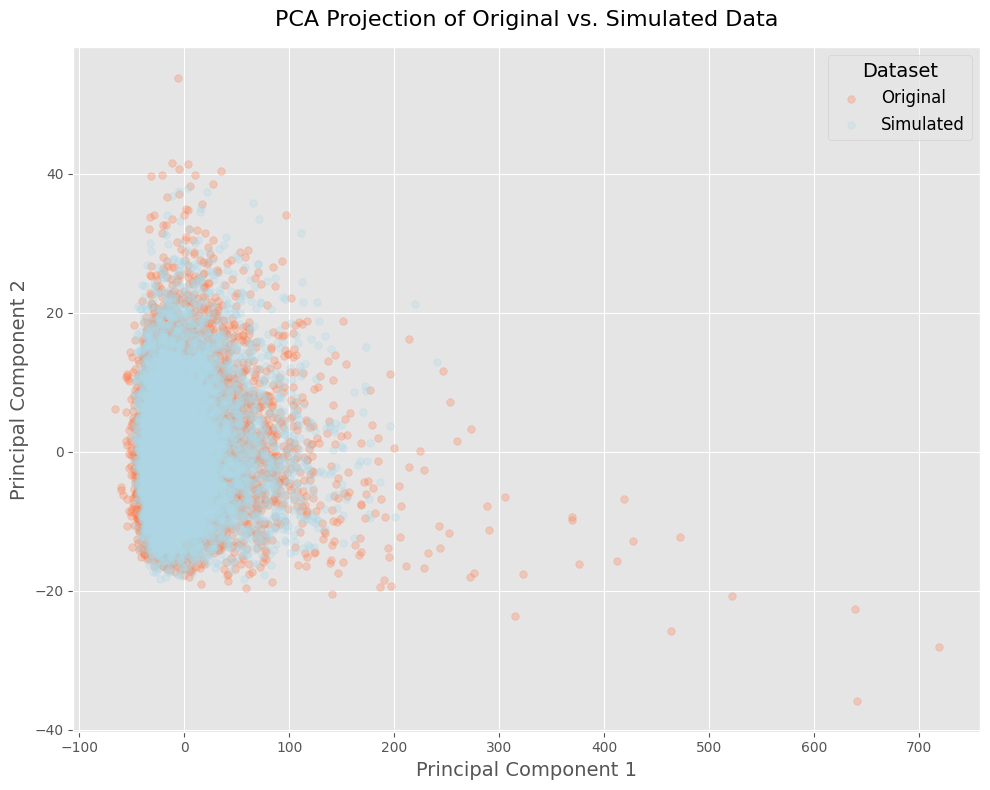

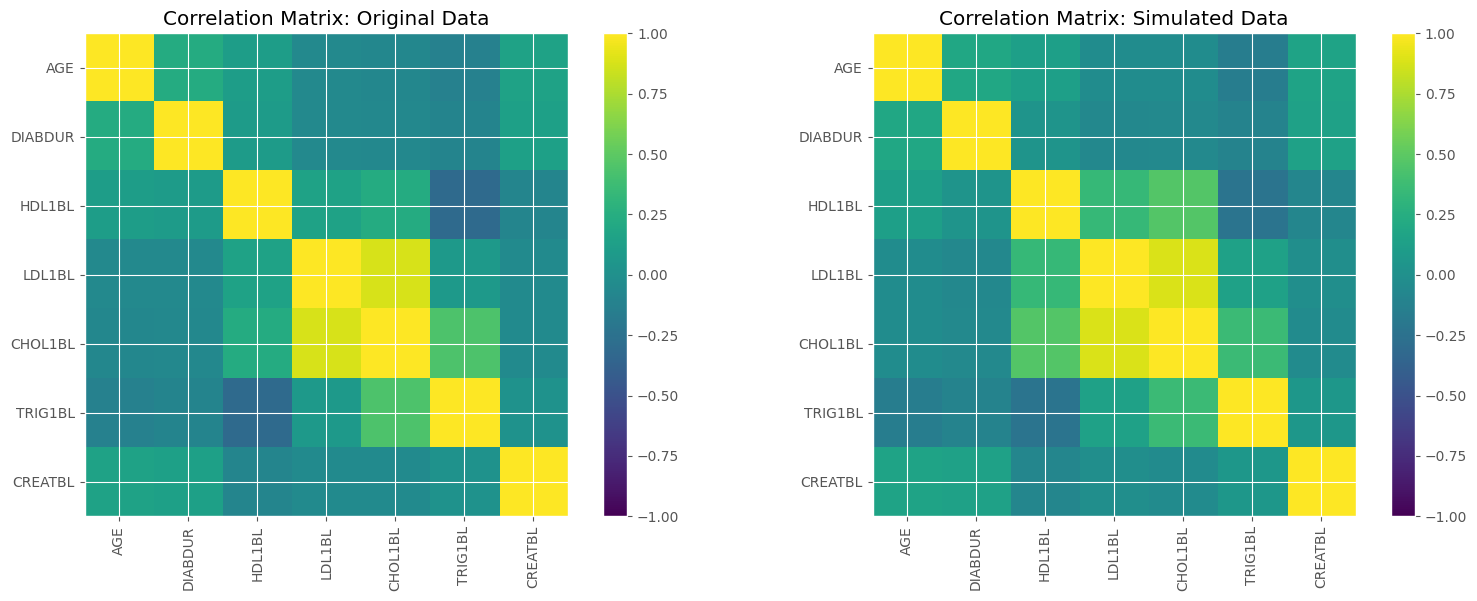

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2749
           1       0.50      0.50      0.50      2748

    accuracy                           0.50      5497
   macro avg       0.50      0.50      0.50      5497
weighted avg       0.50      0.50      0.50      5497

Accuracy: 0.50
ROC AUC: 0.53


In [11]:
x,s_pred=model_bsl.sample_xz(sample_size=s_tensor.shape[0])

original_df = deepcopy(df_bsl_features)
simulated_df = pd.DataFrame(s_pred.numpy())
simulated_df.columns = original_df.columns
original_df ['source'] = 'original'
simulated_df['source'] = 'simulated'
# original_df.drop(columns={'USUBJID'},inplace=True)
combined_df = pd.concat([original_df, simulated_df], ignore_index=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

original_df['source'] = 'Original'
simulated_df['source'] = 'Simulated'

combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
features = combined_df.drop(columns='source')
labels = combined_df['source']

# --- PCA Transformation ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['source'] = labels.values

style = 'seaborn' if 'seaborn' in plt.style.available else 'ggplot'
plt.style.use(style)

fig, ax = plt.subplots(figsize=(10, 8))


colors = {'Original': 'coral', 'Simulated': 'lightblue'}

for group in pca_df['source'].unique():
    group_data = pca_df[pca_df['source'] == group]
    ax.scatter(group_data['PC1'], group_data['PC2'],
               s=30, alpha=0.3, label=group, color=colors[group])

ax.set_title('PCA Projection of Original vs. Simulated Data', fontsize=16, pad=15)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)

ax.legend(title='Dataset', fontsize=12, title_fontsize=14, loc='best')

plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ---------------------------
# 1. Population Summary Comparison
# ---------------------------
# Compute mean values for each covariate
original_df.drop(columns={'source'},inplace=True)
simulated_df.drop(columns={'source'},inplace=True)
mean_original = original_df.mean()
mean_simulated = simulated_df.mean()

# Create a grouped bar chart comparing means
x = np.arange(len(mean_original))  # positions for each covariate
width = 0.35  # width of the bars

# plt.style.use('ggplot')  # Use a beautiful built-in style
# fig, ax = plt.subplots(figsize=(12, 6))
# rects1 = ax.bar(x - width/2, mean_original, width, label='Original')
# rects2 = ax.bar(x + width/2, mean_simulated, width, label='Simulated')

# ax.set_xticks(x)
# ax.set_xticklabels(original_df.columns, rotation=45, ha='right')
# ax.set_ylabel('Mean Value')
# ax.set_title('Comparison of Mean Values by Covariate')
# ax.legend()
# plt.tight_layout()
# plt.show()


corr_original = original_df.corr()
corr_simulated = simulated_df.corr()

# Create two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for original data
im0 = axes[0].imshow(corr_original, cmap='viridis', vmin=-1, vmax=1)
axes[0].set_title('Correlation Matrix: Original Data')
axes[0].set_xticks(np.arange(len(corr_original.columns)))
axes[0].set_xticklabels(corr_original.columns, rotation=90)
axes[0].set_yticks(np.arange(len(corr_original.columns)))
axes[0].set_yticklabels(corr_original.columns)
plt.colorbar(im0, ax=axes[0])

# Heatmap for simulated data
im1 = axes[1].imshow(corr_simulated, cmap='viridis', vmin=-1, vmax=1)
axes[1].set_title('Correlation Matrix: Simulated Data')
axes[1].set_xticks(np.arange(len(corr_simulated.columns)))
axes[1].set_xticklabels(corr_simulated.columns, rotation=90)
axes[1].set_yticks(np.arange(len(corr_simulated.columns)))
axes[1].set_yticklabels(corr_simulated.columns)
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


orig = original_df.copy()
sim = simulated_df.copy()

orig['label'] = 0
sim['label'] = 1

# Combine the datasets
combined_df = pd.concat([orig, sim], ignore_index=True)

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into training and testing sets (stratified to maintain label balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Get predictions and predicted probabilities for AUC calculation
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC: {:.2f}".format(auc))

# If the two datasets are very similar, even a strong classifier should perform poorly
# (accuracy near 50% and AUC near 0.5), indicating that it is difficult to tell them apart.


In [ ]:
model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=11, s_dim = s_tensor.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=20000, lr=1e-3, print_every_iter=1000,reg_lambda=1)

Epoch 1: loss 908688128.0000,	loss_y 1.4186, 1.4292, 0.0212,	loss_eta 7.6961, 8.9456, 2.4990, 	marginal_loss 908688128.0000
Epoch 1: y_sample_mean 0.013386787846684456
Epoch 1: y_sample1_cat.float().mean() 0.2882642447948456
Epoch 1000: loss 3.1780,	loss_y 0.1624, 0.1893, 0.0539,	loss_eta 2.2783, 4.8610, 5.1654, 	marginal_loss 0.7373
Epoch 1000: y_sample_mean 0.013515792787075043
Epoch 1000: y_sample1_cat.float().mean() 0.009075778536498547
Epoch 2000: loss 3.2141,	loss_y 0.1536, 0.2028, 0.0985,	loss_eta 2.3003, 4.9281, 5.2555, 	marginal_loss 0.7602
Epoch 2000: y_sample_mean 0.013297476805746555
Epoch 2000: y_sample1_cat.float().mean() 0.009149864315986633
Epoch 3000: loss 2.9897,	loss_y 0.1536, 0.2182, 0.1292,	loss_eta 2.2880, 5.0058, 5.4355, 	marginal_loss 0.5480
Epoch 3000: y_sample_mean 0.013357017189264297
Epoch 3000: y_sample1_cat.float().mean() 0.011044597253203392
Epoch 4000: loss 3.0084,	loss_y 0.1518, 0.2215, 0.1394,	loss_eta 2.2826, 5.0295, 5.4938, 	marginal_loss 0.5741
Epoc

In [13]:
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=10000, lr=1e-3, print_every_iter=500)

Epoch 1: loss 25.4281, loss1 25.5193, loss2 0.1824
Epoch 500: loss 1.9813, loss1 3.8341, loss2 3.7056
Epoch 1000: loss 1.9222, loss1 3.7327, loss2 3.6211
Epoch 1500: loss 1.8914, loss1 3.6884, loss2 3.5941
Epoch 2000: loss 1.8817, loss1 3.6659, loss2 3.5685
Epoch 2500: loss 1.8722, loss1 3.6454, loss2 3.5465
Epoch 3000: loss 1.8643, loss1 3.6421, loss2 3.5557
Epoch 3500: loss 1.8686, loss1 3.6604, loss2 3.5837
Epoch 4000: loss 1.8600, loss1 3.6623, loss2 3.6045
Epoch 4500: loss 1.8585, loss1 3.6605, loss2 3.6040
Epoch 5000: loss 1.8554, loss1 3.6529, loss2 3.5951
Epoch 5500: loss 1.8439, loss1 3.6462, loss2 3.6046
Epoch 6000: loss 1.8288, loss1 3.6324, loss2 3.6071
Epoch 6500: loss 1.8281, loss1 3.6479, loss2 3.6397
Epoch 7000: loss 1.8250, loss1 3.6308, loss2 3.6115
Epoch 7500: loss 1.8446, loss1 3.6501, loss2 3.6110
Epoch 8000: loss 1.8149, loss1 3.6508, loss2 3.6719
Epoch 8500: loss 1.8184, loss1 3.6436, loss2 3.6505
Epoch 9000: loss 1.8177, loss1 3.6103, loss2 3.5850
Epoch 9500: lo

In [14]:
def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    # Create a copy of y to work on
    y_out = y.clone()  # or copy.deepcopy(y) if you prefer
    # Create an event indicator: 1 where y > 0, else 0.
    event_indicator = (y_out > 0).float()
    # Compute the cumulative sum along the time dimension.
    c = torch.cumsum(event_indicator, dim=1)
    # Shift the cumulative sum one time step to the right.
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    # Create a mask that is True for time steps after the first event (i.e., where c_shifted > 0)
    mask = (c_shifted > 0)
    # Mask the y_out values after the first event.
    y_out[mask] = missing_to_num

    # If neither x nor z is provided, return only y_out.
    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape  # infer number of observations and timesteps from y

    # Process x if provided.
    x_out = None
    if x is not None:
        # Reshape to (n_obs, timesteps, x_dim)
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        # Expand mask to cover the x_dim features.
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        # Apply the mask to x_out.
        x_out[mask_expanded] = missing_to_num
        # Reshape x_out back to its original shape.
        x_out = x_out.view(n_obs, timesteps * x_dim)

    # Process z if provided.
    z_out = None
    if z is not None:

        # Reshape to (n_obs, timesteps, z_dim)
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        # Expand mask to cover the z_dim features.
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        # Apply the mask to z_out.
        z_out[mask_expanded] = missing_to_num
        # Reshape z_out back to its original shape.
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out

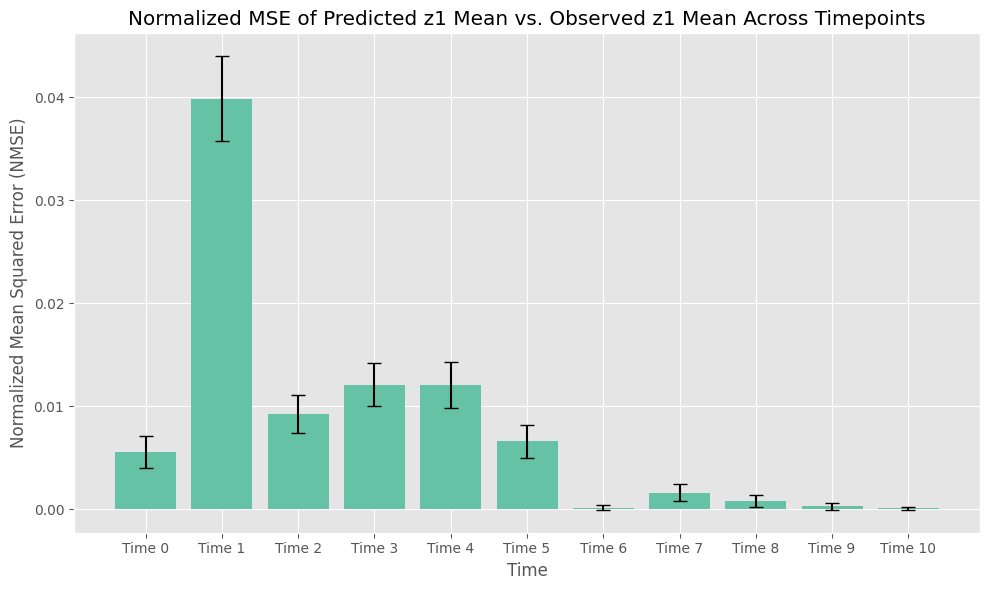

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
n_obs, total_dim = z_tensor.shape
timepoints = 11
z_dim = 1
num_samples = 500

x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=1)
# Reshape the observed z tensor: shape becomes (n_obs, timepoints, z_dim)
z_obs_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)
z1_obs = z_obs_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)

# Compute the observed mean and variance (using sample variance) across observations for each timepoint
z1_obs_mean = np.mean(z1_obs, axis=0)           # shape: (timepoints,)
z1_obs_var = np.var(z1_obs, axis=0, ddof=1)       # shape: (timepoints,)

# Initialize list to collect predictions for z1
z1_samples = []

# Generate predictions in each iteration
for _ in range(num_samples):
    # Sample new predictions each time
    _, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred, )
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=1)
    
    # Reshape predictions: (n_obs, timepoints, z_dim)
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)
    
    # Extract z1 and convert to numpy array
    z1_pred = z_pred_reshaped[:, :, 0].detach().cpu().numpy()
    z1_samples.append(z1_pred)

# Stack predicted samples to create an array of shape (num_samples, n_obs, timepoints)
z1_samples_array = np.stack(z1_samples, axis=0)

# For each predicted sample, compute its mean across observations (shape: (num_samples, timepoints))
z1_samples_mean = np.mean(z1_samples_array, axis=1)

# Calculate the squared errors for each sample and timepoint: (predicted mean - observed mean)^2
squared_errors = (z1_samples_mean - z1_obs_mean)**2

# Normalize squared errors by dividing by the variance at each timepoint
# This yields a normalized squared error for each sample and timepoint.
normalized_squared_errors = squared_errors / z1_obs_var

# For each timepoint, compute:
# - The mean normalized MSE across all samples
# - The standard deviation of the normalized MSE (to use as error bars)
nmse_mean = np.mean(normalized_squared_errors, axis=0)
nmse_std = np.std(normalized_squared_errors, axis=0, ddof=1)

# Create a bar plot with error bars
time = np.arange(timepoints)
plt.figure(figsize=(10, 6))
plt.bar(time, nmse_mean, yerr=nmse_std, capsize=5, color=sns.color_palette("Set2")[0])
plt.xlabel("Time")
plt.ylabel("Normalized Mean Squared Error (NMSE)")
plt.title("Normalized MSE of Predicted z1 Mean vs. Observed z1 Mean Across Timepoints")
plt.xticks(time, [f"Time {t}" for t in time])
plt.tight_layout()
plt.show()


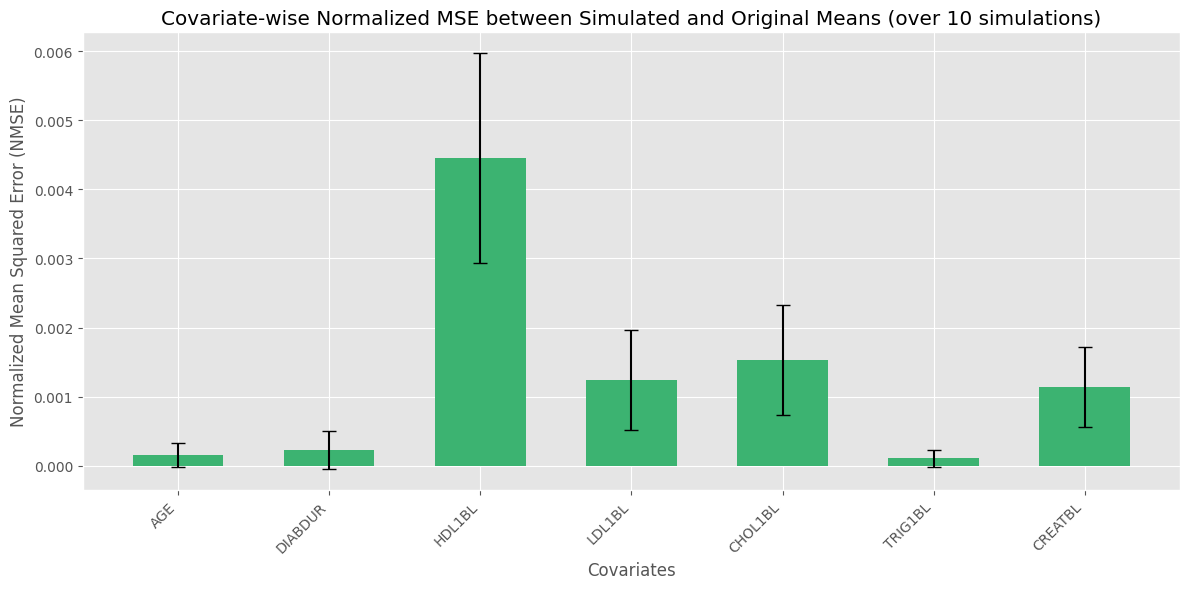

Classification Accuracy: Mean=0.515, Std=0.011, Min=0.492, Max=0.530
Classification AUC: Mean=0.535, Std=0.011, Min=0.511, Max=0.549


In [16]:

# Parameters for simulation loop
num_simulations = 10  # adjust as needed
accuracy_list = []
auc_list = []
# To store squared errors for each covariate in each simulation
covariate_squared_errors = []

# original_df is assumed to be created from df_bsl_features (the original covariate data)
original_df = deepcopy(df_bsl_features)
original_df['source'] = 'Original'
# Compute the means for the original covariates (drop any non-covariate columns if necessary)
orig_cov_means = original_df.drop(columns='source').mean()

# Compute standard deviation for each covariate in the original data
orig_cov_std = original_df.drop(columns='source').std(ddof=1)

# Initialize a list to store normalized squared errors
normalized_covariate_squared_errors = []

for i in range(num_simulations):
    # Sample s_pred (and x if needed)
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Convert simulated s_pred to DataFrame with matching column names
    simulated_df = pd.DataFrame(s_pred.detach().cpu().numpy(), 
                                columns=original_df.drop(columns='source').columns)
    simulated_df['source'] = 'Simulated'
    
    # Combine original and simulated data for classification (if needed)
    combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
    X = combined_df.drop(columns='source')
    y = combined_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split data and train logistic regression as before...
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                        random_state=42, stratify=y)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    accuracy_list.append(accuracy_score(y_test, y_pred))
    auc_list.append(roc_auc_score(y_test, y_pred_proba))
    
    # Compute the squared error between simulated and original means for each covariate
    sim_cov_means = simulated_df.drop(columns='source').mean()
    # Normalize squared error by dividing by variance (i.e., std^2)
    normalized_error = ((sim_cov_means - orig_cov_means) / orig_cov_std) ** 2
    normalized_covariate_squared_errors.append(normalized_error)

# Convert the list of normalized squared errors into a DataFrame for analysis
norm_cov_err_df = pd.DataFrame(normalized_covariate_squared_errors)

# Compute mean and std of normalized errors for each covariate
norm_mse_mean_cov = norm_cov_err_df.mean()
norm_mse_std_cov = norm_cov_err_df.std(ddof=1)

# Bar plot for normalized MSE of covariates with error bars
fig, ax = plt.subplots(figsize=(12, 6))
x_positions = np.arange(len(norm_mse_mean_cov))
width = 0.6
ax.bar(x_positions, norm_mse_mean_cov, yerr=norm_mse_std_cov, capsize=5, width=width, color='mediumseagreen')
ax.set_xticks(x_positions)
ax.set_xticklabels(norm_mse_mean_cov.index, rotation=45, ha='right')
ax.set_xlabel('Covariates')
ax.set_ylabel('Normalized Mean Squared Error (NMSE)')
ax.set_title('Covariate-wise Normalized MSE between Simulated and Original Means (over {} simulations)'.format(num_simulations))
plt.tight_layout()
plt.show()

# Print summary statistics for classification performance over simulations
print("Classification Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("Classification AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


In [17]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# --- Preprocessing the True (Original) Joint Data using s, z1, and y ---
# Assume missing_impute is defined and the original tensors exist.
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=1)

# Define parameters for reshaping z
n_obs = z_tensor.shape[0]
timepoints = 11
z_dim = 1

# Convert s and y tensors to numpy arrays
s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, y_dim)

# Process z: reshape and extract z1 (first dimension over time)
z_true_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)   # shape: (n_obs, timepoints, z_dim)
z1_true_np = z_true_reshaped[:, :, 0].detach().cpu().numpy()     # shape: (n_obs, timepoints)

# Create a DataFrame for the original joint data using s, z1, and y
# Name columns for s, z1 (across timepoints), and y
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_time_{t}' for t in range(timepoints)]
y_cols = [f'y_{i}' for i in range(y_true_np.shape[1])]

original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true_np, y_true_np], axis=1),
    columns = s_cols + z1_cols + y_cols
)

# original_joint_df = pd.DataFrame(
#     np.concatenate([s_true_np, z1_true_np], axis=1),
#     columns = s_cols+z1_cols
# )
original_joint_df['source'] = 'Original'

# --- Simulation Loop ---
num_simulations = 10  # adjust as needed
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample a new s_pred from the baseline model
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Get joint predictions from your main model using the sampled s_pred
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply missing data imputation to the predictions
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=1)
    
    # Convert predicted s and y tensors to numpy arrays
    s_pred_np = s_pred.detach().cpu().numpy()    # shape: (n_obs, s_dim)
    y_pred_np = y_pred.detach().cpu().numpy()      # shape: (n_obs, y_dim)
    
    # Process predicted z: reshape and extract z1
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)  # shape: (n_obs, timepoints, z_dim)
    z1_pred_np = z_pred_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)
    z1_pred_np = np.round(z1_pred_np, 1)
    
    #Create a DataFrame for the simulated joint data (using s, z1, and y)
    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z1_pred_np, y_pred_np], axis=1),
        columns = s_cols + z1_cols + y_cols
    )

    # simulated_joint_df = pd.DataFrame(
    #     np.concatenate([s_pred_np, z1_pred_np], axis=1),
    #     columns = s_cols+z1_cols
    # )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=42, stratify=y_joint
    )
    
    # Train a logistic regression classifier on the joint data (s, z1, and y)
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_class = clf_joint.predict(X_test)
    y_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC for this simulation iteration
    accuracy_joint = accuracy_score(y_test, y_pred_class)
    auc_joint = roc_auc_score(y_test, y_pred_proba)
    
    # Store the results
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (s, z1, and y) over {} simulations:".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


Joint Data Classification Results (s, z1, and y) over 10 simulations:
Accuracy: Mean=0.584, Std=0.006, Min=0.576, Max=0.598
AUC: Mean=0.630, Std=0.006, Min=0.625, Max=0.644


In [18]:
clf_joint.coef_

array([[-6.50310450e-03,  5.45796246e-03,  1.32954882e-01,
         5.31954517e-01, -4.96969068e-01,  1.21366942e-01,
        -2.03224070e-03,  1.19141226e-02, -1.12828859e-01,
         7.85689556e-02, -3.71713651e-02, -1.94985501e-01,
        -9.00942169e-02,  3.34516729e-01, -1.76511244e-01,
         4.03748562e-01, -4.37007031e-01, -3.82122100e-02,
         0.00000000e+00, -1.35008990e-01, -7.11040595e-02,
         2.15435775e-01,  8.08340043e-01,  7.86610807e-01,
        -1.05072945e+00,  2.98082864e-01, -2.78533111e+00,
         8.07768233e-01,  2.85917710e+00]])

## OK now let's train all three covariates...

In [21]:
import pandas as pd
import numpy as np
import torch
from copy import deepcopy

# ------------------------- Load Your Data -------------------------
df_z1 = deepcopy(df_hba1c)   # longitudinal covariate z1
df_z2 = deepcopy(df_egfr)    # longitudinal covariate z2
df_z3 = deepcopy(df_bmi)     # longitudinal covariate z3
df_bsl = deepcopy(df_bsl_read)    # baseline covariates
df_Y = deepcopy(df_Y_read)        # outcome
df_bsl.dropna(inplace=True)

# --------------------- Process df_Y (Outcome) ---------------------
# Ensure Y0 exists and select Y0 to Y10.
if 'Y0' not in df_Y.columns:
    df_Y.insert(1, 'Y0', 0.0)
df_Y = df_Y[['USUBJID'] + [f'Y{i}' for i in range(0, 11)]]

# ----------------- Time Points You Care About ---------------------
# (These are the actual numeric time values corresponding to Y0 ... Y10.)
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]


# ----------------- Longitudinal Processing Function -----------------
def process_longitudinal(df, time_points):
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points if str(tp) in df.columns]].copy()
    for tp in time_points:
        col = str(tp)
        if col not in df.columns:
            df.loc[:, col] = np.nan
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points]]

    df['na_count'] = df.isna().sum(axis=1)
    df = df.loc[df['na_count'] <= 5].drop(columns='na_count').reset_index(drop=True)

    for idx in range(len(df)):
        for t_idx, t in enumerate(time_points):
            col = str(t)
            if pd.isna(df.loc[idx, col]):
                for prev_t in reversed(time_points[:t_idx]):
                    prev_col = str(prev_t)
                    if not pd.isna(df.loc[idx, prev_col]):
                        df.loc[idx, col] = df.loc[idx, prev_col]
                        break

    return df

# ------------- Process and Clean z1, z2, z3 ----------------
df_z1_clean = process_longitudinal(df_z1, time_points)
df_z2_clean = process_longitudinal(df_z2, time_points)
df_z3_clean = process_longitudinal(df_z3, time_points)


df_z1_clean = df_z1_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z2_clean = df_z2_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z3_clean = df_z3_clean.dropna(axis=0, how='any').reset_index(drop=True)



# Note: We do not call dropna(axis=0, how='any') here because we now allow missing post-event.
# If desired, you could further filter rows if you really want no remaining NAs in the pre-event period,
# but the imputation above should have filled those.

# ------------ Align All by Intersection of USUBJID -------------
common_ids = (set(df_Y['USUBJID']) 
              & set(df_z1_clean['USUBJID']) 
              & set(df_z2_clean['USUBJID']) 
              & set(df_z3_clean['USUBJID']) 
              & set(df_bsl['USUBJID']))
df_Y = df_Y[df_Y['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z1_clean = df_z1_clean[df_z1_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z2_clean = df_z2_clean[df_z2_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z3_clean = df_z3_clean[df_z3_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_bsl = df_bsl[df_bsl['USUBJID'].isin(common_ids)].reset_index(drop=True)

# ------------ Sort all by USUBJID to align ----------------------
df_Y.sort_values(by='USUBJID', inplace=True)
df_z1_clean.sort_values(by='USUBJID', inplace=True)
df_z2_clean.sort_values(by='USUBJID', inplace=True)
df_z3_clean.sort_values(by='USUBJID', inplace=True)
df_bsl.sort_values(by='USUBJID', inplace=True)

# ----------------- Build the Z torch tensor (longitudinal) ----------------------
# For this example, we only use z1 for demonstration.
Z_list = []
for idx in range(len(df_z1_clean)):
    z1_vals = df_z1_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z2_vals = df_z2_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z3_vals = df_z3_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    # If you want to include z2 and z3 use np.column_stack as in:
    Z_subj = np.column_stack([z1_vals, z2_vals, z3_vals]).reshape(-1)
    # Z_subj = z1_vals.reshape(-1)
    Z_list.append(Z_subj.astype(np.float32))

z_tensor = torch.tensor(np.vstack(Z_list), dtype=torch.float32)  # Shape (n_subjects, len(time_points))
# ----------------- Build the X tensor (ARM repeated over time) -------------------
# Pull ARM values from df_bsl; assume 'ARM' is a column.
arm_values = df_bsl['ARM'].astype(float).values  # shape (n_subjects,)
x_tensor = torch.tensor(np.repeat(arm_values[:, np.newaxis], len(time_points), axis=1), dtype=torch.int32)
# ------------------ Build the y torch tensor ----------------------
y_cols = [f'Y{i}' for i in range(0, 11)]
y_np = df_Y[y_cols].astype(float).values  # Ensure it's float so that NaN is preserved
y_tensor = torch.tensor(y_np, dtype=torch.int32)
# ----------------- Build the S tensor (baseline features) -------------------
df_bsl_features = df_bsl.drop(columns=['USUBJID','ARM',  
    'RACE_AMERICAN.INDIAN.OR.ALASKA.NATIVE',
    'RACE_NATIVE.HAWAIIAN.OR.OTHER.PACIFIC.ISLANDER',
    'RACE_OTHER',
    'RACE_ASIAN',
    'RACE_BLACK.OR.AFRICAN.AMERICAN','SEX_F', 
    'SMOKER_CURRENT.SMOKER',
    'SMOKER_NEVER.SMOKED', 
    'MIFL', 'STROKEFL', 'STENFL', 'NEPSCRFL',
    'KIDFL',"HBA1CBL","BMIBL"
    ])
df_bsl_features = df_bsl_features.astype(float)
x_bsl_tensor = torch.tensor(df_bsl['ARM'].values, dtype=torch.int32).view(-1, 1)
s_tensor = torch.tensor(df_bsl_features.values, dtype=torch.float32)

# ----------------- Check shape -------------------
print(f"s_tensor shape: {s_tensor.shape}")  # (n_subjects, num_baseline_features)
print(f"z_tensor shape: {z_tensor.shape}")  # (n_subjects, {len(time_points)}) 
print(f"x_tensor shape (ARM): {x_tensor.shape}")  # (n_subjects, 11)
print(f"y_tensor shape: {y_tensor.shape}")  # (n_subjects, 11)

# Optional: Sanity check USUBJID order alignment.
print(np.all(df_Y['USUBJID'].values == df_z1_clean['USUBJID'].values) and np.all(df_Y['USUBJID'].values == df_bsl['USUBJID'].values))
print(torch.isnan(y_tensor).any())  # Returns True if any NaN exists

# Optional: Count the number of 1's in a DataFrame.
# For example, to count total number of 1s in df_Y (excluding the USUBJID column):
ones_count = (df_Y.drop(columns=['USUBJID']) == 1).sum().sum()
print("Total number of 1s in df_Y:", ones_count)


s_tensor shape: torch.Size([9161, 7])
z_tensor shape: torch.Size([9161, 33])
x_tensor shape (ARM): torch.Size([9161, 11])
y_tensor shape: torch.Size([9161, 11])
True
tensor(False)
Total number of 1s in df_Y: 1267


In [25]:
model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=3, T=11, s_dim = s_tensor.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=25000, lr=1e-3, print_every_iter=1000,reg_lambda=1)

Epoch 1: loss 48779771904.0000,	loss_y 2.3398, 2.3503, 0.0208,	loss_eta 11.5756, 13.5517, 3.9523, 	marginal_loss 48779771904.0000
Epoch 1: y_sample_mean 0.013386787846684456
Epoch 1: y_sample1_cat.float().mean() 0.675286591053009
Epoch 1000: loss 21.2776,	loss_y 0.1708, 0.1943, 0.0469,	loss_eta 21.0574, 46.0355, 49.9562, 	marginal_loss 0.0494
Epoch 1000: y_sample_mean 0.013257782906293869
Epoch 1000: y_sample1_cat.float().mean() 0.01333639770746231
Epoch 2000: loss 21.2631,	loss_y 0.1646, 0.2041, 0.0790,	loss_eta 21.0792, 47.0896, 52.0209, 	marginal_loss 0.0194
Epoch 2000: y_sample_mean 0.013535640202462673
Epoch 2000: y_sample1_cat.float().mean() 0.013071011751890182
Epoch 3000: loss 21.2089,	loss_y 0.1612, 0.2166, 0.1108,	loss_eta 21.0337, 46.8378, 51.6082, 	marginal_loss 0.0141
Epoch 3000: y_sample_mean 0.013555487617850304
Epoch 3000: y_sample1_cat.float().mean() 0.013643668033182621
Epoch 4000: loss 21.1521,	loss_y 0.1585, 0.2205, 0.1240,	loss_eta 20.9835, 47.0501, 52.1333, 	margi

In [26]:
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=10000, lr=5e-4, print_every_iter=500)

Epoch 1: loss 276.8790, loss1 277.0322, loss2 0.3065
Epoch 500: loss 19.4578, loss1 34.8574, loss2 30.7992
Epoch 1000: loss 17.9388, loss1 35.6221, loss2 35.3665
Epoch 1500: loss 16.6503, loss1 32.9795, loss2 32.6584
Epoch 2000: loss 14.8490, loss1 28.6572, loss2 27.6165
Epoch 2500: loss 14.3197, loss1 27.8297, loss2 27.0200
Epoch 3000: loss 14.1892, loss1 27.5421, loss2 26.7058
Epoch 3500: loss 14.1945, loss1 27.9552, loss2 27.5213
Epoch 4000: loss 14.1467, loss1 27.7668, loss2 27.2402
Epoch 4500: loss 14.1985, loss1 28.0351, loss2 27.6732
Epoch 5000: loss 14.0129, loss1 27.6583, loss2 27.2907
Epoch 5500: loss 14.0399, loss1 27.9800, loss2 27.8802
Epoch 6000: loss 14.0909, loss1 28.0841, loss2 27.9865
Epoch 6500: loss 13.9850, loss1 27.9030, loss2 27.8359
Epoch 7000: loss 13.9345, loss1 27.8663, loss2 27.8637
Epoch 7500: loss 13.9375, loss1 28.1310, loss2 28.3869
Epoch 8000: loss 13.9714, loss1 27.7727, loss2 27.6026
Epoch 8500: loss 14.0056, loss1 27.7474, loss2 27.4836
Epoch 9000: l

## slicing

In [28]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# --------------------------------------------------------------------
# Helper: Missing imputation function (as you already defined)
def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    y_out = y.clone() 
    event_indicator = (y_out > 0).float()
    c = torch.cumsum(event_indicator, dim=1)
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    mask = (c_shifted > 0)
    y_out[mask] = missing_to_num

    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape  
    x_out = None
    if x is not None:
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        x_out[mask_expanded] = missing_to_num
        x_out = x_out.view(n_obs, timesteps * x_dim)

    z_out = None
    if z is not None:
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        z_out[mask_expanded] = missing_to_num
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out

# --------------------------------------------------------------------
# Define overall time grid (11 time points) and the observed indices for z2 and z3.
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]  # indices 0,...,10
# Given original measurement times for z2 and z3: 0, 12, 24, 36, 48, 6, 60,
# sort them into increasing order: 0, 6, 12, 24, 36, 48, 60.
# The corresponding indices in the overall time grid are:
observed_idx = [0, 1, 2, 4, 6, 8, 10]

# --------------------------------------------------------------------
# --- Preprocessing the True (Original) Joint Data ---
# Here we assume that the function missing_impute has already been applied to your original tensors.
# x_tensor, z_tensor, y_tensor, and s_tensor are assumed to exist.
# Note: z_tensor is assumed to be of shape (n_obs, 33); it stacks z1, z2, and z3, each across 11 time points.

# Apply the missing imputation to the original tensors
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Convert true tensors to numpy arrays for DataFrame creation
s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, 11)

# Reshape z_tensor to (n_obs, 11, 3)
n_obs = z_tensor.shape[0]
z_true_reshaped = z_tensor.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
# Extract z1: use all 11 time points
z1_true = z_true_reshaped[:, :, 0]              # shape: (n_obs, 11)
# For z2 and z3: extract only the observed indices
z2_true = z_true_reshaped[:, observed_idx, 1]     # shape: (n_obs, len(observed_idx))
z3_true = z_true_reshaped[:, observed_idx, 2]     # shape: (n_obs, len(observed_idx))

# Create column names for each block of features.
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_{t}' for t in time_points]  # all time points for z1
y_cols  = [f'y_{t}' for t in time_points]
z2_cols = [f'z2_{time_points[i]}' for i in observed_idx]
z3_cols = [f'z3_{time_points[i]}' for i in observed_idx]

# Build the original (true) joint DataFrame by concatenating the features along the columns.
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true, y_true_np, z2_true, z3_true], axis=1),
    columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
)
original_joint_df['source'] = 'Original'

# --------------------------------------------------------------------
# --- Simulation Loop ---
num_simulations = 100  
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample from the baseline model to get new s (and x if needed)
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Sample joint predictions from your main model using the simulated baseline features s_pred
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply the missing imputation on simulated predictions.
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Convert simulated s, y into numpy arrays.
    s_pred_np = s_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    
    # Reshape simulated z_pred to (n_obs, 11, 3)
    z_pred_reshaped = z_pred.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
    # Extract the simulated z1 (all time points)
    z1_pred = z_pred_reshaped[:, :, 0]             
    # And for z2 and z3, take only the observed indices
    z2_pred = z_pred_reshaped[:, observed_idx, 1]
    z3_pred = z_pred_reshaped[:, observed_idx, 2]
    
    # Build the simulated joint DataFrame with the same feature ordering.
    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z1_pred, y_pred_np, z2_pred, z3_pred], axis=1),
        columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
    )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data.
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    combined_joint_df= combined_joint_df.round(1)
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into train and test sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=2025, stratify=y_joint
    )
    
    # Train the logistic regression classifier.
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set.
    y_joint_pred = clf_joint.predict(X_test)
    y_joint_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC.
    accuracy_joint = accuracy_score(y_test, y_joint_pred)
    auc_joint = roc_auc_score(y_test, y_joint_pred_proba)
    
    # Save the results.
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (over {} simulations):".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


Joint Data Classification Results (over 100 simulations):
Accuracy: Mean=0.603, Std=0.006, Min=0.592, Max=0.623
AUC: Mean=0.638, Std=0.007, Min=0.620, Max=0.656


In [29]:
z_tensor

tensor([[  7.1000,  96.7000,  31.6000,  ...,   7.1000,  96.7000,  31.6000],
        [  7.6000,  84.3000,  39.0000,  ...,   7.3000,  84.3000,  39.9000],
        [  9.9000,  84.4000,  30.8000,  ...,   9.6000,  76.0000,  30.1000],
        ...,
        [  8.6000,  93.1000,  33.7000,  ...,   6.3000,  77.2000,  33.1000],
        [  7.3000, 105.1000,  27.0000,  ...,   7.0000, 107.0000,  27.8000],
        [  7.1000,  82.6000,  29.0000,  ...,   6.7000,  73.3000,  27.9000]])

In [30]:
simulated_joint_df

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,z1_0,z1_6,z1_12,...,z2_48,z2_60,z3_0,z3_6,z3_12,z3_24,z3_36,z3_48,z3_60,source
0,56.730431,3.016913,1.398049,3.635263,5.816550,2.316315,46.187073,8.977136,6.824236,6.783174,...,107.711273,106.329643,32.881779,31.092772,29.909292,29.602659,32.267860,32.243633,32.049198,Simulated
1,64.519958,8.851570,1.416491,1.389114,3.024631,-0.329287,96.641449,7.658440,7.619295,7.606155,...,86.210373,82.075409,29.952860,28.585131,28.349691,28.786686,28.989735,30.742598,29.819092,Simulated
2,65.121788,8.633769,1.238712,4.039755,6.371638,3.834222,77.157990,8.959085,8.221574,8.129044,...,-1.000000,-1.000000,32.961208,34.327301,33.795254,-1.000000,-1.000000,-1.000000,-1.000000,Simulated
3,54.129646,7.750492,1.212255,1.721328,4.156551,2.382303,75.223198,8.681676,6.552622,6.865073,...,87.213364,82.376457,33.185238,34.081749,32.952858,32.704891,32.134380,31.330889,31.085831,Simulated
4,60.944973,1.615258,1.238654,2.800914,4.771709,1.711994,50.318726,8.749367,7.245740,6.602324,...,98.488655,126.570610,33.263397,30.191845,30.356752,32.092384,30.077169,29.657274,28.417692,Simulated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9156,68.286201,15.955139,1.166868,3.862385,6.238051,3.771114,109.682709,9.203831,7.506042,7.135292,...,55.253414,43.718071,34.145115,34.414516,32.162148,32.550549,30.712263,29.366680,31.123224,Simulated
9157,56.298294,9.377317,0.464860,1.129823,2.666013,2.067058,76.706673,8.461593,8.231077,8.934750,...,-1.000000,-1.000000,32.662334,32.871243,35.042271,-1.000000,-1.000000,-1.000000,-1.000000,Simulated
9158,74.300934,17.666281,1.177966,0.610474,2.172977,-0.337664,87.650276,7.760209,7.384509,7.278803,...,49.688469,42.892834,28.622847,29.472097,28.871881,31.071617,31.648958,33.863651,33.098984,Simulated
9159,61.524624,11.678941,0.888309,2.443072,4.160730,3.361471,65.518265,8.979634,8.308702,8.947436,...,96.440765,93.314049,33.605053,33.677704,34.246094,34.318672,34.342106,34.320141,34.940037,Simulated


In [31]:
clf_joint.coef_[0]

array([ 0.00173858, -0.00108274,  0.17748662,  0.57664488, -0.52647814,
        0.16299124, -0.00106884, -0.08745739,  0.02633537,  0.04439937,
        0.08943192,  0.14527016, -0.16403073, -0.09787043, -0.24316649,
        0.65599004, -0.38897198,  0.11849035,  0.        ,  0.12486308,
       -0.1323889 , -0.29648095, -0.24763761,  0.70042062, -0.36178618,
        0.7022275 , -0.10852272,  0.47852358,  0.43558983,  0.00143681,
        0.00519804,  0.00111774, -0.00591923,  0.01453925, -0.02632046,
        0.01066513, -0.07615205,  0.11018618,  0.0116919 , -0.03191518,
        0.03330436, -0.13051388,  0.07170641])

In [32]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# --- Preprocessing the True (Original) Joint Data using s, z1, and y ---
# Assume missing_impute is defined and the original tensors exist.
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Define parameters for reshaping z
n_obs = z_tensor.shape[0]
timepoints = 11
z_dim = 3

# Convert s and y tensors to numpy arrays
s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, y_dim)

# Process z: reshape and extract z1 (first dimension over time)
z_true_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)   # shape: (n_obs, timepoints, z_dim)
z1_true_np = z_true_reshaped[:, :, 0].detach().cpu().numpy()     # shape: (n_obs, timepoints)

# Create a DataFrame for the original joint data using s, z1, and y
# Name columns for s, z1 (across timepoints), and y
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_time_{t}' for t in range(timepoints)]
y_cols = [f'y_{i}' for i in range(y_true_np.shape[1])]

original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true_np, y_true_np], axis=1),
    columns = s_cols + z1_cols + y_cols
)

# original_joint_df = pd.DataFrame(
#     np.concatenate([s_true_np, y_true_np], axis=1),
#     columns = s_cols + y_cols
# )
original_joint_df['source'] = 'Original'

# --- Simulation Loop ---
num_simulations = 10  # adjust as needed
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample a new s_pred from the baseline model
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Get joint predictions from your main model using the sampled s_pred
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply missing data imputation to the predictions
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Convert predicted s and y tensors to numpy arrays
    s_pred_np = s_pred.detach().cpu().numpy()    # shape: (n_obs, s_dim)
    y_pred_np = y_pred.detach().cpu().numpy()      # shape: (n_obs, y_dim)
    
    # Process predicted z: reshape and extract z1
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)  # shape: (n_obs, timepoints, z_dim)
    z1_pred_np = z_pred_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)
    z1_pred_np = np.round(z1_pred_np, 1)
    
    # Create a DataFrame for the simulated joint data (using s, z1, and y)
    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z1_pred_np, y_pred_np], axis=1),
        columns = s_cols + z1_cols + y_cols
    )

    # simulated_joint_df = pd.DataFrame(
    #     np.concatenate([s_pred_np, y_pred_np], axis=1),
    #     columns = s_cols + y_cols
    # )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=42, stratify=y_joint
    )
    
    # Train a logistic regression classifier on the joint data (s, z1, and y)
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_class = clf_joint.predict(X_test)
    y_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC for this simulation iteration
    accuracy_joint = accuracy_score(y_test, y_pred_class)
    auc_joint = roc_auc_score(y_test, y_pred_proba)
    
    # Store the results
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (s, z1, and y) over {} simulations:".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


Joint Data Classification Results (s, z1, and y) over 10 simulations:
Accuracy: Mean=0.595, Std=0.005, Min=0.590, Max=0.603
AUC: Mean=0.621, Std=0.007, Min=0.611, Max=0.634


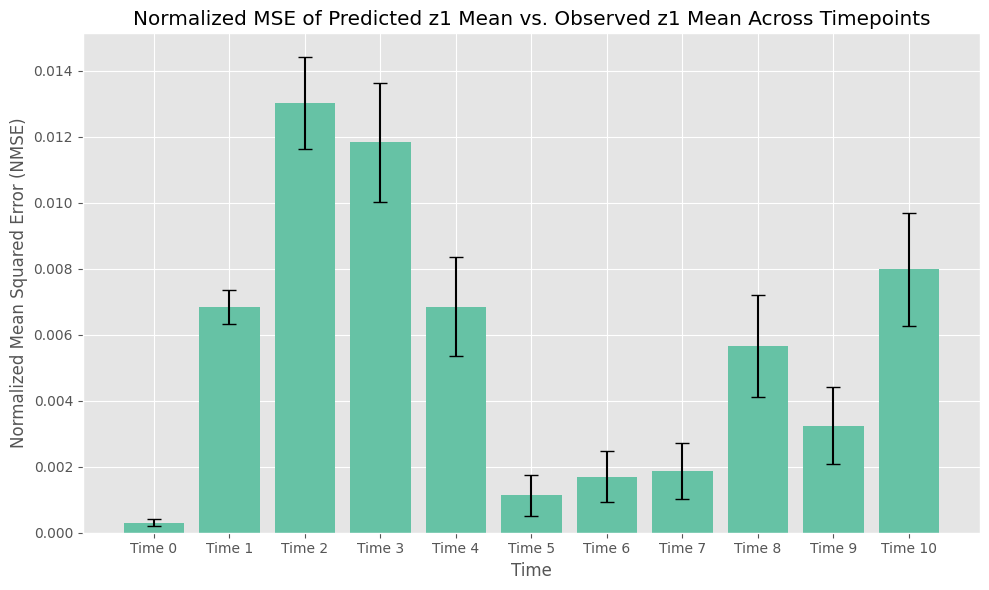

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
n_obs, total_dim = z_tensor.shape
timepoints = 11
z_dim = 3
num_samples = 500

x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)
# Reshape the observed z tensor: shape becomes (n_obs, timepoints, z_dim)
z_obs_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)
z1_obs = z_obs_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)

# Compute the observed mean and variance (using sample variance) across observations for each timepoint
z1_obs_mean = np.mean(z1_obs, axis=0)           # shape: (timepoints,)
z1_obs_var = np.var(z1_obs, axis=0, ddof=1)       # shape: (timepoints,)

# Initialize list to collect predictions for z1
z1_samples = []

# Generate predictions in each iteration
for _ in range(num_samples):
    # Sample new predictions each time
    _, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Reshape predictions: (n_obs, timepoints, z_dim)
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)
    
    # Extract z1 and convert to numpy array
    z1_pred = z_pred_reshaped[:, :, 0].detach().cpu().numpy()
    z1_samples.append(z1_pred)

# Stack predicted samples to create an array of shape (num_samples, n_obs, timepoints)
z1_samples_array = np.stack(z1_samples, axis=0)

# For each predicted sample, compute its mean across observations (shape: (num_samples, timepoints))
z1_samples_mean = np.mean(z1_samples_array, axis=1)

# Calculate the squared errors for each sample and timepoint: (predicted mean - observed mean)^2
squared_errors = (z1_samples_mean - z1_obs_mean)**2

# Normalize squared errors by dividing by the variance at each timepoint
# This yields a normalized squared error for each sample and timepoint.
normalized_squared_errors = squared_errors / z1_obs_var

# For each timepoint, compute:
# - The mean normalized MSE across all samples
# - The standard deviation of the normalized MSE (to use as error bars)
nmse_mean = np.mean(normalized_squared_errors, axis=0)
nmse_std = np.std(normalized_squared_errors, axis=0, ddof=1)

# Create a bar plot with error bars
time = np.arange(timepoints)
plt.figure(figsize=(10, 6))
plt.bar(time, nmse_mean, yerr=nmse_std, capsize=5, color=sns.color_palette("Set2")[0])
plt.xlabel("Time")
plt.ylabel("Normalized Mean Squared Error (NMSE)")
plt.title("Normalized MSE of Predicted z1 Mean vs. Observed z1 Mean Across Timepoints")
plt.xticks(time, [f"Time {t}" for t in time])
plt.tight_layout()
plt.show()


## do nothing 

In [34]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# --- Preprocessing the True (Original) Joint Data ---
# Assume that missing_impute is defined and the original tensors (x_tensor, z_tensor, y_tensor, s_tensor) exist.
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Convert the true tensors to numpy arrays (s_true_np is used as part of the joint features)
s_true_np = s_tensor.detach().cpu().numpy()
z_true_np = z_tensor.detach().cpu().numpy()
y_true_np = y_tensor.detach().cpu().numpy()

# Create a DataFrame for the original joint data
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z_true_np, y_true_np], axis=1),
    columns=[f's_{i}' for i in range(s_true_np.shape[1])] +
            [f'z_{i}' for i in range(z_true_np.shape[1])] +
            [f'y_{i}' for i in range(y_true_np.shape[1])]
)
original_joint_df['source'] = 'Original'

# --- Simulation Loop ---
num_simulations = 10  # adjust as needed
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample a new s_pred (and x_sim if needed) from the baseline model
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Get joint predictions from your main model using the sampled s_pred
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply missing data imputation to the predictions
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Convert predicted tensors to numpy arrays
    s_pred_np = s_pred.detach().cpu().numpy()
    z_pred_np = z_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    
    # Create a DataFrame for the simulated joint data
    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z_pred_np, y_pred_np], axis=1),
        columns=[f's_{i}' for i in range(s_pred_np.shape[1])] +
                [f'z_{i}' for i in range(z_pred_np.shape[1])] +
                [f'y_{i}' for i in range(y_pred_np.shape[1])]
    )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=2025, stratify=y_joint
    )
    
    # Train a logistic regression classifier on the joint data
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_joint_pred = clf_joint.predict(X_test)
    y_joint_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC for the simulation iteration
    accuracy_joint = accuracy_score(y_test, y_joint_pred)
    auc_joint = roc_auc_score(y_test, y_joint_pred_proba)
    
    # Store the results
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (over {} simulations):".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


Joint Data Classification Results (over 10 simulations):
Accuracy: Mean=0.629, Std=0.007, Min=0.618, Max=0.638
AUC: Mean=0.659, Std=0.005, Min=0.652, Max=0.668


## We now fit the model on all covariates, including binary ones.

In [ ]:
import pandas as pd
import numpy as np
import torch
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# ------------------------- Load Your Data -------------------------
df_z1 = deepcopy(df_hba1c)   # longitudinal covariate z1
df_z2 = deepcopy(df_egfr)    # longitudinal covariate z2
df_z3 = deepcopy(df_bmi)     # longitudinal covariate z3
df_bsl = deepcopy(df_bsl_read)    # baseline covariates
df_Y = deepcopy(df_Y_read)        # outcome
df_bsl.dropna(inplace=True)
df_bsl.drop(df_bsl[(df_bsl['TRIG1BL'] > 8) | (df_bsl['CREATBL'] > 160)].index, inplace=True)



# --------------------- Process df_Y (Outcome) ---------------------
# Ensure Y0 exists and select Y0 to Y10.
if 'Y0' not in df_Y.columns:
    df_Y.insert(1, 'Y0', 0.0)
df_Y = df_Y[['USUBJID'] + [f'Y{i}' for i in range(0, 11)]]

# ----------------- Time Points You Care About ---------------------
# (These are the actual numeric time values corresponding to Y0 ... Y10.)
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]

def process_longitudinal(df, time_points):
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points if str(tp) in df.columns]].copy()
    for tp in time_points:
        col = str(tp)
        if col not in df.columns:
            df.loc[:, col] = np.nan
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points]]

    df['na_count'] = df.isna().sum(axis=1)
    df = df.loc[df['na_count'] <= 5].drop(columns='na_count').reset_index(drop=True)

    for idx in range(len(df)):
        for t_idx, t in enumerate(time_points):
            col = str(t)
            if pd.isna(df.loc[idx, col]):
                for prev_t in reversed(time_points[:t_idx]):
                    prev_col = str(prev_t)
                    if not pd.isna(df.loc[idx, prev_col]):
                        df.loc[idx, col] = df.loc[idx, prev_col]
                        break

    return df

# ------------- Process and Clean z1, z2, z3 ----------------
df_z1_clean = process_longitudinal(df_z1, time_points)
df_z2_clean = process_longitudinal(df_z2, time_points)
df_z3_clean = process_longitudinal(df_z3, time_points)


df_z1_clean = df_z1_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z2_clean = df_z2_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z3_clean = df_z3_clean.dropna(axis=0, how='any').reset_index(drop=True)

# ------------ Align All by Intersection of USUBJID -------------
common_ids = (set(df_Y['USUBJID']) 
              & set(df_z1_clean['USUBJID']) 
              & set(df_z2_clean['USUBJID']) 
              & set(df_z3_clean['USUBJID']) 
              & set(df_bsl['USUBJID']))
df_Y = df_Y[df_Y['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z1_clean = df_z1_clean[df_z1_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z2_clean = df_z2_clean[df_z2_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z3_clean = df_z3_clean[df_z3_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_bsl = df_bsl[df_bsl['USUBJID'].isin(common_ids)].reset_index(drop=True)

# ------------ Sort all by USUBJID to align ----------------------
df_Y.sort_values(by='USUBJID', inplace=True)
df_z1_clean.sort_values(by='USUBJID', inplace=True)
df_z2_clean.sort_values(by='USUBJID', inplace=True)
df_z3_clean.sort_values(by='USUBJID', inplace=True)
df_bsl.sort_values(by='USUBJID', inplace=True)

# ----------------- Build the Z torch tensor (longitudinal) ----------------------

Z_list = []
for idx in range(len(df_z1_clean)):
    z1_vals = df_z1_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z2_vals = df_z2_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z3_vals = df_z3_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    Z_subj = np.column_stack([z1_vals, z2_vals, z3_vals]).reshape(-1)
    Z_list.append(Z_subj.astype(np.float32))

z_tensor = torch.tensor(np.vstack(Z_list), dtype=torch.float32)  # Shape (n_subjects, len(time_points))
# ----------------- Build the X tensor (ARM repeated over time) -------------------
# Pull ARM values from df_bsl; assume 'ARM' is a column.
arm_values = df_bsl['ARM'].astype(float).values  # shape (n_subjects,)
x_tensor = torch.tensor(np.repeat(arm_values[:, np.newaxis], len(time_points), axis=1), dtype=torch.int32)
# ------------------ Build the y torch tensor ----------------------
y_cols = [f'Y{i}' for i in range(0, 11)]
y_np = df_Y[y_cols].astype(float).values  # Ensure it's float so that NaN is preserved
y_tensor = torch.tensor(y_np, dtype=torch.int32)
# ----------------- Build the S tensor (baseline features) -------------------
df_bsl_features = df_bsl.drop(columns=['USUBJID','ARM',  
    'RACE_AMERICAN.INDIAN.OR.ALASKA.NATIVE',
    'RACE_NATIVE.HAWAIIAN.OR.OTHER.PACIFIC.ISLANDER',
    'RACE_OTHER',
    'RACE_ASIAN',
    'RACE_BLACK.OR.AFRICAN.AMERICAN',"HBA1CBL","BMIBL", 'SMOKER_CURRENT.SMOKER',
    # "STROKEFL",	"STENFL",
    # #"AGE", 
    # "DIABDUR",
    #"HDL1BL",	"LDL1BL",	
    # "CHOL1BL",	
    #"TRIG1BL", 
    # "CREATBL"
    ])

binary_cols     = ['SEX_F', 'SMOKER_NEVER.SMOKED', 'MIFL',  "STROKEFL",	"STENFL",'NEPSCRFL', 'KIDFL'] 
continuous_cols = [c for c in df_bsl_features.columns
                   if c not in binary_cols]

# 2. Scale the continuous ones to zero‑mean, unit‑variance
scaler = StandardScaler()
df_bsl_cont = pd.DataFrame(
    scaler.fit_transform(df_bsl[continuous_cols]),
    columns=continuous_cols,
    index=df_bsl.index
)

df_bsl_norm = pd.concat([df_bsl_features[binary_cols],df_bsl_cont], axis=1)

df_bsl_features = df_bsl_features.astype(float)
x_bsl_tensor = torch.tensor(df_bsl['ARM'].values, dtype=torch.int32).view(-1, 1)
# s_tensor = torch.tensor(df_bsl_features.values, dtype=torch.float32)
s_tensor = torch.tensor(df_bsl_norm.values, dtype=torch.float32)

# ----------------- Check shape -------------------
print(f"s_tensor shape: {s_tensor.shape}")  # (n_subjects, num_baseline_features)
print(f"z_tensor shape: {z_tensor.shape}")  # (n_subjects, {len(time_points)}) 
print(f"x_tensor shape (ARM): {x_tensor.shape}")  # (n_subjects, 11)
print(f"y_tensor shape: {y_tensor.shape}")  # (n_subjects, 11)

# Optional: Sanity check USUBJID order alignment.
print(np.all(df_Y['USUBJID'].values == df_z1_clean['USUBJID'].values) and np.all(df_Y['USUBJID'].values == df_bsl['USUBJID'].values))
print(torch.isnan(y_tensor).any())  # Returns True if any NaN exists

# Optional: Count the number of 1's in a DataFrame.
# For example, to count total number of 1s in df_Y (excluding the USUBJID column):
ones_count = (df_Y.drop(columns=['USUBJID']) == 1).sum().sum()
print("Total number of 1s in df_Y:", ones_count)


s_tensor shape: torch.Size([8730, 14])
z_tensor shape: torch.Size([8730, 33])
x_tensor shape (ARM): torch.Size([8730, 11])
y_tensor shape: torch.Size([8730, 11])
True
tensor(False)
Total number of 1s in df_Y: 1168


In [24]:
df_bsl_norm.describe()

,SEX_F,SMOKER_NEVER.SMOKED,MIFL,STROKEFL,STENFL,NEPSCRFL,KIDFL,AGE,DIABDUR,HDL1BL,LDL1BL,CHOL1BL,TRIG1BL,CREATBL
count,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03
mean,0.362428,0.415006,0.306529,0.162199,0.256586,0.389118,0.218442,3.684974e-16,2.315572e-16,-4.989263e-16,-1.397889e-16,-1.815018e-16,2.559744e-16,-3.418419e-17
std,0.480729,0.492751,0.461079,0.368655,0.436774,0.487578,0.413213,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.131642e+00,-1.603052e+00,-2.900511e+00,-2.443710e+00,-2.435864e+00,-1.662750e+00,-2.536490e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.924512e-01,-7.296927e-01,-6.966079e-01,-7.220590e-01,-7.185683e-01,-6.903835e-01,-7.027698e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.274566e-02,-1.727681e-01,-1.298900e-01,-1.553042e-01,-1.461365e-01,-2.524819e-01,-1.730283e-01
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,6.668863e-01,5.487024e-01,5.312809e-01,5.504659e-01,5.694032e-01,3.942650e-01,5.604598e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.325488e+00,6.117948e+00,8.843144e+00,6.303562e+00,6.016449e+00,5.406554e+00,3.168418e+00


In [11]:
p = s_tensor.shape[1]
print(f'number of covariates: {p}')
binary_intervention = True


model_bsl = Frengression(x_bsl_tensor.shape[1], y_tensor.shape[1], s_tensor.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention, z_binary_dims=7)
model_bsl.train_xz(x_bsl_tensor, s_tensor, num_iters=10000, lr=1e-3, print_every_iter=1000)

number of covariates: 14
Epoch 1: loss 2.7714, loss1 2.9049, loss2 0.2669
Epoch 1000: loss 1.9922, loss1 3.9682, loss2 3.9520
Epoch 2000: loss 1.9954, loss1 3.9935, loss2 3.9963
Epoch 3000: loss 1.9972, loss1 3.9769, loss2 3.9594
Epoch 4000: loss 2.0075, loss1 4.0022, loss2 3.9893
Epoch 5000: loss 1.9899, loss1 3.9874, loss2 3.9951
Epoch 6000: loss 1.9993, loss1 3.9920, loss2 3.9854
Epoch 7000: loss 1.9891, loss1 3.9828, loss2 3.9875
Epoch 8000: loss 1.9952, loss1 3.9786, loss2 3.9668
Epoch 9000: loss 1.9959, loss1 3.9931, loss2 3.9943
Epoch 10000: loss 1.9940, loss1 4.0015, loss2 4.0149


In [13]:
model_bsl.train_xz(x_bsl_tensor, s_tensor, num_iters=10000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 2.0015, loss1 4.0026, loss2 4.0022
Epoch 1000: loss 2.0092, loss1 3.9930, loss2 3.9676
Epoch 2000: loss 1.9868, loss1 3.9769, loss2 3.9803
Epoch 3000: loss 1.9995, loss1 4.0034, loss2 4.0078
Epoch 4000: loss 1.9895, loss1 3.9776, loss2 3.9764
Epoch 5000: loss 2.0042, loss1 3.9842, loss2 3.9601
Epoch 6000: loss 1.9924, loss1 3.9848, loss2 3.9850
Epoch 7000: loss 1.9878, loss1 3.9849, loss2 3.9941
Epoch 8000: loss 1.9996, loss1 3.9844, loss2 3.9697
Epoch 9000: loss 2.0084, loss1 3.9873, loss2 3.9578
Epoch 10000: loss 1.9976, loss1 4.0172, loss2 4.0392


In [14]:
model_bsl.train_xz(x_bsl_tensor, s_tensor, num_iters=8000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 1.9980, loss1 4.0114, loss2 4.0269
Epoch 1000: loss 1.9930, loss1 3.9971, loss2 4.0083
Epoch 2000: loss 1.9877, loss1 3.9877, loss2 3.9999
Epoch 3000: loss 1.9953, loss1 4.0076, loss2 4.0247
Epoch 4000: loss 2.0015, loss1 3.9965, loss2 3.9900
Epoch 5000: loss 1.9965, loss1 3.9910, loss2 3.9890
Epoch 6000: loss 2.0020, loss1 3.9971, loss2 3.9902
Epoch 7000: loss 1.9973, loss1 3.9868, loss2 3.9789
Epoch 8000: loss 2.0007, loss1 3.9935, loss2 3.9857


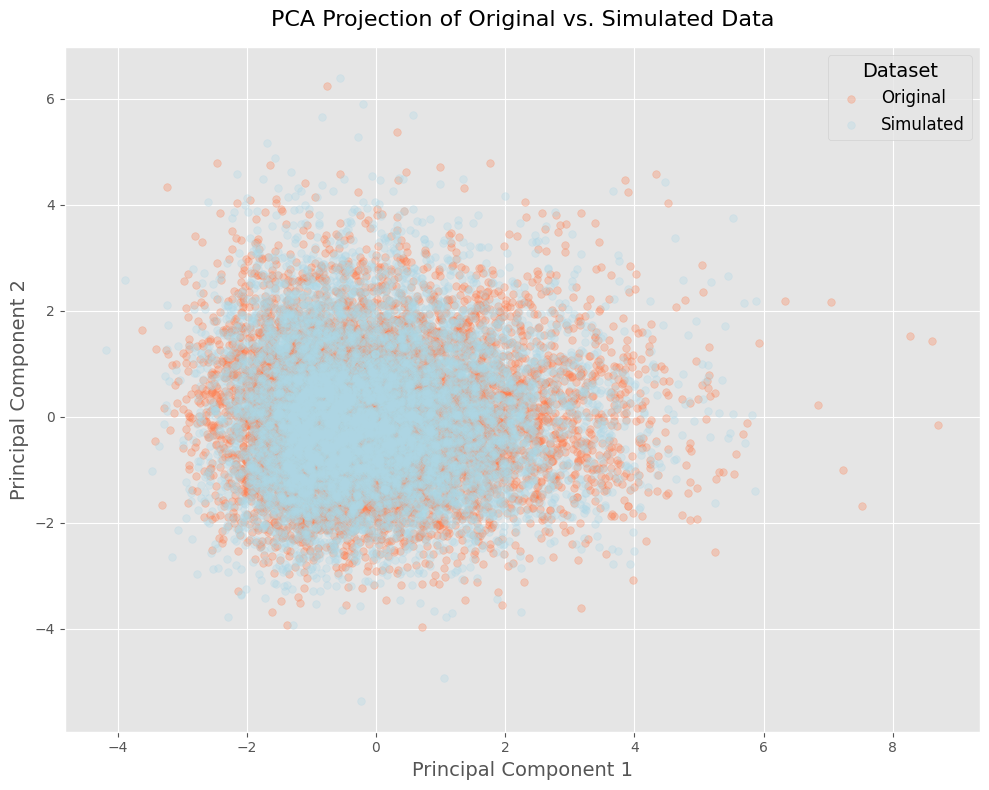

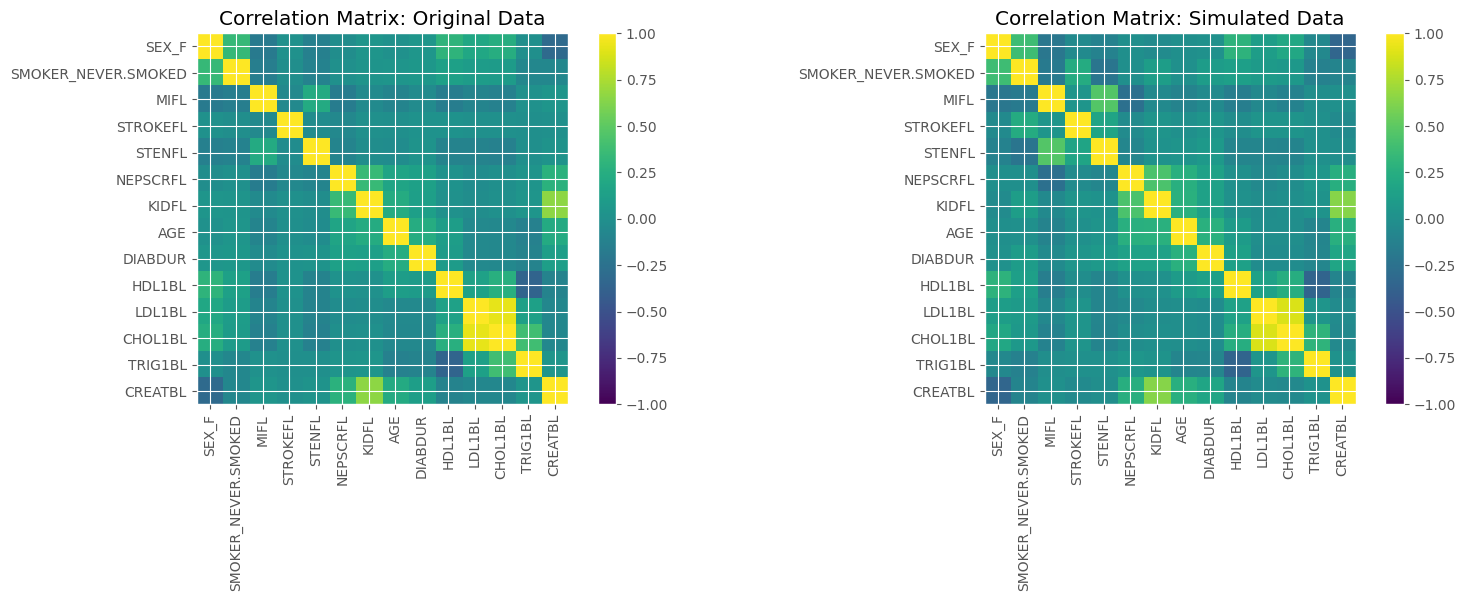

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.46      0.48      2619
           1       0.50      0.55      0.53      2619

    accuracy                           0.50      5238
   macro avg       0.50      0.50      0.50      5238
weighted avg       0.50      0.50      0.50      5238

Accuracy: 0.50
ROC AUC: 0.50


In [15]:
x,s_pred=model_bsl.sample_xz(sample_size=s_tensor.shape[0])

original_df = deepcopy(df_bsl_norm)
simulated_df = pd.DataFrame(s_pred.numpy())
simulated_df.columns = original_df.columns
original_df ['source'] = 'original'
simulated_df['source'] = 'simulated'
# original_df.drop(columns={'USUBJID'},inplace=True)
combined_df = pd.concat([original_df, simulated_df], ignore_index=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

original_df['source'] = 'Original'
simulated_df['source'] = 'Simulated'

combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
features = combined_df.drop(columns='source')
labels = combined_df['source']

# --- PCA Transformation ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['source'] = labels.values

style = 'seaborn' if 'seaborn' in plt.style.available else 'ggplot'
plt.style.use(style)

fig, ax = plt.subplots(figsize=(10, 8))


colors = {'Original': 'coral', 'Simulated': 'lightblue'}

for group in pca_df['source'].unique():
    group_data = pca_df[pca_df['source'] == group]
    ax.scatter(group_data['PC1'], group_data['PC2'],
               s=30, alpha=0.3, label=group, color=colors[group])

ax.set_title('PCA Projection of Original vs. Simulated Data', fontsize=16, pad=15)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)

ax.legend(title='Dataset', fontsize=12, title_fontsize=14, loc='best')

plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ---------------------------
# 1. Population Summary Comparison
# ---------------------------
# Compute mean values for each covariate
original_df.drop(columns={'source'},inplace=True)
simulated_df.drop(columns={'source'},inplace=True)
mean_original = original_df.mean()
mean_simulated = simulated_df.mean()

# Create a grouped bar chart comparing means
x = np.arange(len(mean_original))  # positions for each covariate
width = 0.35  # width of the bars

# plt.style.use('ggplot')  # Use a beautiful built-in style
# fig, ax = plt.subplots(figsize=(12, 6))
# rects1 = ax.bar(x - width/2, mean_original, width, label='Original')
# rects2 = ax.bar(x + width/2, mean_simulated, width, label='Simulated')

# ax.set_xticks(x)
# ax.set_xticklabels(original_df.columns, rotation=45, ha='right')
# ax.set_ylabel('Mean Value')
# ax.set_title('Comparison of Mean Values by Covariate')
# ax.legend()
# plt.tight_layout()
# plt.show()


corr_original = original_df.corr()
corr_simulated = simulated_df.corr()

# Create two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for original data
im0 = axes[0].imshow(corr_original, cmap='viridis', vmin=-1, vmax=1)
axes[0].set_title('Correlation Matrix: Original Data')
axes[0].set_xticks(np.arange(len(corr_original.columns)))
axes[0].set_xticklabels(corr_original.columns, rotation=90)
axes[0].set_yticks(np.arange(len(corr_original.columns)))
axes[0].set_yticklabels(corr_original.columns)
plt.colorbar(im0, ax=axes[0])

# Heatmap for simulated data
im1 = axes[1].imshow(corr_simulated, cmap='viridis', vmin=-1, vmax=1)
axes[1].set_title('Correlation Matrix: Simulated Data')
axes[1].set_xticks(np.arange(len(corr_simulated.columns)))
axes[1].set_xticklabels(corr_simulated.columns, rotation=90)
axes[1].set_yticks(np.arange(len(corr_simulated.columns)))
axes[1].set_yticklabels(corr_simulated.columns)
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


orig = original_df.copy()
sim = simulated_df.copy()

orig['label'] = 0
sim['label'] = 1

# Combine the datasets
combined_df = pd.concat([orig, sim], ignore_index=True)

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into training and testing sets (stratified to maintain label balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Get predictions and predicted probabilities for AUC calculation
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC: {:.2f}".format(auc))

# If the two datasets are very similar, even a strong classifier should perform poorly
# (accuracy near 50% and AUC near 0.5), indicating that it is difficult to tell them apart.


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

# ... (build combined_df with 'label' as before) ...

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Train a Random Forest classifier
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# Predictions and probabilities
y_pred      = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
auc      = roc_auc_score(y_test, y_pred_proba)
report   = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC:  {auc:.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78      2619
           1       0.79      0.74      0.76      2619

    accuracy                           0.77      5238
   macro avg       0.77      0.77      0.77      5238
weighted avg       0.77      0.77      0.77      5238

Accuracy: 0.77
ROC AUC:  0.85


In [21]:
clf.feature_importances_

array([0.01372633, 0.01645811, 0.01619363, 0.01416053, 0.01794318,
       0.01685676, 0.01023794, 0.17167782, 0.12871116, 0.1194332 ,
       0.11493902, 0.11288888, 0.11881706, 0.12795639])

In [17]:
orig.describe()

,SEX_F,SMOKER_NEVER.SMOKED,MIFL,STROKEFL,STENFL,NEPSCRFL,KIDFL,AGE,DIABDUR,HDL1BL,LDL1BL,CHOL1BL,TRIG1BL,CREATBL,label
count,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8730.0
mean,0.362428,0.415006,0.306529,0.162199,0.256586,0.389118,0.218442,3.684974e-16,2.315572e-16,-4.989263e-16,-1.397889e-16,-1.815018e-16,2.559744e-16,-3.418419e-17,0.0
std,0.480729,0.492751,0.461079,0.368655,0.436774,0.487578,0.413213,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.131642e+00,-1.603052e+00,-2.900511e+00,-2.443710e+00,-2.435864e+00,-1.662750e+00,-2.536490e+00,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.924512e-01,-7.296927e-01,-6.966079e-01,-7.220590e-01,-7.185683e-01,-6.903835e-01,-7.027698e-01,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.274566e-02,-1.727681e-01,-1.298900e-01,-1.553042e-01,-1.461365e-01,-2.524819e-01,-1.730283e-01,0.0
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,6.668863e-01,5.487024e-01,5.312809e-01,5.504659e-01,5.694032e-01,3.942650e-01,5.604598e-01,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.325488e+00,6.117948e+00,8.843144e+00,6.303562e+00,6.016449e+00,5.406554e+00,3.168418e+00,0.0


In [18]:
sim.describe()

,SEX_F,SMOKER_NEVER.SMOKED,MIFL,STROKEFL,STENFL,NEPSCRFL,KIDFL,AGE,DIABDUR,HDL1BL,LDL1BL,CHOL1BL,TRIG1BL,CREATBL,label
count,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.0
mean,0.360596,0.410080,0.299084,0.153952,0.246735,0.390263,0.210309,0.029177,-0.002137,0.007159,-0.018237,-0.017801,-0.017400,-0.012947,1.0
std,0.480183,0.491891,0.457902,0.360915,0.431136,0.487854,0.407549,1.012935,1.068387,1.030709,0.988512,0.959847,0.969663,1.092608,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.337465,-3.199620,-2.825363,-3.027322,-2.866251,-2.590148,-3.032987,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.674399,-0.733284,-0.693652,-0.692204,-0.700163,-0.665316,-0.785857,1.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.015298,-0.157239,-0.141304,-0.149250,-0.127286,-0.253183,-0.178140,1.0
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.684153,0.580248,0.550324,0.556774,0.548060,0.404013,0.614204,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.011827,5.960225,6.371464,4.648691,5.116522,6.025608,6.467320,1.0


In [298]:
model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=3, T=11, s_dim = s_tensor.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=40000, lr=1e-3, print_every_iter=1000,reg_lambda=1)
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=40000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 44393013248.0000,	loss_y 1.6444, 1.6540, 0.0193,	loss_eta 8.8641, 10.6009, 3.4735, 	marginal_loss 44393013248.0000
Epoch 1: y_sample_mean 0.01303759217262268
Epoch 1: y_sample1_cat.float().mean() 0.49785760045051575
Epoch 1000: loss 27.0920,	loss_y 0.1687, 0.1955, 0.0537,	loss_eta 21.6492, 43.2881, 43.2777, 	marginal_loss 5.2741
Epoch 1000: y_sample_mean 0.012798083946108818
Epoch 1000: y_sample1_cat.float().mean() 0.013082800433039665
Epoch 2000: loss 26.5003,	loss_y 0.1631, 0.1972, 0.0683,	loss_eta 21.1445, 44.9365, 47.5839, 	marginal_loss 5.1927
Epoch 2000: y_sample_mean 0.012995938770473003
Epoch 2000: y_sample1_cat.float().mean() 0.012396208941936493
Epoch 3000: loss 26.1967,	loss_y 0.1594, 0.2021, 0.0853,	loss_eta 21.0123, 45.6888, 49.3530, 	marginal_loss 5.0249
Epoch 3000: y_sample_mean 0.013027179054915905
Epoch 3000: y_sample1_cat.float().mean() 0.012687085196375847
Epoch 4000: loss 26.1896,	loss_y 0.1560, 0.2076, 0.1031,	loss_eta 21.0734, 46.1031, 50.0593, 	marg

In [315]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=10000, lr=1e-3, print_every_iter=1000,reg_lambda=1)
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=10000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 2.3354,	loss_y 0.0467, 0.0859, 0.0785,	loss_eta 2.2780, 5.0500, 5.5440, 	marginal_loss 0.0107
Epoch 1: y_sample_mean 0.012860564514994621
Epoch 1: y_sample1_cat.float().mean() 0.012938282452523708
Epoch 1000: loss 2.3340,	loss_y 0.0456, 0.0845, 0.0777,	loss_eta 2.2827, 5.0892, 5.6131, 	marginal_loss 0.0057
Epoch 1000: y_sample_mean 0.012975111603736877
Epoch 1000: y_sample1_cat.float().mean() 0.012868915684521198
Epoch 2000: loss 2.3286,	loss_y 0.0448, 0.0809, 0.0723,	loss_eta 2.2791, 5.1140, 5.6697, 	marginal_loss 0.0047
Epoch 2000: y_sample_mean 0.012818911112844944
Epoch 2000: y_sample1_cat.float().mean() 0.01274849846959114
Epoch 3000: loss 2.3389,	loss_y 0.0436, 0.0795, 0.0716,	loss_eta 2.2882, 5.1105, 5.6446, 	marginal_loss 0.0071
Epoch 3000: y_sample_mean 0.012777256779372692
Epoch 3000: y_sample1_cat.float().mean() 0.012587935663759708
Epoch 4000: loss 2.3322,	loss_y 0.0441, 0.0797, 0.0711,	loss_eta 2.2844, 5.1207, 5.6725, 	marginal_loss 0.0036
Epoch 4000: y_sampl

In [319]:
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=30000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 11.2640, loss1 22.5243, loss2 22.5205
Epoch 1000: loss 11.2571, loss1 22.5827, loss2 22.6512
Epoch 2000: loss 11.3453, loss1 22.3152, loss2 21.9397
Epoch 3000: loss 11.1748, loss1 22.4317, loss2 22.5137
Epoch 4000: loss 11.1733, loss1 22.2556, loss2 22.1646
Epoch 5000: loss 11.2302, loss1 22.6510, loss2 22.8416
Epoch 6000: loss 11.1082, loss1 22.3019, loss2 22.3875
Epoch 7000: loss 11.1198, loss1 22.3615, loss2 22.4835
Epoch 8000: loss 11.1301, loss1 22.3460, loss2 22.4318
Epoch 9000: loss 11.2664, loss1 22.3637, loss2 22.1946
Epoch 10000: loss 11.0954, loss1 22.1839, loss2 22.1769
Epoch 11000: loss 11.0358, loss1 21.8564, loss2 21.6411
Epoch 12000: loss 11.0258, loss1 22.2297, loss2 22.4077
Epoch 13000: loss 11.0208, loss1 21.9318, loss2 21.8221
Epoch 14000: loss 10.9757, loss1 22.2359, loss2 22.5204
Epoch 15000: loss 11.0480, loss1 22.0948, loss2 22.0936
Epoch 16000: loss 10.9195, loss1 21.9943, loss2 22.1496
Epoch 17000: loss 10.9516, loss1 21.7475, loss2 21.5919
Epoch

In [322]:
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=30000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 10.7481, loss1 21.8261, loss2 22.1561
Epoch 1000: loss 10.7634, loss1 21.5932, loss2 21.6596
Epoch 2000: loss 10.7963, loss1 21.5729, loss2 21.5532
Epoch 3000: loss 10.6479, loss1 21.2389, loss2 21.1822
Epoch 4000: loss 10.7308, loss1 21.4978, loss2 21.5342
Epoch 5000: loss 10.6670, loss1 21.2915, loss2 21.2489
Epoch 6000: loss 10.7688, loss1 21.5447, loss2 21.5520
Epoch 7000: loss 10.7550, loss1 21.4296, loss2 21.3494
Epoch 8000: loss 10.7416, loss1 21.3961, loss2 21.3089
Epoch 9000: loss 10.6298, loss1 21.2617, loss2 21.2638
Epoch 10000: loss 10.6020, loss1 21.3176, loss2 21.4313
Epoch 11000: loss 10.6595, loss1 21.6390, loss2 21.9590
Epoch 12000: loss 10.5770, loss1 21.2001, loss2 21.2460
Epoch 13000: loss 10.5889, loss1 21.6532, loss2 22.1286
Epoch 14000: loss 10.5475, loss1 21.2995, loss2 21.5040
Epoch 15000: loss 10.5987, loss1 20.9140, loss2 20.6306
Epoch 16000: loss 10.6473, loss1 21.1635, loss2 21.0324
Epoch 17000: loss 10.4989, loss1 21.1138, loss2 21.2297
Epoch

In [323]:
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=30000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 10.4176, loss1 21.0915, loss2 21.3477
Epoch 1000: loss 10.4529, loss1 20.9178, loss2 20.9297
Epoch 2000: loss 10.5767, loss1 21.0010, loss2 20.8486
Epoch 3000: loss 10.4169, loss1 20.9623, loss2 21.0907
Epoch 4000: loss 10.4347, loss1 21.1310, loss2 21.3926
Epoch 5000: loss 10.4622, loss1 21.0552, loss2 21.1860
Epoch 6000: loss 10.4593, loss1 20.8683, loss2 20.8180
Epoch 7000: loss 10.3651, loss1 20.5038, loss2 20.2775
Epoch 8000: loss 10.4199, loss1 21.0781, loss2 21.3163
Epoch 9000: loss 10.3555, loss1 20.8231, loss2 20.9352
Epoch 10000: loss 10.3727, loss1 20.4819, loss2 20.2186
Epoch 11000: loss 10.5200, loss1 20.9845, loss2 20.9290
Epoch 12000: loss 10.3615, loss1 20.9218, loss2 21.1207
Epoch 13000: loss 10.3810, loss1 20.6387, loss2 20.5155
Epoch 14000: loss 10.3068, loss1 20.7085, loss2 20.8034
Epoch 15000: loss 10.3899, loss1 20.9392, loss2 21.0987
Epoch 16000: loss 10.3225, loss1 20.4228, loss2 20.2006
Epoch 17000: loss 10.3341, loss1 20.7717, loss2 20.8752
Epoch

In [22]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# --------------------------------------------------------------------
# Helper: Missing imputation function (as you already defined)
def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    y_out = y.clone() 
    event_indicator = (y_out > 0).float()
    c = torch.cumsum(event_indicator, dim=1)
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    mask = (c_shifted > 0)
    y_out[mask] = missing_to_num

    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape  
    x_out = None
    if x is not None:
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        x_out[mask_expanded] = missing_to_num
        x_out = x_out.view(n_obs, timesteps * x_dim)

    z_out = None
    if z is not None:
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        z_out[mask_expanded] = missing_to_num
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out

# --------------------------------------------------------------------
# Define overall time grid (11 time points) and the observed indices for z2 and z3.
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]  # indices 0,...,10
# Given original measurement times for z2 and z3: 0, 12, 24, 36, 48, 6, 60,
# sort them into increasing order: 0, 6, 12, 24, 36, 48, 60.
# The corresponding indices in the overall time grid are:
observed_idx = [0, 1, 2, 4, 6, 8, 10]

# --------------------------------------------------------------------
# --- Preprocessing the True (Original) Joint Data ---
# Here we assume that the function missing_impute has already been applied to your original tensors.
# x_tensor, z_tensor, y_tensor, and s_tensor are assumed to exist.
# Note: z_tensor is assumed to be of shape (n_obs, 33); it stacks z1, z2, and z3, each across 11 time points.

# Apply the missing imputation to the original tensors
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Convert true tensors to numpy arrays for DataFrame creation
s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, 11)

# Reshape z_tensor to (n_obs, 11, 3)
n_obs = z_tensor.shape[0]
z_true_reshaped = z_tensor.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
# Extract z1: use all 11 time points
z1_true = z_true_reshaped[:, :, 0]              # shape: (n_obs, 11)
# For z2 and z3: extract only the observed indices
z2_true = z_true_reshaped[:, observed_idx, 1]     # shape: (n_obs, len(observed_idx))
z3_true = z_true_reshaped[:, observed_idx, 2]     # shape: (n_obs, len(observed_idx))

# Create column names for each block of features.
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_{t}' for t in time_points]  # all time points for z1
y_cols  = [f'y_{t}' for t in time_points]
z2_cols = [f'z2_{time_points[i]}' for i in observed_idx]
z3_cols = [f'z3_{time_points[i]}' for i in observed_idx]

# Build the original (true) joint DataFrame by concatenating the features along the columns.
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true, y_true_np, z2_true, z3_true], axis=1),
    columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
)
original_joint_df['source'] = 'Original'

# --------------------------------------------------------------------
# --- Simulation Loop ---
num_simulations = 100  
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample from the baseline model to get new s (and x if needed)
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Sample joint predictions from your main model using the simulated baseline features s_pred
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply the missing imputation on simulated predictions.
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Convert simulated s, y into numpy arrays.
    s_pred_np = s_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    
    # Reshape simulated z_pred to (n_obs, 11, 3)
    z_pred_reshaped = z_pred.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
    # Extract the simulated z1 (all time points)
    z1_pred = z_pred_reshaped[:, :, 0]             
    # And for z2 and z3, take only the observed indices
    z2_pred = z_pred_reshaped[:, observed_idx, 1]
    z3_pred = z_pred_reshaped[:, observed_idx, 2]
    
    # Build the simulated joint DataFrame with the same feature ordering.
    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z1_pred, y_pred_np, z2_pred, z3_pred], axis=1),
        columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
    )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data.
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    combined_joint_df= combined_joint_df.round(1)
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into train and test sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=2025, stratify=y_joint
    )
    
    # Train the logistic regression classifier.
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set.
    y_joint_pred = clf_joint.predict(X_test)
    y_joint_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC.
    accuracy_joint = accuracy_score(y_test, y_joint_pred)
    auc_joint = roc_auc_score(y_test, y_joint_pred_proba)
    
    # Save the results.
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (over {} simulations):".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


Joint Data Classification Results (over 100 simulations):
Accuracy: Mean=0.971, Std=0.001, Min=0.968, Max=0.974
AUC: Mean=0.988, Std=0.000, Min=0.987, Max=0.989


In [33]:
clf_joint.coef_

array([[-0.193077  ,  0.03639264, -0.07746321, -0.08039948, -0.01333293,
        -0.09553334, -0.04328156,  0.02947346,  0.01818412, -0.04785383,
        -0.15893524,  0.18391914, -0.0489223 , -0.11804127,  0.03807719,
         0.09896489, -0.12553728, -0.15171976,  0.1825396 , -0.02764151,
        -0.21282585,  0.41462862, -0.39105674,  0.18414204, -0.03770923,
         0.        ,  0.01328205, -0.05277713,  0.10255567, -0.17343326,
         0.04127243,  0.29374973,  0.3353378 , -2.05585807, -0.19168194,
         1.85536157, -0.05896781, -0.12367834,  0.14314761, -0.00228283,
        -0.49566319,  0.51256927, -0.12497792, -0.05504896, -0.02655338,
         0.02197956,  0.16251387, -0.19221669,  0.31744698, -0.16447368]])

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# … (all your data‐loading, missing_impute, reshape, and original_joint_df creation) …

# --------------------------------------------------------------------
# --- Simulation Loop (with Random Forest) ---
num_simulations = 100  
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # (1) simulate baseline & joint as before
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)

    # (2) missing‐impute
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)

    # (3) build simulated_joint_df exactly as you did
    s_pred_np = s_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    z_pred_reshaped = z_pred.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
    z1_pred = z_pred_reshaped[:, :, 0]
    z2_pred = z_pred_reshaped[:, observed_idx, 1]
    z3_pred = z_pred_reshaped[:, observed_idx, 2]

    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z1_pred, y_pred_np, z2_pred, z3_pred], axis=1),
        columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
    )
    simulated_joint_df['source'] = 'Simulated'

    # (4) combine original & simulated
    combined = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True).round(1)
    X = combined.drop(columns='source')
    y = combined['source'].map({'Original': 0, 'Simulated': 1})

    # (5) train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=2025, stratify=y
    )

    # ===== HERE: Random Forest instead of Logistic Regression =====
    clf_joint = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=2025,
        n_jobs=-1
    )
    clf_joint.fit(X_train, y_train)

    y_pred_lbl   = clf_joint.predict(X_test)
    y_pred_proba = clf_joint.predict_proba(X_test)[:, 1]

    accuracy_list.append(accuracy_score(y_test, y_pred_lbl))
    auc_list     .append(roc_auc_score(y_test, y_pred_proba))

# --- Print Summary Statistics ---
print(f"Joint Data Classification Results over {num_simulations} sims:")
print(f"Accuracy: Mean={np.mean(accuracy_list):.3f}, Std={np.std(accuracy_list,ddof=1):.3f}, "
      f"Min={np.min(accuracy_list):.3f}, Max={np.max(accuracy_list):.3f}")
print(f"AUC:      Mean={np.mean(auc_list):.3f}, Std={np.std(auc_list,ddof=1):.3f}, "
      f"Min={np.min(auc_list):.3f}, Max={np.max(auc_list):.3f}")


Joint Data Classification Results over 100 sims:
Accuracy: Mean=0.917, Std=0.003, Min=0.910, Max=0.924
AUC:      Mean=0.975, Std=0.001, Min=0.972, Max=0.978


In [329]:
clf_joint.feature_importances_

array([0.00274183, 0.00265683, 0.00193446, 0.00193227, 0.00206905,
       0.0027001 , 0.00127404, 0.01827574, 0.02346555, 0.01499258,
       0.01623169, 0.01506546, 0.01897572, 0.01288765, 0.17808925,
       0.08667809, 0.10659704, 0.0524661 , 0.07053526, 0.03594191,
       0.02716308, 0.02844637, 0.01955407, 0.02672302, 0.01871019,
       0.        , 0.00018801, 0.00053489, 0.00044044, 0.00053793,
       0.00134187, 0.00086965, 0.0021005 , 0.0020232 , 0.00179823,
       0.00438287, 0.01563546, 0.01576894, 0.01427955, 0.01322136,
       0.01168923, 0.01376481, 0.01887588, 0.01808436, 0.01623379,
       0.0138146 , 0.01296677, 0.01168614, 0.0102854 , 0.01336878])

In [335]:
original_joint_df.iloc[:,14].describe()

count    8730.000000
mean        8.675659
std         1.512672
min         4.600000
25%         7.600000
50%         8.300000
75%         9.400000
max        18.500000
Name: z1_0, dtype: float64

In [337]:
simulated_joint_df.iloc[:,14].describe()

count    8730.000000
mean        8.667584
std         0.535829
min         6.607913
25%         8.294274
50%         8.636635
75%         8.998988
max        11.678518
Name: z1_0, dtype: float64

In [313]:
sum(y_tensor==1)

tensor([  0, 126, 167, 159, 174, 159, 153, 125,  77,  24,   4])

In [314]:
sum(y_pred==1)

tensor([  0,  59,  79, 109, 171, 124, 156,  68,  28,   1,   0])

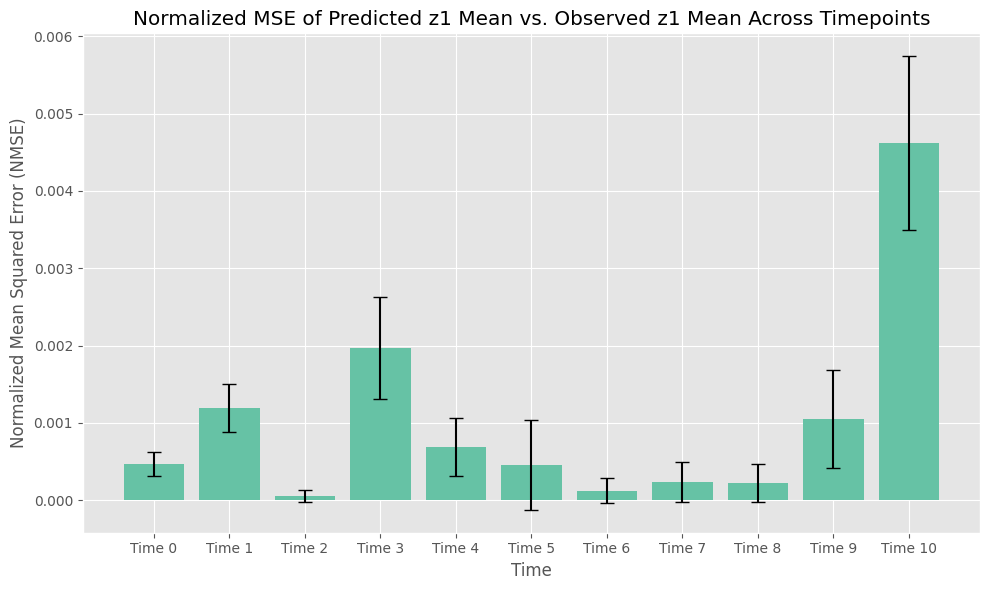

In [308]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
n_obs, total_dim = z_tensor.shape
timepoints = 11
z_dim = 3
num_samples = 500

x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)
# Reshape the observed z tensor: shape becomes (n_obs, timepoints, z_dim)
z_obs_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)
z1_obs = z_obs_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)

# Compute the observed mean and variance (using sample variance) across observations for each timepoint
z1_obs_mean = np.mean(z1_obs, axis=0)           # shape: (timepoints,)
z1_obs_var = np.var(z1_obs, axis=0, ddof=1)       # shape: (timepoints,)

# Initialize list to collect predictions for z1
z1_samples = []

# Generate predictions in each iteration
for _ in range(num_samples):
    # Sample new predictions each time
    _, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred, )
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Reshape predictions: (n_obs, timepoints, z_dim)
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)
    
    # Extract z1 and convert to numpy array
    z1_pred = z_pred_reshaped[:, :, 0].detach().cpu().numpy()
    z1_samples.append(z1_pred)

# Stack predicted samples to create an array of shape (num_samples, n_obs, timepoints)
z1_samples_array = np.stack(z1_samples, axis=0)

# For each predicted sample, compute its mean across observations (shape: (num_samples, timepoints))
z1_samples_mean = np.mean(z1_samples_array, axis=1)

# Calculate the squared errors for each sample and timepoint: (predicted mean - observed mean)^2
squared_errors = (z1_samples_mean - z1_obs_mean)**2

# Normalize squared errors by dividing by the variance at each timepoint
# This yields a normalized squared error for each sample and timepoint.
normalized_squared_errors = squared_errors / z1_obs_var

# For each timepoint, compute:
# - The mean normalized MSE across all samples
# - The standard deviation of the normalized MSE (to use as error bars)
nmse_mean = np.mean(normalized_squared_errors, axis=0)
nmse_std = np.std(normalized_squared_errors, axis=0, ddof=1)

# Create a bar plot with error bars
time = np.arange(timepoints)
plt.figure(figsize=(10, 6))
plt.bar(time, nmse_mean, yerr=nmse_std, capsize=5, color=sns.color_palette("Set2")[0])
plt.xlabel("Time")
plt.ylabel("Normalized Mean Squared Error (NMSE)")
plt.title("Normalized MSE of Predicted z1 Mean vs. Observed z1 Mean Across Timepoints")
plt.xticks(time, [f"Time {t}" for t in time])
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
n_obs, total_dim = z_tensor.shape
timepoints = 11
z_dim = 3
num_samples = 500

x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)
# Reshape the observed z tensor: shape becomes (n_obs, timepoints, z_dim)
z_obs_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)
z1_obs = z_obs_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)

# Compute the observed mean and variance (using sample variance) across observations for each timepoint
z1_obs_mean = np.mean(z1_obs, axis=0)           # shape: (timepoints,)
z1_obs_var = np.var(z1_obs, axis=0, ddof=1)       # shape: (timepoints,)

# Initialize list to collect predictions for z1
z1_samples = []

# Generate predictions in each iteration
for _ in range(num_samples):
    # Sample new predictions each time
    _, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Reshape predictions: (n_obs, timepoints, z_dim)
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)
    
    # Extract z1 and convert to numpy array
    z1_pred = z_pred_reshaped[:, :, 0].detach().cpu().numpy()
    z1_samples.append(z1_pred)

# Stack predicted samples to create an array of shape (num_samples, n_obs, timepoints)
z1_samples_array = np.stack(z1_samples, axis=0)

# For each predicted sample, compute its mean across observations (shape: (num_samples, timepoints))
z1_samples_mean = np.mean(z1_samples_array, axis=1)

# Calculate the squared errors for each sample and timepoint: (predicted mean - observed mean)^2
squared_errors = (z1_samples_mean - z1_obs_mean)**2

# Normalize squared errors by dividing by the variance at each timepoint
# This yields a normalized squared error for each sample and timepoint.
normalized_squared_errors = squared_errors / z1_obs_var

# For each timepoint, compute:
# - The mean normalized MSE across all samples
# - The standard deviation of the normalized MSE (to use as error bars)
nmse_mean = np.mean(normalized_squared_errors, axis=0)
nmse_std = np.std(normalized_squared_errors, axis=0, ddof=1)

# Create a bar plot with error bars
time = np.arange(timepoints)
plt.figure(figsize=(10, 6))
plt.bar(time, nmse_mean, yerr=nmse_std, capsize=5, color=sns.color_palette("Set2")[0])
plt.xlabel("Time")
plt.ylabel("Normalized Mean Squared Error (NMSE)")
plt.title("Normalized MSE of Predicted z1 Mean vs. Observed z1 Mean Across Timepoints")
plt.xticks(time, [f"Time {t}" for t in time])
plt.tight_layout()
plt.show()


## standardize z

In [68]:
import pandas as pd
import numpy as np
import torch
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# ------------------------- Load Your Data -------------------------
df_z1 = deepcopy(df_hba1c)   # longitudinal covariate z1
df_z2 = deepcopy(df_egfr)    # longitudinal covariate z2
df_z3 = deepcopy(df_bmi)     # longitudinal covariate z3
df_bsl = deepcopy(df_bsl_read)    # baseline covariates
df_Y = deepcopy(df_Y_read)        # outcome
df_bsl.dropna(inplace=True)
df_bsl.drop(df_bsl[(df_bsl['TRIG1BL'] > 8) | (df_bsl['CREATBL'] > 160)].index, inplace=True)



# --------------------- Process df_Y (Outcome) ---------------------
# Ensure Y0 exists and select Y0 to Y10.
if 'Y0' not in df_Y.columns:
    df_Y.insert(1, 'Y0', 0.0)
df_Y = df_Y[['USUBJID'] + [f'Y{i}' for i in range(0, 11)]]

# ----------------- Time Points You Care About ---------------------
# (These are the actual numeric time values corresponding to Y0 ... Y10.)
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]

def process_longitudinal(df, time_points):
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points if str(tp) in df.columns]].copy()
    for tp in time_points:
        col = str(tp)
        if col not in df.columns:
            df.loc[:, col] = np.nan
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points]]

    df['na_count'] = df.isna().sum(axis=1)
    df = df.loc[df['na_count'] <= 5].drop(columns='na_count').reset_index(drop=True)

    for idx in range(len(df)):
        for t_idx, t in enumerate(time_points):
            col = str(t)
            if pd.isna(df.loc[idx, col]):
                for prev_t in reversed(time_points[:t_idx]):
                    prev_col = str(prev_t)
                    if not pd.isna(df.loc[idx, prev_col]):
                        df.loc[idx, col] = df.loc[idx, prev_col]
                        break

    return df

# ------------- Process and Clean z1, z2, z3 ----------------
df_z1_clean = process_longitudinal(df_z1, time_points)
df_z2_clean = process_longitudinal(df_z2, time_points)
df_z3_clean = process_longitudinal(df_z3, time_points)


df_z1_clean = df_z1_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z2_clean = df_z2_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z3_clean = df_z3_clean.dropna(axis=0, how='any').reset_index(drop=True)

# ------------ Align All by Intersection of USUBJID -------------
common_ids = (set(df_Y['USUBJID']) 
              & set(df_z1_clean['USUBJID']) 
              & set(df_z2_clean['USUBJID']) 
              & set(df_z3_clean['USUBJID']) 
              & set(df_bsl['USUBJID']))
df_Y = df_Y[df_Y['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z1_clean = df_z1_clean[df_z1_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z2_clean = df_z2_clean[df_z2_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z3_clean = df_z3_clean[df_z3_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_bsl = df_bsl[df_bsl['USUBJID'].isin(common_ids)].reset_index(drop=True)


for D in (df_Y, df_z1_clean, df_z2_clean, df_z3_clean, df_bsl):
    D.sort_values('USUBJID', inplace=True)
    D.reset_index(drop=True, inplace=True)

cols = [str(tp) for tp in time_points]

for df in (df_z1_clean, df_z2_clean, df_z3_clean):
    # compute per-column mean & std, skipping NaNs
    means = df[cols].mean(skipna=True)
    stds  = df[cols].std(skipna=True)

    # subtract mean, divide by std; NaNs remain NaN
    df[cols] = (df[cols] - means) / stds

# ----------------- Build the Z torch tensor (longitudinal) ----------------------

Z_list = []
for idx in range(len(df_z1_clean)):
    z1_vals = df_z1_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z2_vals = df_z2_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z3_vals = df_z3_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values

    Z_subj = np.column_stack([z1_vals, z2_vals, z3_vals]).reshape(-1)
    Z_list.append(Z_subj.astype(np.float32))

z_tensor = torch.tensor(np.vstack(Z_list), dtype=torch.float32)  # Shape (n_subjects, len(time_points))
# ----------------- Build the X tensor (ARM repeated over time) -------------------
# Pull ARM values from df_bsl; assume 'ARM' is a column.
arm_values = df_bsl['ARM'].astype(float).values  # shape (n_subjects,)
x_tensor = torch.tensor(np.repeat(arm_values[:, np.newaxis], len(time_points), axis=1), dtype=torch.int32)
# ------------------ Build the y torch tensor ----------------------
y_cols = [f'Y{i}' for i in range(0, 11)]
y_np = df_Y[y_cols].astype(float).values  # Ensure it's float so that NaN is preserved
y_tensor = torch.tensor(y_np, dtype=torch.int32)
# ----------------- Build the S tensor (baseline features) -------------------
df_bsl_features = df_bsl.drop(columns=['USUBJID','ARM',  
    'RACE_AMERICAN.INDIAN.OR.ALASKA.NATIVE',
    'RACE_NATIVE.HAWAIIAN.OR.OTHER.PACIFIC.ISLANDER',
    'RACE_OTHER',
    'RACE_ASIAN',
    'RACE_BLACK.OR.AFRICAN.AMERICAN',"HBA1CBL","BMIBL", 'SMOKER_CURRENT.SMOKER',
    "STROKEFL",	
     'KIDFL',
      'MIFL',	
    # "STENFL",
    # #"AGE", 
    # "DIABDUR",
    #"HDL1BL",	"LDL1BL",	
    # "CHOL1BL",	
    #"TRIG1BL", 
    # "CREATBL"
    ])

binary_cols     = ['SEX_F', 'SMOKER_NEVER.SMOKED',"STENFL",'NEPSCRFL'] 
continuous_cols = [c for c in df_bsl_features.columns
                   if c not in binary_cols]

# 2. Scale the continuous ones to zero‑mean, unit‑variance
scaler = StandardScaler()
df_bsl_cont = pd.DataFrame(
    scaler.fit_transform(df_bsl[continuous_cols]),
    columns=continuous_cols,
    index=df_bsl.index
)

df_bsl_norm = pd.concat([df_bsl_features[binary_cols],df_bsl_cont], axis=1)

df_bsl_features = df_bsl_features.astype(float)
x_bsl_tensor = torch.tensor(df_bsl['ARM'].values, dtype=torch.int32).view(-1, 1)
# s_tensor = torch.tensor(df_bsl_features.values, dtype=torch.float32)
s_tensor = torch.tensor(df_bsl_norm.astype(float).values, dtype=torch.float32)

# ----------------- Check shape -------------------
print(f"s_tensor shape: {s_tensor.shape}")  # (n_subjects, num_baseline_features)
print(f"z_tensor shape: {z_tensor.shape}")  # (n_subjects, {len(time_points)}) 
print(f"x_tensor shape (ARM): {x_tensor.shape}")  # (n_subjects, 11)
print(f"y_tensor shape: {y_tensor.shape}")  # (n_subjects, 11)

# Optional: Sanity check USUBJID order alignment.
print(np.all(df_Y['USUBJID'].values == df_z1_clean['USUBJID'].values))
print(np.all(df_Y['USUBJID'].values == df_bsl['USUBJID'].values))
print(torch.isnan(y_tensor).any())  # Returns True if any NaN exists

# Optional: Count the number of 1's in a DataFrame.
# For example, to count total number of 1s in df_Y (excluding the USUBJID column):
ones_count = (df_Y.drop(columns=['USUBJID']) == 1).sum().sum()
print("Total number of 1s in df_Y:", ones_count)


s_tensor shape: torch.Size([8730, 11])
z_tensor shape: torch.Size([8730, 33])
x_tensor shape (ARM): torch.Size([8730, 11])
y_tensor shape: torch.Size([8730, 11])
True
True
tensor(False)
Total number of 1s in df_Y: 1168


In [10]:
p = s_tensor.shape[1]
print(f'number of covariates: {p}')
binary_intervention = True


model_bsl = Frengression(x_bsl_tensor.shape[1], y_tensor.shape[1], s_tensor.shape[1], noise_dim=20, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention, z_binary_dims=4)
model_bsl.train_xz(x_bsl_tensor, s_tensor, num_iters=15000, lr=1e-3, print_every_iter=1000)

number of covariates: 11
Epoch 1: loss 2.6232, loss1 2.7550, loss2 0.2636
Epoch 1000: loss 1.9240, loss1 3.8296, loss2 3.8112
Epoch 2000: loss 1.9410, loss1 3.8532, loss2 3.8245
Epoch 3000: loss 1.9292, loss1 3.8522, loss2 3.8461
Epoch 4000: loss 1.9304, loss1 3.8486, loss2 3.8363
Epoch 5000: loss 1.9274, loss1 3.8717, loss2 3.8886
Epoch 6000: loss 1.9296, loss1 3.8650, loss2 3.8709
Epoch 7000: loss 1.9284, loss1 3.8460, loss2 3.8351
Epoch 8000: loss 1.9253, loss1 3.8438, loss2 3.8370
Epoch 9000: loss 1.9285, loss1 3.8604, loss2 3.8637
Epoch 10000: loss 1.9218, loss1 3.8511, loss2 3.8587
Epoch 11000: loss 1.9340, loss1 3.8630, loss2 3.8581
Epoch 12000: loss 1.9311, loss1 3.8743, loss2 3.8864
Epoch 13000: loss 1.9301, loss1 3.8625, loss2 3.8648
Epoch 14000: loss 1.9276, loss1 3.8508, loss2 3.8464
Epoch 15000: loss 1.9242, loss1 3.8442, loss2 3.8400


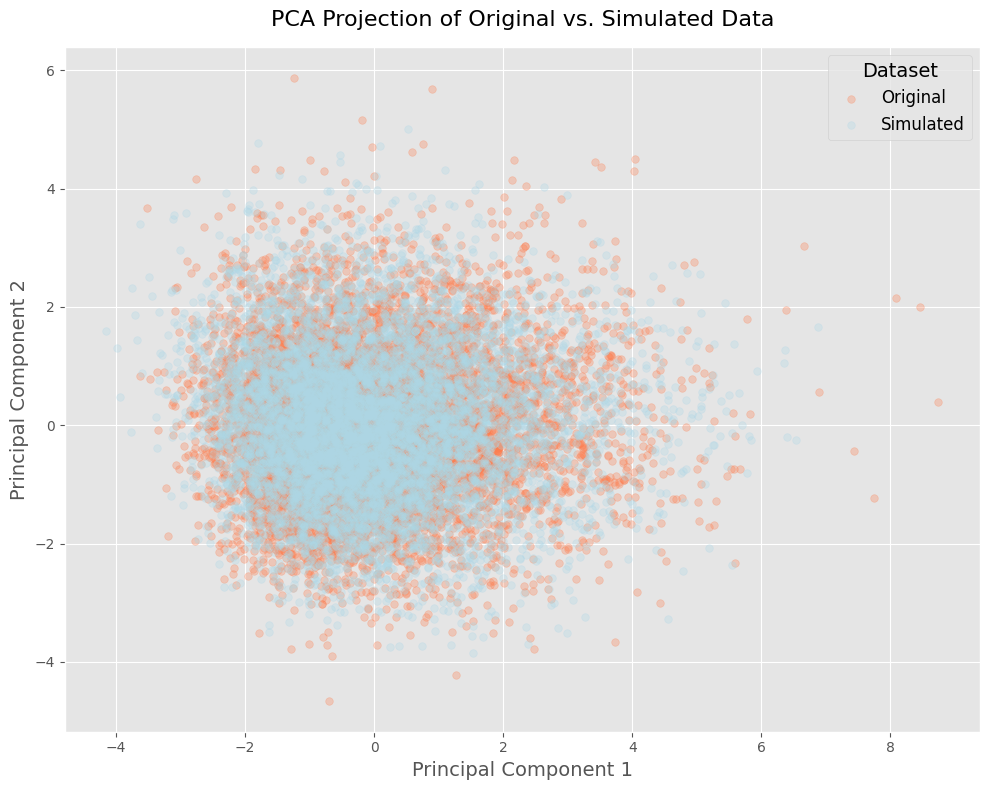

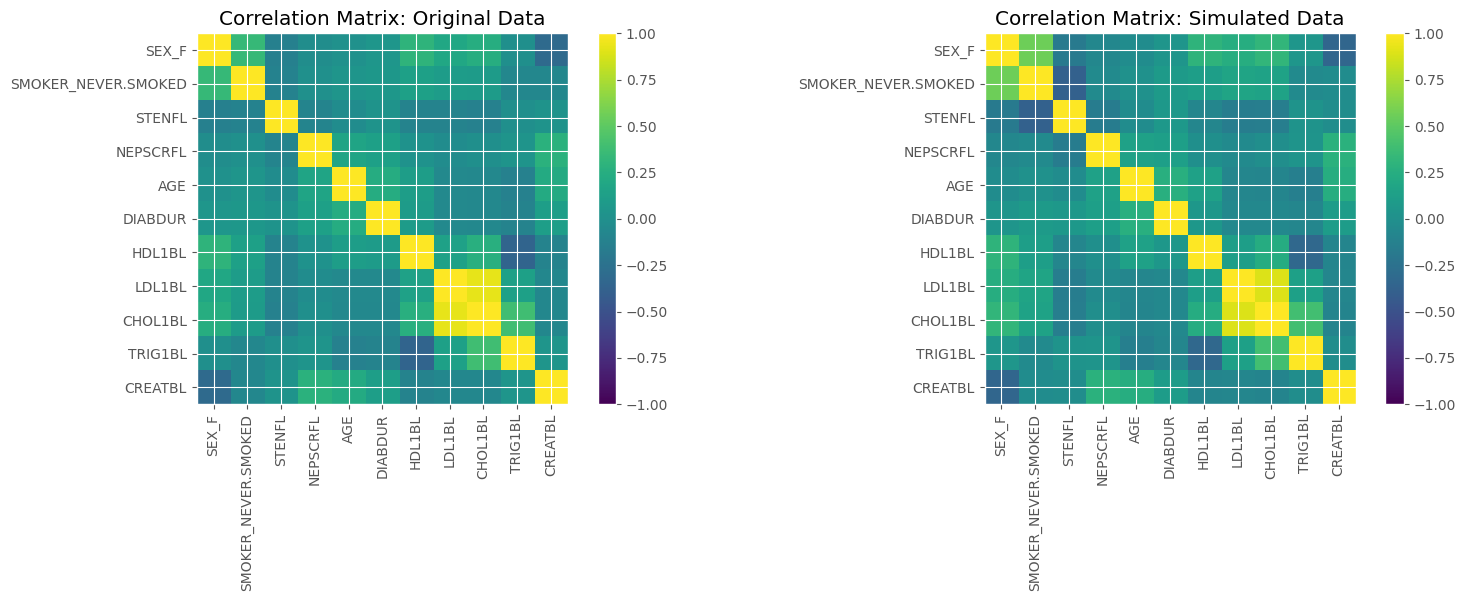

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.45      0.46      2619
           1       0.47      0.50      0.49      2619

    accuracy                           0.47      5238
   macro avg       0.47      0.47      0.47      5238
weighted avg       0.47      0.47      0.47      5238

Accuracy: 0.47
ROC AUC: 0.48


In [11]:
x,s_pred=model_bsl.sample_xz(sample_size=s_tensor.shape[0])

original_df = deepcopy(df_bsl_norm)
simulated_df = pd.DataFrame(s_pred.numpy())
simulated_df.columns = original_df.columns
original_df ['source'] = 'original'
simulated_df['source'] = 'simulated'
# original_df.drop(columns={'USUBJID'},inplace=True)
combined_df = pd.concat([original_df, simulated_df], ignore_index=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

original_df['source'] = 'Original'
simulated_df['source'] = 'Simulated'

combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
features = combined_df.drop(columns='source')
labels = combined_df['source']

# --- PCA Transformation ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['source'] = labels.values

style = 'seaborn' if 'seaborn' in plt.style.available else 'ggplot'
plt.style.use(style)

fig, ax = plt.subplots(figsize=(10, 8))


colors = {'Original': 'coral', 'Simulated': 'lightblue'}

for group in pca_df['source'].unique():
    group_data = pca_df[pca_df['source'] == group]
    ax.scatter(group_data['PC1'], group_data['PC2'],
               s=30, alpha=0.3, label=group, color=colors[group])

ax.set_title('PCA Projection of Original vs. Simulated Data', fontsize=16, pad=15)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)

ax.legend(title='Dataset', fontsize=12, title_fontsize=14, loc='best')

plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ---------------------------
# 1. Population Summary Comparison
# ---------------------------
# Compute mean values for each covariate
original_df.drop(columns={'source'},inplace=True)
simulated_df.drop(columns={'source'},inplace=True)
mean_original = original_df.mean()
mean_simulated = simulated_df.mean()

# Create a grouped bar chart comparing means
x = np.arange(len(mean_original))  # positions for each covariate
width = 0.35  # width of the bars

# plt.style.use('ggplot')  # Use a beautiful built-in style
# fig, ax = plt.subplots(figsize=(12, 6))
# rects1 = ax.bar(x - width/2, mean_original, width, label='Original')
# rects2 = ax.bar(x + width/2, mean_simulated, width, label='Simulated')

# ax.set_xticks(x)
# ax.set_xticklabels(original_df.columns, rotation=45, ha='right')
# ax.set_ylabel('Mean Value')
# ax.set_title('Comparison of Mean Values by Covariate')
# ax.legend()
# plt.tight_layout()
# plt.show()


corr_original = original_df.corr()
corr_simulated = simulated_df.corr()

# Create two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for original data
im0 = axes[0].imshow(corr_original, cmap='viridis', vmin=-1, vmax=1)
axes[0].set_title('Correlation Matrix: Original Data')
axes[0].set_xticks(np.arange(len(corr_original.columns)))
axes[0].set_xticklabels(corr_original.columns, rotation=90)
axes[0].set_yticks(np.arange(len(corr_original.columns)))
axes[0].set_yticklabels(corr_original.columns)
plt.colorbar(im0, ax=axes[0])

# Heatmap for simulated data
im1 = axes[1].imshow(corr_simulated, cmap='viridis', vmin=-1, vmax=1)
axes[1].set_title('Correlation Matrix: Simulated Data')
axes[1].set_xticks(np.arange(len(corr_simulated.columns)))
axes[1].set_xticklabels(corr_simulated.columns, rotation=90)
axes[1].set_yticks(np.arange(len(corr_simulated.columns)))
axes[1].set_yticklabels(corr_simulated.columns)
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


orig = original_df.copy()
sim = simulated_df.copy()

orig['label'] = 0
sim['label'] = 1

# Combine the datasets
combined_df = pd.concat([orig, sim], ignore_index=True)

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into training and testing sets (stratified to maintain label balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Get predictions and predicted probabilities for AUC calculation
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC: {:.2f}".format(auc))

# If the two datasets are very similar, even a strong classifier should perform poorly
# (accuracy near 50% and AUC near 0.5), indicating that it is difficult to tell them apart.


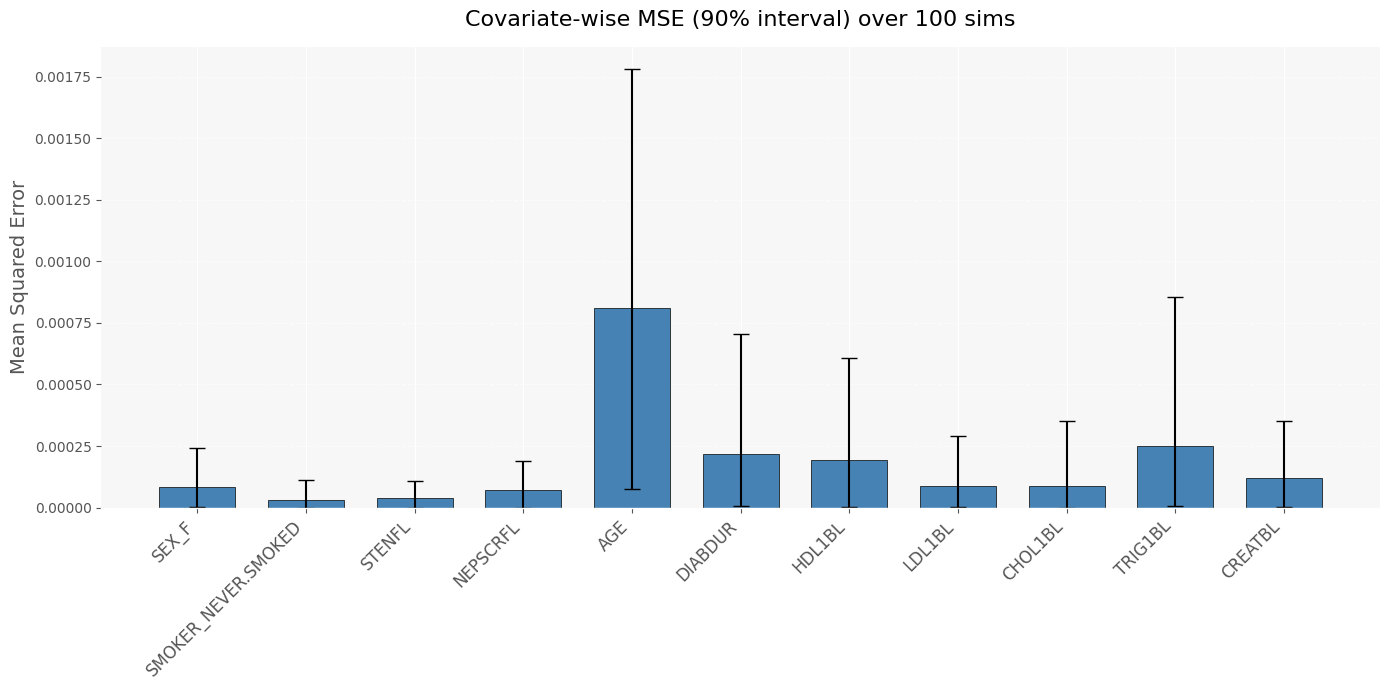

Accuracy:  μ=0.497, σ=0.008, [0.477–0.512]
AUC:       μ=0.500, σ=0.008, [0.483–0.520]


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from copy import deepcopy

# --- 1) Run your simulations, collecting **raw** squared errors --------------
num_simulations = 100
accuracy_list, auc_list = [], []
covariate_squared_errors = []

original_df = deepcopy(df_bsl_norm)
orig_cov_means = original_df.mean()
for i in range(num_simulations):
    # simulate as before...
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    simulated_df = pd.DataFrame(
        s_pred.detach().cpu().numpy(),
        columns=original_df.columns
    )
    
    # classification performance (unchanged)...
    combined = pd.concat([original_df, simulated_df], ignore_index=True)
    X = combined; y = np.concatenate([np.zeros(len(original_df)), np.ones(len(simulated_df))])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    pred = clf.predict(X_test); proba = clf.predict_proba(X_test)[:,1]
    accuracy_list.append(accuracy_score(y_test, pred))
    auc_list.append(roc_auc_score(y_test, proba))
    
    # **raw** MSE per covariate
    sim_means = simulated_df.mean()
    raw_mse = (sim_means - orig_cov_means)**2
    covariate_squared_errors.append(raw_mse)

# Turn into DataFrame
mse_df = pd.DataFrame(covariate_squared_errors)

# --- 2) Compute mean + 5th/95th quantiles ------------------------------------
mse_mean = mse_df.mean()
qs = mse_df.quantile([0.05, 0.95])
lower_err = mse_mean - qs.loc[0.05]
upper_err = qs.loc[0.95] - mse_mean
yerr = np.vstack([lower_err, upper_err])

# --- 3) Pretty bar‐plot ------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(mse_mean))
bars = ax.bar(
    x, mse_mean,
    yerr=yerr,
    capsize=6,
    width=0.7,
    color='steelblue',
    edgecolor='black'
)

# styling
ax.set_facecolor('#f7f7f7')
fig.patch.set_facecolor('white')
ax.grid(axis='y', linestyle='--', alpha=0.6)
for spine in ['top','right','left']:
    ax.spines[spine].set_visible(False)

ax.set_xticks(x)
ax.set_xticklabels(mse_mean.index, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=14)
ax.set_title(f'Covariate‐wise MSE (90% interval) over {num_simulations} sims', fontsize=16, pad=15)

plt.tight_layout()
plt.show()

# --- 4) Summary of classification performance -------------------------------
print(f"Accuracy:  μ={np.mean(accuracy_list):.3f}, σ={np.std(accuracy_list, ddof=1):.3f}, "
      f"[{np.min(accuracy_list):.3f}–{np.max(accuracy_list):.3f}]")
print(f"AUC:       μ={np.mean(auc_list):.3f}, σ={np.std(auc_list, ddof=1):.3f}, "
      f"[{np.min(auc_list):.3f}–{np.max(auc_list):.3f}]")


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

# ... (build combined_df with 'label' as before) ...

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Train a Random Forest classifier
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# Predictions and probabilities
y_pred      = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
auc      = roc_auc_score(y_test, y_pred_proba)
report   = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC:  {auc:.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2619
           1       0.86      0.79      0.82      2619

    accuracy                           0.83      5238
   macro avg       0.83      0.83      0.83      5238
weighted avg       0.83      0.83      0.83      5238

Accuracy: 0.83
ROC AUC:  0.91


In [19]:
model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=3, T=11, s_dim = s_tensor.shape[1], noise_dim=50, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=20000, lr=5e-3, print_every_iter=1000,reg_lambda=1)

Epoch 1: loss 43709562880.0000,	loss_y 1.6631, 1.6975, 0.0687,	loss_eta 3.1490, 3.2986, 0.2993, 	marginal_loss 43709562880.0000
Epoch 1: y_sample_mean 0.012839737348258495
Epoch 1: y_sample1_cat.float().mean() 0.5116605162620544
Epoch 1000: loss 13.2393,	loss_y 0.1589, 0.2019, 0.0860,	loss_eta 12.0173, 25.8170, 27.5996, 	marginal_loss 1.0632
Epoch 1000: y_sample_mean 0.012766843661665916
Epoch 1000: y_sample1_cat.float().mean() 0.008403581567108631
Epoch 2000: loss 12.3481,	loss_y 0.1580, 0.2231, 0.1302,	loss_eta 11.8005, 26.5489, 29.4969, 	marginal_loss 0.3896
Epoch 2000: y_sample_mean 0.012923045083880424
Epoch 2000: y_sample1_cat.float().mean() 0.012474079616367817
Epoch 3000: loss 12.1204,	loss_y 0.1539, 0.2261, 0.1444,	loss_eta 11.7803, 26.6813, 29.8020, 	marginal_loss 0.1862
Epoch 3000: y_sample_mean 0.012943871319293976
Epoch 3000: y_sample1_cat.float().mean() 0.01261359266936779
Epoch 4000: loss 12.0645,	loss_y 0.1498, 0.2313, 0.1630,	loss_eta 11.7291, 26.9316, 30.4050, 	margin

In [20]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=3000, lr=5e-3, print_every_iter=1000,reg_lambda=1)

Epoch 1: loss 3.7206,	loss_y 0.1300, 0.2504, 0.2408,	loss_eta 3.4278, 8.1210, 9.3865, 	marginal_loss 0.1628
Epoch 1: y_sample_mean 0.0129334582015872
Epoch 1: y_sample1_cat.float().mean() 0.012722751125693321
Epoch 1000: loss 2.4364,	loss_y 0.1314, 0.2545, 0.2461,	loss_eta 2.2818, 5.0508, 5.5382, 	marginal_loss 0.0232
Epoch 1000: y_sample_mean 0.0129334582015872
Epoch 1000: y_sample1_cat.float().mean() 0.012965732254087925
Epoch 2000: loss 2.4381,	loss_y 0.1303, 0.2511, 0.2414,	loss_eta 2.2851, 5.0133, 5.4564, 	marginal_loss 0.0227
Epoch 2000: y_sample_mean 0.012860564514994621
Epoch 2000: y_sample1_cat.float().mean() 0.01250985637307167
Epoch 3000: loss 2.4352,	loss_y 0.1299, 0.2516, 0.2433,	loss_eta 2.2812, 5.0803, 5.5982, 	marginal_loss 0.0240
Epoch 3000: y_sample_mean 0.012881391681730747
Epoch 3000: y_sample1_cat.float().mean() 0.01260416954755783


In [21]:
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=40000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 5.4236, loss1 5.6532, loss2 0.4591
Epoch 1000: loss 1.5943, loss1 3.1883, loss2 3.1880
Epoch 2000: loss 1.5068, loss1 3.0219, loss2 3.0303
Epoch 3000: loss 1.4108, loss1 2.8433, loss2 2.8649
Epoch 4000: loss 1.3116, loss1 2.6298, loss2 2.6365
Epoch 5000: loss 1.2312, loss1 2.4884, loss2 2.5143
Epoch 6000: loss 1.1858, loss1 2.3729, loss2 2.3742
Epoch 7000: loss 1.1426, loss1 2.2916, loss2 2.2979
Epoch 8000: loss 1.1165, loss1 2.2307, loss2 2.2284
Epoch 9000: loss 1.0859, loss1 2.1719, loss2 2.1720
Epoch 10000: loss 1.0667, loss1 2.1373, loss2 2.1412
Epoch 11000: loss 1.0479, loss1 2.0893, loss2 2.0827
Epoch 12000: loss 1.0334, loss1 2.0696, loss2 2.0725
Epoch 13000: loss 1.0146, loss1 2.0442, loss2 2.0593
Epoch 14000: loss 1.0127, loss1 2.0188, loss2 2.0122
Epoch 15000: loss 0.9957, loss1 1.9974, loss2 2.0032
Epoch 16000: loss 0.9930, loss1 1.9801, loss2 1.9742
Epoch 17000: loss 0.9759, loss1 1.9588, loss2 1.9657
Epoch 18000: loss 0.9675, loss1 1.9402, loss2 1.9453
Epoch 

In [ ]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=30000, lr=5e-3, print_every_iter=1000,reg_lambda=1)
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=40000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 2.4723,	loss_y 0.1331, 0.2521, 0.2380,	loss_eta 2.2717, 5.0849, 5.6265, 	marginal_loss 0.0675
Epoch 1: y_sample_mean 0.013027179054915905
Epoch 1: y_sample1_cat.float().mean() 0.012893150560557842


In [23]:
# --------------------------------------------------------------------
# Helper: Missing imputation function (as you already defined)
def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    y_out = y.clone() 
    event_indicator = (y_out > 0).float()
    c = torch.cumsum(event_indicator, dim=1)
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    mask = (c_shifted > 0)
    y_out[mask] = missing_to_num

    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape  
    x_out = None
    if x is not None:
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        x_out[mask_expanded] = missing_to_num
        x_out = x_out.view(n_obs, timesteps * x_dim)

    z_out = None
    if z is not None:
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        z_out[mask_expanded] = missing_to_num
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out

# --------------------------------------------------------------------
# Define overall time grid (11 time points) and the observed indices for z2 and z3.
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]  # indices 0,...,10
# Given original measurement times for z2 and z3: 0, 12, 24, 36, 48, 6, 60,
# sort them into increasing order: 0, 6, 12, 24, 36, 48, 60.
# The corresponding indices in the overall time grid are:
observed_idx = [0, 1, 2, 4, 6, 8, 10]

In [28]:
import torch
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split


# Apply the missing imputation to the original tensors
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Convert true tensors to numpy arrays for DataFrame creation
s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, 11)

# Reshape z_tensor to (n_obs, 11, 3)
n_obs = z_tensor.shape[0]
z_true_reshaped = z_tensor.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
# Extract z1: use all 11 time points
z1_true = z_true_reshaped[:, :, 0]              # shape: (n_obs, 11)
# For z2 and z3: extract only the observed indices
z2_true = z_true_reshaped[:, observed_idx, 1]     # shape: (n_obs, len(observed_idx))
z3_true = z_true_reshaped[:, observed_idx, 2]     # shape: (n_obs, len(observed_idx))

# Create column names for each block of features.
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_{t}' for t in time_points]  # all time points for z1
y_cols  = [f'y_{t}' for t in time_points]
z2_cols = [f'z2_{time_points[i]}' for i in observed_idx]
z3_cols = [f'z3_{time_points[i]}' for i in observed_idx]

# Build the original (true) joint DataFrame by concatenating the features along the columns.
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true,y_true_np], axis=1),
    columns =  s_cols+ z1_cols+ y_cols
)
original_joint_df['source'] = 'Original'

# --------------------------------------------------------------------
# --- Simulation Loop ---
num_simulations = 100  
accuracy_list = []
auc_list = []
# --------------------------------------------------------------------
# --- Simulation Loop (with Random Forest) ---
num_simulations = 100  
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # (1) simulate baseline & joint as before
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)

    # (2) missing‐impute
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)

    # (3) build simulated_joint_df exactly as you did
    s_pred_np = s_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    z_pred_reshaped = z_pred.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
    z1_pred = z_pred_reshaped[:, :, 0]
    z2_pred = z_pred_reshaped[:, observed_idx, 1]
    z3_pred = z_pred_reshaped[:, observed_idx, 2]

    simulated_joint_df = pd.DataFrame(
        np.concatenate([ s_pred, z1_pred, y_pred], axis=1),
        columns = s_cols+ z1_cols + y_cols 
    )
    simulated_joint_df['source'] = 'Simulated'

    # (4) combine original & simulated
    combined = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True).round(1)
    X = combined.drop(columns='source')
    y = combined['source'].map({'Original': 0, 'Simulated': 1})

    # (5) train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=2025, stratify=y
    )

    # ===== HERE: Random Forest instead of Logistic Regression =====
    clf_joint = RandomForestClassifier(
        n_estimators=100,
        max_depth=4,
        random_state=2025,
        n_jobs=-1
    )
    clf_joint.fit(X_train, y_train)

    y_pred_lbl   = clf_joint.predict(X_test)
    y_pred_proba = clf_joint.predict_proba(X_test)[:, 1]

    accuracy_list.append(accuracy_score(y_test, y_pred_lbl))
    auc_list     .append(roc_auc_score(y_test, y_pred_proba))

# --- Print Summary Statistics ---
print(f"Joint Data Classification Results over {num_simulations} sims:")
print(f"Accuracy: Mean={np.mean(accuracy_list):.3f}, Std={np.std(accuracy_list,ddof=1):.3f}, "
      f"Min={np.min(accuracy_list):.3f}, Max={np.max(accuracy_list):.3f}")
print(f"AUC:      Mean={np.mean(auc_list):.3f}, Std={np.std(auc_list,ddof=1):.3f}, "
      f"Min={np.min(auc_list):.3f}, Max={np.max(auc_list):.3f}")


Joint Data Classification Results over 100 sims:
Accuracy: Mean=0.660, Std=0.005, Min=0.646, Max=0.672
AUC:      Mean=0.745, Std=0.005, Min=0.733, Max=0.760


In [29]:
clf_joint.feature_importances_

array([1.75786398e-04, 4.66620002e-05, 7.97598276e-05, 5.79752219e-05,
       1.56731398e-02, 8.88724683e-03, 2.38427980e-03, 1.53979514e-03,
       1.37339930e-03, 6.40650263e-03, 3.45743545e-03, 1.30394296e-01,
       6.65223362e-02, 6.33675104e-02, 5.22307598e-02, 4.82968710e-02,
       6.71281021e-02, 6.63108159e-02, 7.09126263e-02, 1.23744593e-01,
       1.50565502e-01, 1.15827648e-01, 0.00000000e+00, 0.00000000e+00,
       5.15183849e-05, 0.00000000e+00, 3.42093477e-05, 0.00000000e+00,
       6.73078256e-04, 8.82014719e-04, 2.25653758e-03, 4.29115168e-04,
       2.90483321e-04])

In [25]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# --------------------------------------------------------------------
# Helper: Missing imputation function (as you already defined)
def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    y_out = y.clone() 
    event_indicator = (y_out > 0).float()
    c = torch.cumsum(event_indicator, dim=1)
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    mask = (c_shifted > 0)
    y_out[mask] = missing_to_num

    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape  
    x_out = None
    if x is not None:
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        x_out[mask_expanded] = missing_to_num
        x_out = x_out.view(n_obs, timesteps * x_dim)

    z_out = None
    if z is not None:
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        z_out[mask_expanded] = missing_to_num
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out

# --------------------------------------------------------------------
# Define overall time grid (11 time points) and the observed indices for z2 and z3.
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]  # indices 0,...,10
# Given original measurement times for z2 and z3: 0, 12, 24, 36, 48, 6, 60,
# sort them into increasing order: 0, 6, 12, 24, 36, 48, 60.
# The corresponding indices in the overall time grid are:
observed_idx = [0, 1, 2, 4, 6, 8, 10]

# --------------------------------------------------------------------
# --- Preprocessing the True (Original) Joint Data ---
# Here we assume that the function missing_impute has already been applied to your original tensors.
# x_tensor, z_tensor, y_tensor, and s_tensor are assumed to exist.
# Note: z_tensor is assumed to be of shape (n_obs, 33); it stacks z1, z2, and z3, each across 11 time points.

# Apply the missing imputation to the original tensors
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Convert true tensors to numpy arrays for DataFrame creation
s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, 11)

# Reshape z_tensor to (n_obs, 11, 3)
n_obs = z_tensor.shape[0]
z_true_reshaped = z_tensor.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
# Extract z1: use all 11 time points
z1_true = z_true_reshaped[:, :, 0]              # shape: (n_obs, 11)
# For z2 and z3: extract only the observed indices
z2_true = z_true_reshaped[:, observed_idx, 1]     # shape: (n_obs, len(observed_idx))
z3_true = z_true_reshaped[:, observed_idx, 2]     # shape: (n_obs, len(observed_idx))

# Create column names for each block of features.
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_{t}' for t in time_points]  # all time points for z1
y_cols  = [f'y_{t}' for t in time_points]
z2_cols = [f'z2_{time_points[i]}' for i in observed_idx]
z3_cols = [f'z3_{time_points[i]}' for i in observed_idx]

# Build the original (true) joint DataFrame by concatenating the features along the columns.
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true, y_true_np, z2_true, z3_true], axis=1),
    columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
)
original_joint_df['source'] = 'Original'

# --------------------------------------------------------------------
# --- Simulation Loop ---
num_simulations = 100  
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample from the baseline model to get new s (and x if needed)
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Sample joint predictions from your main model using the simulated baseline features s_pred
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply the missing imputation on simulated predictions.
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Convert simulated s, y into numpy arrays.
    s_pred_np = s_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    
    # Reshape simulated z_pred to (n_obs, 11, 3)
    z_pred_reshaped = z_pred.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
    # Extract the simulated z1 (all time points)
    z1_pred = z_pred_reshaped[:, :, 0]             
    # And for z2 and z3, take only the observed indices
    z2_pred = z_pred_reshaped[:, observed_idx, 1]
    z3_pred = z_pred_reshaped[:, observed_idx, 2]
    
    # Build the simulated joint DataFrame with the same feature ordering.
    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z1_pred, y_pred_np, z2_pred, z3_pred], axis=1),
        columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
    )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data.
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    combined_joint_df= combined_joint_df.round(1)
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into train and test sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=2025, stratify=y_joint
    )
    
    # Train the logistic regression classifier.
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set.
    y_joint_pred = clf_joint.predict(X_test)
    y_joint_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC.
    accuracy_joint = accuracy_score(y_test, y_joint_pred)
    auc_joint = roc_auc_score(y_test, y_joint_pred_proba)
    
    # Save the results.
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (over {} simulations):".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))

Joint Data Classification Results (over 100 simulations):
Accuracy: Mean=0.582, Std=0.007, Min=0.568, Max=0.604
AUC: Mean=0.600, Std=0.007, Min=0.587, Max=0.616


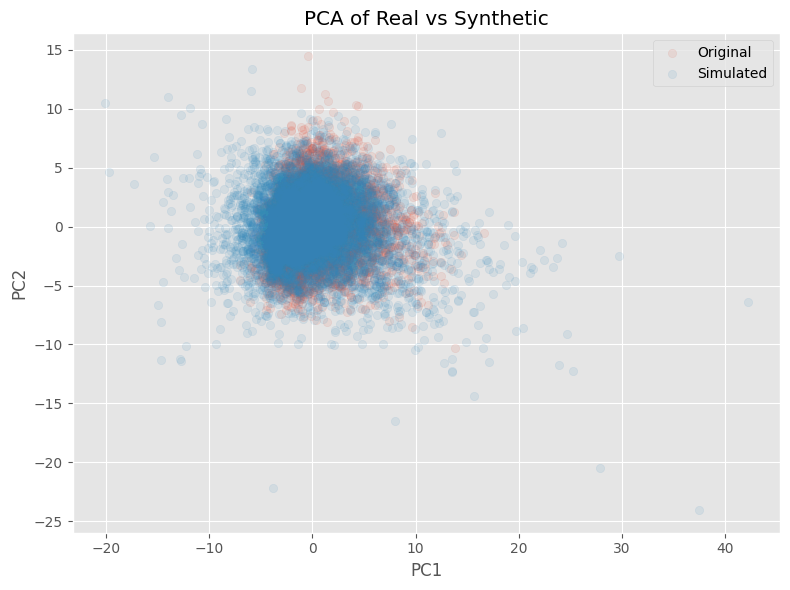

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1) Combine your real & one simulated dataset
combined = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
X = combined.drop(columns='source').values
y = combined['source'].values  # array of 'Original' / 'Simulated'

# 2) PCA → 2D
pca = PCA(n_components=2, random_state=2025)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for label in ['Original', 'Simulated']:
    idx = (y == label)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=label, alpha=0.1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Real vs Synthetic')
plt.legend()
plt.tight_layout()
plt.show()



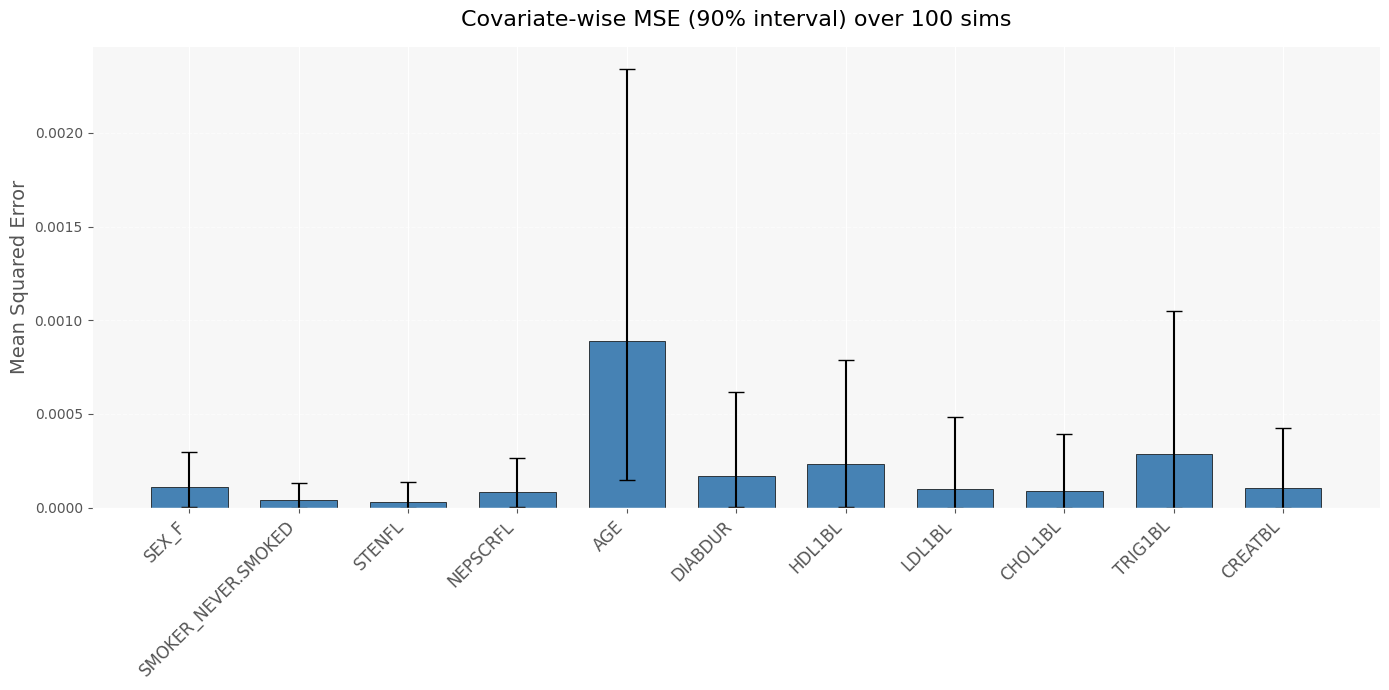

Accuracy:  μ=0.498, σ=0.008, [0.473–0.516]
AUC:       μ=0.501, σ=0.008, [0.481–0.518]


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from copy import deepcopy

# --- 1) Run your simulations, collecting **raw** squared errors --------------
num_simulations = 100
accuracy_list, auc_list = [], []
covariate_squared_errors = []

original_df = deepcopy(df_bsl_norm)
orig_cov_means = original_df.mean()
for i in range(num_simulations):
    # simulate as before...
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    simulated_df = pd.DataFrame(
        s_pred.detach().cpu().numpy(),
        columns=original_df.columns
    )
    
    # classification performance (unchanged)...
    combined = pd.concat([original_df, simulated_df], ignore_index=True)
    X = combined; y = np.concatenate([np.zeros(len(original_df)), np.ones(len(simulated_df))])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    pred = clf.predict(X_test); proba = clf.predict_proba(X_test)[:,1]
    accuracy_list.append(accuracy_score(y_test, pred))
    auc_list.append(roc_auc_score(y_test, proba))
    
    # **raw** MSE per covariate
    sim_means = simulated_df.mean()
    raw_mse = (sim_means - orig_cov_means)**2
    covariate_squared_errors.append(raw_mse)

# Turn into DataFrame
mse_df = pd.DataFrame(covariate_squared_errors)

# --- 2) Compute mean + 5th/95th quantiles ------------------------------------
mse_mean = mse_df.mean()
qs = mse_df.quantile([0.05, 0.95])
lower_err = mse_mean - qs.loc[0.05]
upper_err = qs.loc[0.95] - mse_mean
yerr = np.vstack([lower_err, upper_err])

# --- 3) Pretty bar‐plot ------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(mse_mean))
bars = ax.bar(
    x, mse_mean,
    yerr=yerr,
    capsize=6,
    width=0.7,
    color='steelblue',
    edgecolor='black'
)

# styling
ax.set_facecolor('#f7f7f7')
fig.patch.set_facecolor('white')
ax.grid(axis='y', linestyle='--', alpha=0.6)
for spine in ['top','right','left']:
    ax.spines[spine].set_visible(False)

ax.set_xticks(x)
ax.set_xticklabels(mse_mean.index, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=14)
ax.set_title(f'Covariate‐wise MSE (90% interval) over {num_simulations} sims', fontsize=16, pad=15)

plt.tight_layout()
plt.show()

# --- 4) Summary of classification performance -------------------------------
print(f"Accuracy:  μ={np.mean(accuracy_list):.3f}, σ={np.std(accuracy_list, ddof=1):.3f}, "
      f"[{np.min(accuracy_list):.3f}–{np.max(accuracy_list):.3f}]")
print(f"AUC:       μ={np.mean(auc_list):.3f}, σ={np.std(auc_list, ddof=1):.3f}, "
      f"[{np.min(auc_list):.3f}–{np.max(auc_list):.3f}]")


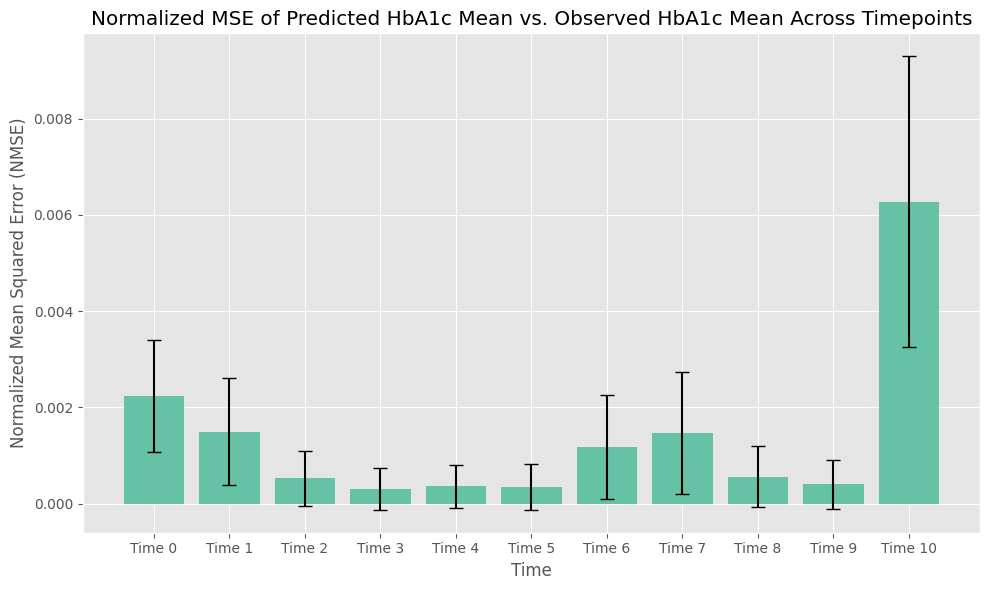

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
n_obs, total_dim = z_tensor.shape
timepoints = 11
z_dim = 3
num_samples = 500

x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)
# Reshape the observed z tensor: shape becomes (n_obs, timepoints, z_dim)
z_obs_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)
z1_obs = z_obs_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)

# Compute the observed mean and variance (using sample variance) across observations for each timepoint
z1_obs_mean = np.mean(z1_obs, axis=0)           # shape: (timepoints,)
z1_obs_var = np.var(z1_obs, axis=0, ddof=1)       # shape: (timepoints,)

# Initialize list to collect predictions for z1
z1_samples = []

# Generate predictions in each iteration
for _ in range(num_samples):
    # Sample new predictions each time
    _, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Reshape predictions: (n_obs, timepoints, z_dim)
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)
    
    # Extract z1 and convert to numpy array
    z1_pred = z_pred_reshaped[:, :, 0].detach().cpu().numpy()
    z1_samples.append(z1_pred)

# Stack predicted samples to create an array of shape (num_samples, n_obs, timepoints)
z1_samples_array = np.stack(z1_samples, axis=0)

# For each predicted sample, compute its mean across observations (shape: (num_samples, timepoints))
z1_samples_mean = np.mean(z1_samples_array, axis=1)

# Calculate the squared errors for each sample and timepoint: (predicted mean - observed mean)^2
squared_errors = (z1_samples_mean - z1_obs_mean)**2

# Normalize squared errors by dividing by the variance at each timepoint
# This yields a normalized squared error for each sample and timepoint.
normalized_squared_errors = squared_errors / z1_obs_var

# For each timepoint, compute:
# - The mean normalized MSE across all samples
# - The standard deviation of the normalized MSE (to use as error bars)
nmse_mean = np.mean(normalized_squared_errors, axis=0)
nmse_std = np.std(normalized_squared_errors, axis=0, ddof=1)

# Create a bar plot with error bars
time = np.arange(timepoints)
plt.figure(figsize=(10, 6))
plt.bar(time, nmse_mean, yerr=nmse_std, capsize=5, color=sns.color_palette("Set2")[0])
plt.xlabel("Time")
plt.ylabel("Normalized Mean Squared Error (NMSE)")
plt.title("Normalized MSE of Predicted HbA1c Mean vs. Observed HbA1c Mean Across Timepoints")
plt.xticks(time, [f"Time {t}" for t in time])
plt.tight_layout()
plt.show()


In [61]:
import torch
import numpy as np

# --- SETTINGS --------------------------------------------------------------
num_sims = 100
# s_tensor: your N×latent input for units
# x_tensor: original N×T treatment‐history (we'll just use its shape)
N0, T = s_tensor[(x_tensor[:,0]==0),:].shape
N1, T = s_tensor[(x_tensor[:,0]==1),:].shape
# Prepare “pure” control/treatment arms
x_control = torch.zeros((N0, T), dtype=torch.int32)
x_treat   = torch.ones((N1, T), dtype=torch.int32)

control_event_rates = []
treat_event_rates   = []

for _ in range(num_sims):
    # simulate y under control
    y_ctrl = model.sample_causal_margin(
        s=s_tensor[(x_tensor[:,0]==0),:],
        x=x_control,
        sample_size=1
    )
    # simulate y under treatment
    y_trt  = model.sample_causal_margin(
        s=s_tensor[(x_tensor[:,0]==1),:],
        x=x_treat,
        sample_size=1
    )

    # y_ctrl, y_trt assumed shape [N, T] of 0/1’s
    # compute per‐unit “ever an event” indicator
    ever_ctrl = (y_ctrl.sum(dim=1) > 0).float()
    ever_trt  = (y_trt.sum(dim=1) > 0).float()

    # fraction of units with ≥1 event
    control_event_rates.append(ever_ctrl.mean().item())
    treat_event_rates.append( ever_trt.mean().item())



In [67]:
# now summarize
ctrl_min, ctrl_max = np.quantile(control_event_rates, 0.1), np.quantile(control_event_rates,0.9)
trt_min,  trt_max  = np.quantile(treat_event_rates,0.1),   np.quantile(treat_event_rates, 0.9)
ctrl_mean = np.mean(control_event_rates)
trt_mean = np.mean(treat_event_rates)

print(f"Control arm event‐rate over {num_sims} sims: {ctrl_min:.3f}–{ctrl_max:.3f}")
print(f" Treatment arm event‐rate over {num_sims} sims: {trt_min:.3f}–{trt_max:.3f}")
print(ctrl_mean)
print(trt_mean)

Control arm event‐rate over 100 sims: 0.142–0.154
 Treatment arm event‐rate over 100 sims: 0.137–0.150
0.14858715534210204
0.1434347826242447


In [63]:
y_ctrl_true = y_tensor[(x_tensor[:,0]==0),:]
y_trt_true = y_tensor[(x_tensor[:,1]==0),:]

ever_ctrl_true = (y_ctrl_true.sum(dim=1) > 0).float()

In [64]:
mask = (arm_values == 1)
y_tr = y_tensor[mask,:]
y_cr = y_tensor[~mask,:]
sum(y_tr==1).sum()/y_tr.shape[0]

tensor(0.1263)

In [65]:
sum(y_cr==1).sum()/y_cr.shape[0]

tensor(0.1413)

## standardize z but only continuous s

In [19]:
import pandas as pd
import numpy as np
import torch
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# ------------------------- Load Your Data -------------------------
df_z1 = deepcopy(df_hba1c)   # longitudinal covariate z1
df_z2 = deepcopy(df_egfr)    # longitudinal covariate z2
df_z3 = deepcopy(df_bmi)     # longitudinal covariate z3
df_bsl = deepcopy(df_bsl_read)    # baseline covariates
df_Y = deepcopy(df_Y_read)        # outcome
df_bsl.dropna(inplace=True)
df_bsl.drop(df_bsl[(df_bsl['TRIG1BL'] > 8) | (df_bsl['CREATBL'] > 160)].index, inplace=True)



# --------------------- Process df_Y (Outcome) ---------------------
# Ensure Y0 exists and select Y0 to Y10.
if 'Y0' not in df_Y.columns:
    df_Y.insert(1, 'Y0', 0.0)
df_Y = df_Y[['USUBJID'] + [f'Y{i}' for i in range(0, 11)]]

# ----------------- Time Points You Care About ---------------------
# (These are the actual numeric time values corresponding to Y0 ... Y10.)
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]

def process_longitudinal(df, time_points):
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points if str(tp) in df.columns]].copy()
    for tp in time_points:
        col = str(tp)
        if col not in df.columns:
            df.loc[:, col] = np.nan
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points]]

    df['na_count'] = df.isna().sum(axis=1)
    df = df.loc[df['na_count'] <= 5].drop(columns='na_count').reset_index(drop=True)

    for idx in range(len(df)):
        for t_idx, t in enumerate(time_points):
            col = str(t)
            if pd.isna(df.loc[idx, col]):
                for prev_t in reversed(time_points[:t_idx]):
                    prev_col = str(prev_t)
                    if not pd.isna(df.loc[idx, prev_col]):
                        df.loc[idx, col] = df.loc[idx, prev_col]
                        break

    return df

# ------------- Process and Clean z1, z2, z3 ----------------
df_z1_clean = process_longitudinal(df_z1, time_points)
df_z2_clean = process_longitudinal(df_z2, time_points)
df_z3_clean = process_longitudinal(df_z3, time_points)


df_z1_clean = df_z1_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z2_clean = df_z2_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z3_clean = df_z3_clean.dropna(axis=0, how='any').reset_index(drop=True)

# ------------ Align All by Intersection of USUBJID -------------
common_ids = (set(df_Y['USUBJID']) 
              & set(df_z1_clean['USUBJID']) 
              & set(df_z2_clean['USUBJID']) 
              & set(df_z3_clean['USUBJID']) 
              & set(df_bsl['USUBJID']))
df_Y = df_Y[df_Y['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z1_clean = df_z1_clean[df_z1_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z2_clean = df_z2_clean[df_z2_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z3_clean = df_z3_clean[df_z3_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_bsl = df_bsl[df_bsl['USUBJID'].isin(common_ids)].reset_index(drop=True)


for D in (df_Y, df_z1_clean, df_z2_clean, df_z3_clean, df_bsl):
    D.sort_values('USUBJID', inplace=True)
    D.reset_index(drop=True, inplace=True)

cols = [str(tp) for tp in time_points]

for df in (df_z1_clean, df_z2_clean, df_z3_clean):
    # compute per-column mean & std, skipping NaNs
    means = df[cols].mean(skipna=True)
    stds  = df[cols].std(skipna=True)

    # subtract mean, divide by std; NaNs remain NaN
    df[cols] = (df[cols] - means) / stds

# ----------------- Build the Z torch tensor (longitudinal) ----------------------

Z_list = []
for idx in range(len(df_z1_clean)):
    z1_vals = df_z1_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z2_vals = df_z2_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z3_vals = df_z3_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values

    Z_subj = np.column_stack([z1_vals, z2_vals, z3_vals]).reshape(-1)
    Z_list.append(Z_subj.astype(np.float32))

z_tensor = torch.tensor(np.vstack(Z_list), dtype=torch.float32)  # Shape (n_subjects, len(time_points))
# ----------------- Build the X tensor (ARM repeated over time) -------------------
# Pull ARM values from df_bsl; assume 'ARM' is a column.
arm_values = df_bsl['ARM'].astype(float).values  # shape (n_subjects,)
x_tensor = torch.tensor(np.repeat(arm_values[:, np.newaxis], len(time_points), axis=1), dtype=torch.int32)
# ------------------ Build the y torch tensor ----------------------
y_cols = [f'Y{i}' for i in range(0, 11)]
y_np = df_Y[y_cols].astype(float).values  # Ensure it's float so that NaN is preserved
y_tensor = torch.tensor(y_np, dtype=torch.int32)
# ----------------- Build the S tensor (baseline features) -------------------
df_bsl_features = df_bsl.drop(columns=['USUBJID','ARM',  
    'RACE_AMERICAN.INDIAN.OR.ALASKA.NATIVE',
    'RACE_NATIVE.HAWAIIAN.OR.OTHER.PACIFIC.ISLANDER',
    'RACE_OTHER',
    'RACE_ASIAN',
    'RACE_BLACK.OR.AFRICAN.AMERICAN',"HBA1CBL","BMIBL", 'SMOKER_CURRENT.SMOKER','SEX_F', 'SMOKER_NEVER.SMOKED', 'MIFL',  "STROKEFL",	"STENFL",'NEPSCRFL', 'KIDFL'
    # "STROKEFL",	"STENFL",
    # #"AGE", 
    # "DIABDUR",
    #"HDL1BL",	"LDL1BL",	
    # "CHOL1BL",	
    #"TRIG1BL", 
    # "CREATBL"
    ])

binary_cols     = ['SEX_F', 'SMOKER_NEVER.SMOKED', 'MIFL',  "STROKEFL",	"STENFL",'NEPSCRFL', 'KIDFL'] 
continuous_cols = [c for c in df_bsl_features.columns
                   if c not in binary_cols]

# 2. Scale the continuous ones to zero‑mean, unit‑variance
scaler = StandardScaler()
df_bsl_cont = pd.DataFrame(
    scaler.fit_transform(df_bsl[continuous_cols]),
    columns=continuous_cols,
    index=df_bsl.index
)

df_bsl_norm = pd.concat([df_bsl_cont], axis=1)

x_bsl_tensor = torch.tensor(df_bsl['ARM'].values, dtype=torch.int32).view(-1, 1)
# s_tensor = torch.tensor(df_bsl_features.values, dtype=torch.float32)
s_tensor = torch.tensor(df_bsl_norm.astype(float).values, dtype=torch.float32)

# ----------------- Check shape -------------------
print(f"s_tensor shape: {s_tensor.shape}")  # (n_subjects, num_baseline_features)
print(f"z_tensor shape: {z_tensor.shape}")  # (n_subjects, {len(time_points)}) 
print(f"x_tensor shape (ARM): {x_tensor.shape}")  # (n_subjects, 11)
print(f"y_tensor shape: {y_tensor.shape}")  # (n_subjects, 11)

# Optional: Sanity check USUBJID order alignment.
print(np.all(df_Y['USUBJID'].values == df_z1_clean['USUBJID'].values))
print(np.all(df_Y['USUBJID'].values == df_bsl['USUBJID'].values))
print(torch.isnan(y_tensor).any())  # Returns True if any NaN exists

# Optional: Count the number of 1's in a DataFrame.
# For example, to count total number of 1s in df_Y (excluding the USUBJID column):
ones_count = (df_Y.drop(columns=['USUBJID']) == 1).sum().sum()
print("Total number of 1s in df_Y:", ones_count)


s_tensor shape: torch.Size([8730, 7])
z_tensor shape: torch.Size([8730, 33])
x_tensor shape (ARM): torch.Size([8730, 11])
y_tensor shape: torch.Size([8730, 11])
True
True
tensor(False)
Total number of 1s in df_Y: 1168


In [20]:
p = s_tensor.shape[1]
print(f'number of covariates: {p}')
binary_intervention = True


model_bsl = Frengression(x_bsl_tensor.shape[1], y_tensor.shape[1], s_tensor.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention, z_binary_dims=0)
model_bsl.train_xz(x_bsl_tensor, s_tensor, num_iters=15000, lr=1e-3, print_every_iter=1000)

number of covariates: 7
Epoch 1: loss 2.4242, loss1 2.5528, loss2 0.2573
Epoch 1000: loss 1.7915, loss1 3.5789, loss2 3.5748
Epoch 2000: loss 1.8101, loss1 3.6013, loss2 3.5824
Epoch 3000: loss 1.7994, loss1 3.5965, loss2 3.5941
Epoch 4000: loss 1.7956, loss1 3.5985, loss2 3.6057
Epoch 5000: loss 1.7913, loss1 3.6004, loss2 3.6181
Epoch 6000: loss 1.8018, loss1 3.6183, loss2 3.6329
Epoch 7000: loss 1.8085, loss1 3.5888, loss2 3.5606
Epoch 8000: loss 1.7962, loss1 3.5981, loss2 3.6039
Epoch 9000: loss 1.7937, loss1 3.5874, loss2 3.5873
Epoch 10000: loss 1.7998, loss1 3.5856, loss2 3.5716
Epoch 11000: loss 1.7900, loss1 3.6104, loss2 3.6408
Epoch 12000: loss 1.7873, loss1 3.5867, loss2 3.5989
Epoch 13000: loss 1.7935, loss1 3.5982, loss2 3.6093
Epoch 14000: loss 1.8016, loss1 3.6000, loss2 3.5968
Epoch 15000: loss 1.7980, loss1 3.6119, loss2 3.6278


In [56]:
model_bsl.train_xz(x_bsl_tensor, s_tensor, num_iters=5000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 1.7944, loss1 3.6034, loss2 3.6179
Epoch 1000: loss 1.8014, loss1 3.5869, loss2 3.5709
Epoch 2000: loss 1.8054, loss1 3.6083, loss2 3.6059
Epoch 3000: loss 1.8009, loss1 3.5929, loss2 3.5841
Epoch 4000: loss 1.7851, loss1 3.5934, loss2 3.6167
Epoch 5000: loss 1.8075, loss1 3.5987, loss2 3.5824


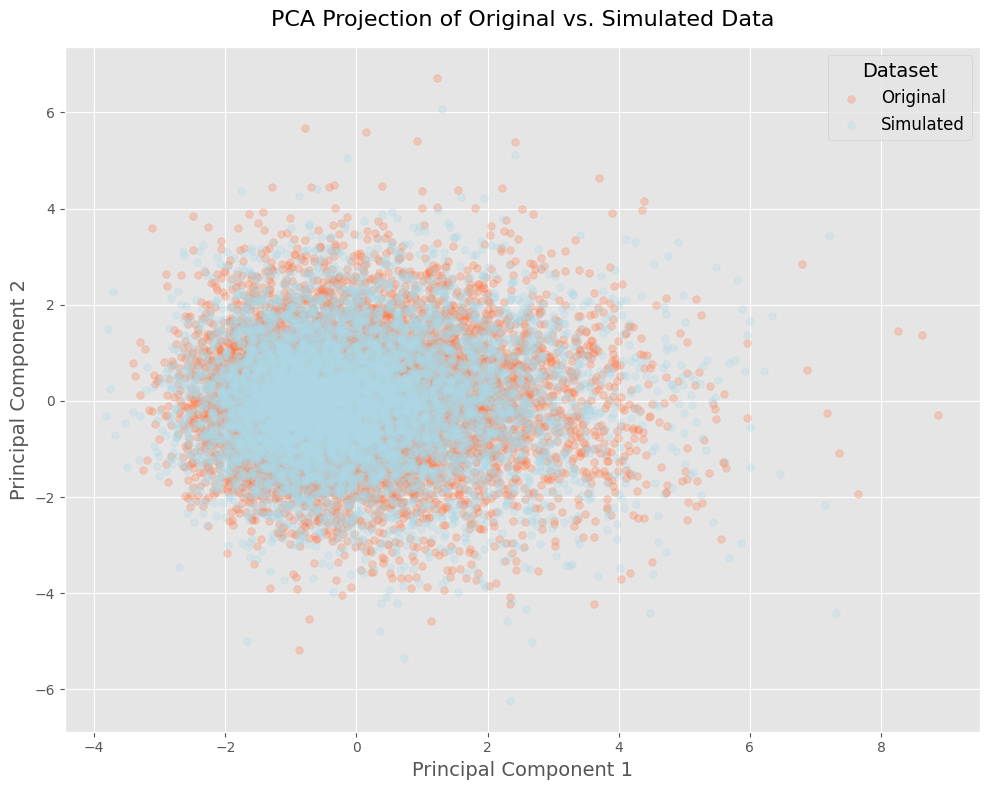

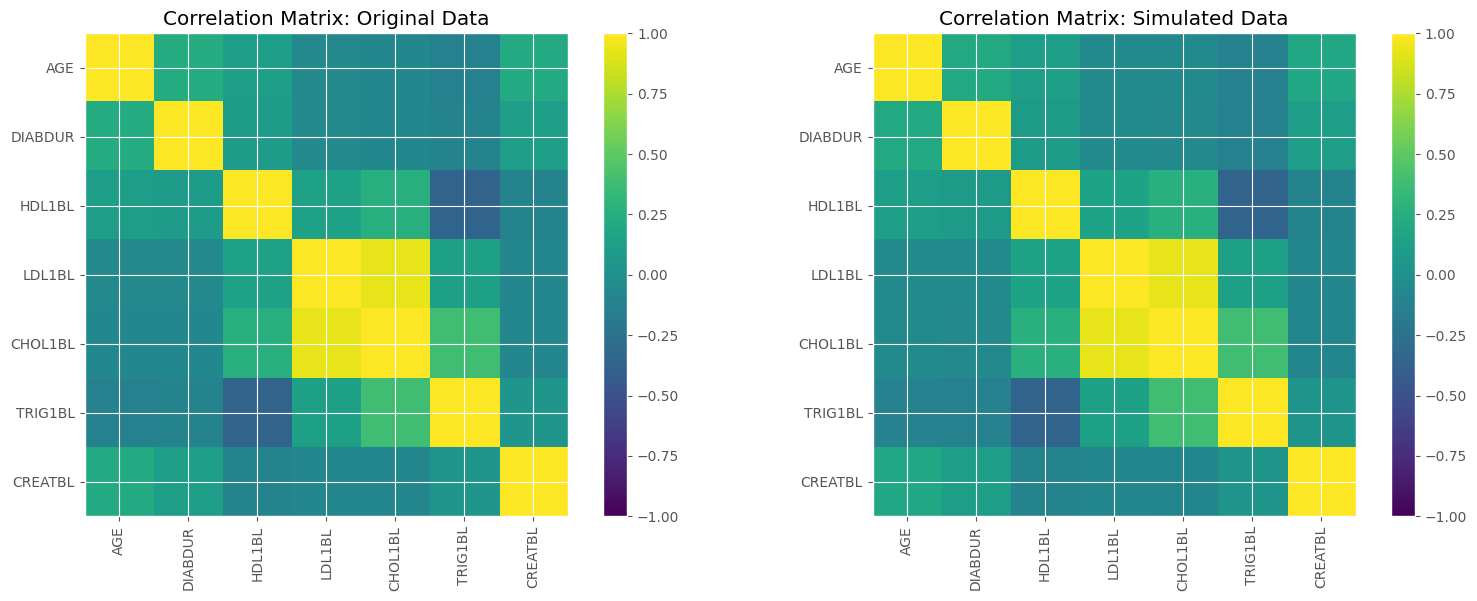

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.41      0.45      2619
           1       0.50      0.59      0.54      2619

    accuracy                           0.50      5238
   macro avg       0.50      0.50      0.50      5238
weighted avg       0.50      0.50      0.50      5238

Accuracy: 0.50
ROC AUC: 0.50


In [57]:
x,s_pred=model_bsl.sample_xz(sample_size=s_tensor.shape[0])

original_df = deepcopy(df_bsl_norm)
simulated_df = pd.DataFrame(s_pred.numpy())
simulated_df.columns = original_df.columns
original_df ['source'] = 'original'
simulated_df['source'] = 'simulated'
# original_df.drop(columns={'USUBJID'},inplace=True)
combined_df = pd.concat([original_df, simulated_df], ignore_index=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

original_df['source'] = 'Original'
simulated_df['source'] = 'Simulated'

combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
features = combined_df.drop(columns='source')
labels = combined_df['source']

# --- PCA Transformation ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['source'] = labels.values

style = 'seaborn' if 'seaborn' in plt.style.available else 'ggplot'
plt.style.use(style)

fig, ax = plt.subplots(figsize=(10, 8))


colors = {'Original': 'coral', 'Simulated': 'lightblue'}

for group in pca_df['source'].unique():
    group_data = pca_df[pca_df['source'] == group]
    ax.scatter(group_data['PC1'], group_data['PC2'],
               s=30, alpha=0.3, label=group, color=colors[group])

ax.set_title('PCA Projection of Original vs. Simulated Data', fontsize=16, pad=15)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)

ax.legend(title='Dataset', fontsize=12, title_fontsize=14, loc='best')

plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ---------------------------
# 1. Population Summary Comparison
# ---------------------------
# Compute mean values for each covariate
original_df.drop(columns={'source'},inplace=True)
simulated_df.drop(columns={'source'},inplace=True)
mean_original = original_df.mean()
mean_simulated = simulated_df.mean()

# Create a grouped bar chart comparing means
x = np.arange(len(mean_original))  # positions for each covariate
width = 0.35  # width of the bars

# plt.style.use('ggplot')  # Use a beautiful built-in style
# fig, ax = plt.subplots(figsize=(12, 6))
# rects1 = ax.bar(x - width/2, mean_original, width, label='Original')
# rects2 = ax.bar(x + width/2, mean_simulated, width, label='Simulated')

# ax.set_xticks(x)
# ax.set_xticklabels(original_df.columns, rotation=45, ha='right')
# ax.set_ylabel('Mean Value')
# ax.set_title('Comparison of Mean Values by Covariate')
# ax.legend()
# plt.tight_layout()
# plt.show()


corr_original = original_df.corr()
corr_simulated = simulated_df.corr()

# Create two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for original data
im0 = axes[0].imshow(corr_original, cmap='viridis', vmin=-1, vmax=1)
axes[0].set_title('Correlation Matrix: Original Data')
axes[0].set_xticks(np.arange(len(corr_original.columns)))
axes[0].set_xticklabels(corr_original.columns, rotation=90)
axes[0].set_yticks(np.arange(len(corr_original.columns)))
axes[0].set_yticklabels(corr_original.columns)
plt.colorbar(im0, ax=axes[0])

# Heatmap for simulated data
im1 = axes[1].imshow(corr_simulated, cmap='viridis', vmin=-1, vmax=1)
axes[1].set_title('Correlation Matrix: Simulated Data')
axes[1].set_xticks(np.arange(len(corr_simulated.columns)))
axes[1].set_xticklabels(corr_simulated.columns, rotation=90)
axes[1].set_yticks(np.arange(len(corr_simulated.columns)))
axes[1].set_yticklabels(corr_simulated.columns)
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


orig = original_df.copy()
sim = simulated_df.copy()

orig['label'] = 0
sim['label'] = 1

# Combine the datasets
combined_df = pd.concat([orig, sim], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into training and testing sets (stratified to maintain label balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Get predictions and predicted probabilities for AUC calculation
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC: {:.2f}".format(auc))

# If the two datasets are very similar, even a strong classifier should perform poorly
# (accuracy near 50% and AUC near 0.5), indicating that it is difficult to tell them apart.


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

# ... (build combined_df with 'label' as before) ...

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Train a Random Forest classifier
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# Predictions and probabilities
y_pred      = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
auc      = roc_auc_score(y_test, y_pred_proba)
report   = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC:  {auc:.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.95      0.69      2619
           1       0.81      0.21      0.34      2619

    accuracy                           0.58      5238
   macro avg       0.68      0.58      0.52      5238
weighted avg       0.68      0.58      0.52      5238

Accuracy: 0.58
ROC AUC:  0.67


In [52]:
clf.feature_importances_

array([0.31045719, 0.35795141, 0.07337975, 0.01725986, 0.03059759,
       0.11220629, 0.09814792])

In [45]:
sim.describe()

,AGE,DIABDUR,HDL1BL,LDL1BL,CHOL1BL,TRIG1BL,CREATBL,label
count,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.0
mean,0.014230,0.012179,-0.009493,-0.026060,-0.025621,-0.000417,-0.007199,1.0
std,0.990026,1.001000,1.039719,0.980789,0.980726,1.015072,0.990686,0.0
min,-3.282821,-2.696157,-3.569791,-2.694443,-2.705042,-2.005109,-2.746621,1.0
25%,-0.686423,-0.711366,-0.716354,-0.735384,-0.728556,-0.675780,-0.712481,1.0
50%,-0.028953,-0.142127,-0.147024,-0.185862,-0.166104,-0.258827,-0.172336,1.0
75%,0.660998,0.596183,0.555275,0.538266,0.543298,0.417273,0.556305,1.0
max,3.574349,6.285489,5.859068,5.737958,5.443117,8.019159,5.108867,1.0


In [53]:
orig.describe()

,AGE,DIABDUR,HDL1BL,LDL1BL,CHOL1BL,TRIG1BL,CREATBL,label
count,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8730.0
mean,3.684974e-16,2.315572e-16,-4.989263e-16,-1.397889e-16,-1.815018e-16,2.559744e-16,-3.418419e-17,0.0
std,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,0.0
min,-2.131642e+00,-1.603052e+00,-2.900511e+00,-2.443710e+00,-2.435864e+00,-1.662750e+00,-2.536490e+00,0.0
25%,-5.924512e-01,-7.296927e-01,-6.966079e-01,-7.220590e-01,-7.185683e-01,-6.903835e-01,-7.027698e-01,0.0
50%,-3.274566e-02,-1.727681e-01,-1.298900e-01,-1.553042e-01,-1.461365e-01,-2.524819e-01,-1.730283e-01,0.0
75%,6.668863e-01,5.487024e-01,5.312809e-01,5.504659e-01,5.694032e-01,3.942650e-01,5.604598e-01,0.0
max,3.325488e+00,6.117948e+00,8.843144e+00,6.303562e+00,6.016449e+00,5.406554e+00,3.168418e+00,0.0


In [27]:
combined_df

,AGE,DIABDUR,HDL1BL,LDL1BL,CHOL1BL,TRIG1BL,CREATBL,label
0,-0.872304,0.928424,-0.854030,-0.016289,-0.137192,0.214613,-0.336026,0
1,-0.032746,0.662619,-0.539186,-1.000090,-1.210502,-0.539925,0.071468,0
2,-1.012230,0.877794,-0.444733,0.133420,-0.074583,-0.171639,-0.173028,0
3,-1.432010,-0.147453,1.916591,-0.337093,0.041693,-0.521960,-0.213778,0
4,-0.312598,-1.299275,0.184953,-0.230159,-0.423408,-0.701612,0.927204,0
...,...,...,...,...,...,...,...,...
17455,0.063980,-0.968243,0.228054,1.743009,1.523295,-0.183587,0.016738,1
17456,2.210285,-0.367764,0.062880,1.485965,1.217042,0.014499,1.958776,1
17457,0.575518,-0.675474,0.221152,0.362769,0.159749,-0.368430,0.072983,1
17458,0.667578,-0.536298,-0.178630,-1.196779,-1.300439,-0.800898,-0.893572,1


In [59]:
model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=3, T=11, s_dim = s_tensor.shape[1], noise_dim=4, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=30000, lr=5e-3, print_every_iter=1000,reg_lambda=1)

Epoch 1: loss 40347901952.0000,	loss_y 1.6257, 1.6453, 0.0392,	loss_eta 3.1074, 3.2615, 0.3081, 	marginal_loss 40347901952.0000
Epoch 1: y_sample_mean 0.012766843661665916
Epoch 1: y_sample1_cat.float().mean() 0.4953463077545166
Epoch 1000: loss 11.2490,	loss_y 0.1663, 0.1991, 0.0656,	loss_eta 10.5392, 23.2694, 25.4603, 	marginal_loss 0.5436
Epoch 1000: y_sample_mean 0.013006351888179779
Epoch 1000: y_sample1_cat.float().mean() 0.010869385674595833
Epoch 2000: loss 10.0609,	loss_y 0.1601, 0.2182, 0.1161,	loss_eta 9.7026, 21.8940, 24.3828, 	marginal_loss 0.1982
Epoch 2000: y_sample_mean 0.013006351888179779
Epoch 2000: y_sample1_cat.float().mean() 0.012746436521410942
Epoch 3000: loss 10.0793,	loss_y 0.1508, 0.2259, 0.1501,	loss_eta 9.7272, 21.9580, 24.4616, 	marginal_loss 0.2013
Epoch 3000: y_sample_mean 0.012902217917144299
Epoch 3000: y_sample1_cat.float().mean() 0.012988696806132793
Epoch 4000: loss 10.0149,	loss_y 0.1452, 0.2308, 0.1711,	loss_eta 9.6816, 22.0185, 24.6738, 	marginal

In [60]:
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=20000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 5.5199, loss1 5.6575, loss2 0.2752
Epoch 1000: loss 1.5632, loss1 3.1338, loss2 3.1413
Epoch 2000: loss 1.4688, loss1 2.9595, loss2 2.9813
Epoch 3000: loss 1.3878, loss1 2.7856, loss2 2.7957
Epoch 4000: loss 1.3331, loss1 2.6739, loss2 2.6817
Epoch 5000: loss 1.2932, loss1 2.5840, loss2 2.5815
Epoch 6000: loss 1.2659, loss1 2.5281, loss2 2.5243
Epoch 7000: loss 1.2385, loss1 2.4746, loss2 2.4723
Epoch 8000: loss 1.2223, loss1 2.4309, loss2 2.4172
Epoch 9000: loss 1.1974, loss1 2.3938, loss2 2.3928
Epoch 10000: loss 1.1889, loss1 2.3619, loss2 2.3461
Epoch 11000: loss 1.1701, loss1 2.3364, loss2 2.3326
Epoch 12000: loss 1.1562, loss1 2.2983, loss2 2.2841
Epoch 13000: loss 1.1418, loss1 2.2935, loss2 2.3033
Epoch 14000: loss 1.1331, loss1 2.2721, loss2 2.2780
Epoch 15000: loss 1.1235, loss1 2.2399, loss2 2.2328
Epoch 16000: loss 1.1172, loss1 2.2289, loss2 2.2235
Epoch 17000: loss 1.1168, loss1 2.2229, loss2 2.2120
Epoch 18000: loss 1.1111, loss1 2.2088, loss2 2.1955
Epoch 

In [61]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# --------------------------------------------------------------------
# Helper: Missing imputation function (as you already defined)
def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    y_out = y.clone() 
    event_indicator = (y_out > 0).float()
    c = torch.cumsum(event_indicator, dim=1)
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    mask = (c_shifted > 0)
    y_out[mask] = missing_to_num

    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape  
    x_out = None
    if x is not None:
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        x_out[mask_expanded] = missing_to_num
        x_out = x_out.view(n_obs, timesteps * x_dim)

    z_out = None
    if z is not None:
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        z_out[mask_expanded] = missing_to_num
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out

# --------------------------------------------------------------------
# Define overall time grid (11 time points) and the observed indices for z2 and z3.
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]  # indices 0,...,10
# Given original measurement times for z2 and z3: 0, 12, 24, 36, 48, 6, 60,
# sort them into increasing order: 0, 6, 12, 24, 36, 48, 60.
# The corresponding indices in the overall time grid are:
observed_idx = [0, 1, 2, 4, 6, 8, 10]

# --------------------------------------------------------------------
# --- Preprocessing the True (Original) Joint Data ---
# Here we assume that the function missing_impute has already been applied to your original tensors.
# x_tensor, z_tensor, y_tensor, and s_tensor are assumed to exist.
# Note: z_tensor is assumed to be of shape (n_obs, 33); it stacks z1, z2, and z3, each across 11 time points.

# Apply the missing imputation to the original tensors
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Convert true tensors to numpy arrays for DataFrame creation
s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, 11)

# Reshape z_tensor to (n_obs, 11, 3)
n_obs = z_tensor.shape[0]
z_true_reshaped = z_tensor.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
# Extract z1: use all 11 time points
z1_true = z_true_reshaped[:, :, 0]              # shape: (n_obs, 11)
# For z2 and z3: extract only the observed indices
z2_true = z_true_reshaped[:, observed_idx, 1]     # shape: (n_obs, len(observed_idx))
z3_true = z_true_reshaped[:, observed_idx, 2]     # shape: (n_obs, len(observed_idx))

# Create column names for each block of features.
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_{t}' for t in time_points]  # all time points for z1
y_cols  = [f'y_{t}' for t in time_points]
z2_cols = [f'z2_{time_points[i]}' for i in observed_idx]
z3_cols = [f'z3_{time_points[i]}' for i in observed_idx]

# Build the original (true) joint DataFrame by concatenating the features along the columns.
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true, y_true_np, z2_true, z3_true], axis=1),
    columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
)
original_joint_df['source'] = 'Original'

# --------------------------------------------------------------------
# --- Simulation Loop ---
num_simulations = 100  
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample from the baseline model to get new s (and x if needed)
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Sample joint predictions from your main model using the simulated baseline features s_pred
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply the missing imputation on simulated predictions.
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Convert simulated s, y into numpy arrays.
    s_pred_np = s_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    
    # Reshape simulated z_pred to (n_obs, 11, 3)
    z_pred_reshaped = z_pred.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
    # Extract the simulated z1 (all time points)
    z1_pred = z_pred_reshaped[:, :, 0]             
    # And for z2 and z3, take only the observed indices
    z2_pred = z_pred_reshaped[:, observed_idx, 1]
    z3_pred = z_pred_reshaped[:, observed_idx, 2]
    
    # Build the simulated joint DataFrame with the same feature ordering.
    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z1_pred, y_pred_np, z2_pred, z3_pred], axis=1),
        columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
    )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data.
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    combined_joint_df= combined_joint_df.round(1)
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into train and test sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=2025, stratify=y_joint
    )
    
    # Train the logistic regression classifier.
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set.
    y_joint_pred = clf_joint.predict(X_test)
    y_joint_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC.
    accuracy_joint = accuracy_score(y_test, y_joint_pred)
    auc_joint = roc_auc_score(y_test, y_joint_pred_proba)
    
    # Save the results.
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (over {} simulations):".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


Joint Data Classification Results (over 100 simulations):
Accuracy: Mean=0.564, Std=0.006, Min=0.550, Max=0.578
AUC: Mean=0.585, Std=0.007, Min=0.564, Max=0.601


In [62]:
import torch
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# … (all your data‐loading, missing_impute, reshape, and original_joint_df creation) …

# --------------------------------------------------------------------
# --- Simulation Loop (with Random Forest) ---
num_simulations = 100  
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # (1) simulate baseline & joint as before
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)

    # (2) missing‐impute
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)

    # (3) build simulated_joint_df exactly as you did
    s_pred_np = s_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    z_pred_reshaped = z_pred.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
    z1_pred = z_pred_reshaped[:, :, 0]
    z2_pred = z_pred_reshaped[:, observed_idx, 1]
    z3_pred = z_pred_reshaped[:, observed_idx, 2]

    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z1_pred, y_pred_np, z2_pred, z3_pred], axis=1),
        columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
    )
    simulated_joint_df['source'] = 'Simulated'

    # (4) combine original & simulated
    combined = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True).round(1)
    X = combined.drop(columns='source')
    y = combined['source'].map({'Original': 0, 'Simulated': 1})

    # (5) train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=2025, stratify=y
    )

    # ===== HERE: Random Forest instead of Logistic Regression =====
    clf_joint = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=2025,
        n_jobs=-1
    )
    clf_joint.fit(X_train, y_train)

    y_pred_lbl   = clf_joint.predict(X_test)
    y_pred_proba = clf_joint.predict_proba(X_test)[:, 1]

    accuracy_list.append(accuracy_score(y_test, y_pred_lbl))
    auc_list     .append(roc_auc_score(y_test, y_pred_proba))

# --- Print Summary Statistics ---
print(f"Joint Data Classification Results over {num_simulations} sims:")
print(f"Accuracy: Mean={np.mean(accuracy_list):.3f}, Std={np.std(accuracy_list,ddof=1):.3f}, "
      f"Min={np.min(accuracy_list):.3f}, Max={np.max(accuracy_list):.3f}")
print(f"AUC:      Mean={np.mean(auc_list):.3f}, Std={np.std(auc_list,ddof=1):.3f}, "
      f"Min={np.min(auc_list):.3f}, Max={np.max(auc_list):.3f}")


Joint Data Classification Results over 100 sims:
Accuracy: Mean=0.745, Std=0.007, Min=0.716, Max=0.759
AUC:      Mean=0.826, Std=0.006, Min=0.803, Max=0.838


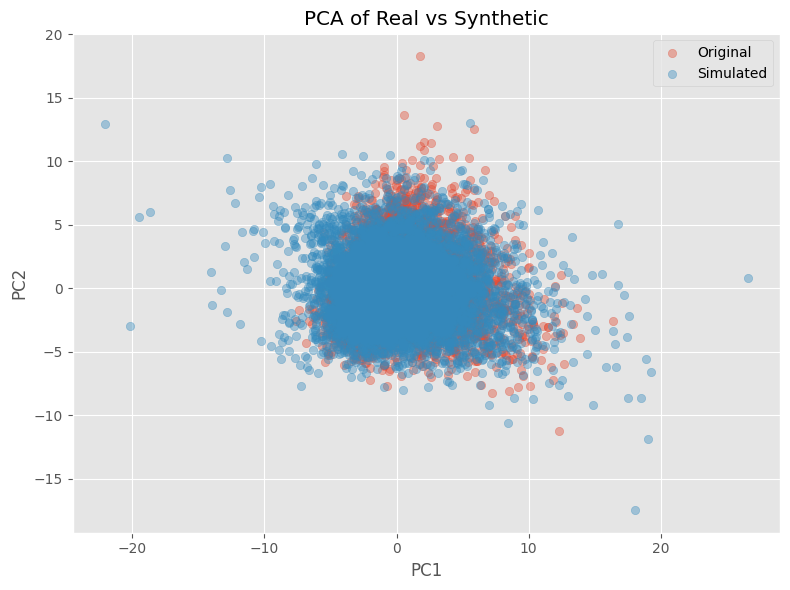

In [92]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1) Combine your real & one simulated dataset
combined = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
X = combined.drop(columns='source').values
y = combined['source'].values  # array of 'Original' / 'Simulated'

# 2) PCA → 2D
pca = PCA(n_components=2, random_state=2025)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for label in ['Original', 'Simulated']:
    idx = (y == label)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=label, alpha=0.4)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Real vs Synthetic')
plt.legend()
plt.tight_layout()
plt.show()



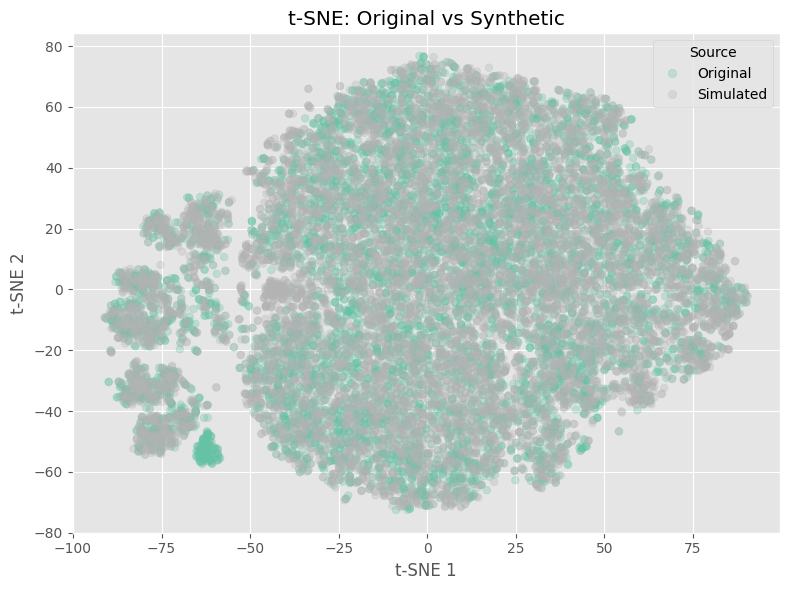

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 1) Combine your real & simulated datasets
combined = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
X = combined.drop(columns='source').values
y = combined['source'].map({'Original': 0, 'Simulated': 1}).values

# 2) Compute t‑SNE embedding
tsne = TSNE(n_components=2, random_state=2025)
X_tsne = tsne.fit_transform(X)

# 3) Plot on one figure with a ‘tab10’ palette
plt.figure(figsize=(8,6))
sc = plt.scatter(
    X_tsne[:,0], X_tsne[:,1],
    c=y,
    cmap='Set2',
    alpha=0.3,
    s=30
)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE: Original vs Synthetic')

# Build a legend
handles, _ = sc.legend_elements(prop="colors")
labels = ['Original','Simulated']
plt.legend(handles, labels, title="Source")
plt.tight_layout()
plt.show()


In [89]:
original_joint_df.describe()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,z1_0,z1_6,z1_12,...,z2_36,z2_48,z2_60,z3_0,z3_6,z3_12,z3_24,z3_36,z3_48,z3_60
count,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8.730000e+03,8730.000000,...,8730.000000,8730.000000,8730.000000,8.730000e+03,8.730000e+03,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000
mean,2.299183e-09,-1.818906e-10,1.521694e-09,6.294162e-11,-7.867702e-11,2.406983e-10,-8.422442e-10,-1.738896e-09,-6.507523e-10,-0.017343,...,-0.068959,-0.094569,-0.104447,-4.996124e-10,1.614026e-09,-0.013203,-0.051803,-0.089754,-0.119340,-0.129947
std,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000000e+00,1.000000e+00,0.996671,...,0.988735,0.983679,0.984441,1.000000e+00,1.000000e+00,1.000310,0.997831,0.994319,0.991342,0.990946
min,-2.131642e+00,-1.603052e+00,-2.900511e+00,-2.443710e+00,-2.435863e+00,-1.662750e+00,-2.536490e+00,-2.694344e+00,-2.936533e+00,-2.350258,...,-3.271774,-3.234669,-3.075133,-2.460851e+00,-2.656551e+00,-2.957581,-2.939618,-2.927605,-2.921929,-2.896451
25%,-5.924512e-01,-7.296928e-01,-6.966079e-01,-7.220590e-01,-7.185683e-01,-6.903835e-01,-7.027698e-01,-7.110983e-01,-7.031460e-01,-0.698165,...,-0.995926,-1.000000,-1.000000,-7.047421e-01,-7.062528e-01,-0.725998,-0.802460,-0.907673,-0.999014,-1.000000
50%,-3.274566e-02,-1.727681e-01,-1.298900e-01,-1.553042e-01,-1.461365e-01,-2.524819e-01,-1.730283e-01,-2.483411e-01,-2.145926e-01,-0.216305,...,0.001458,-0.052755,-0.090547,-1.140511e-01,-1.259987e-01,-0.148035,-0.196400,-0.239664,-0.283880,-0.299603
75%,6.668863e-01,5.487024e-01,5.312809e-01,5.504659e-01,5.694032e-01,3.942650e-01,5.604599e-01,4.788489e-01,4.833409e-01,0.472067,...,0.772164,0.756206,0.757796,5.564631e-01,5.670826e-01,0.558365,0.521302,0.476060,0.447146,0.428781
max,3.325488e+00,6.117949e+00,8.843143e+00,6.303562e+00,6.016449e+00,5.406554e+00,3.168418e+00,6.494693e+00,6.904329e+00,6.185554,...,2.912006,2.895459,2.806128,7.740544e+00,7.659078e+00,7.927403,6.964674,7.617393,7.614376,7.475106


In [90]:
simulated_joint_df.describe()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,z1_0,z1_6,z1_12,...,z2_36,z2_48,z2_60,z3_0,z3_6,z3_12,z3_24,z3_36,z3_48,z3_60
count,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,...,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000
mean,0.009895,0.006508,0.000732,-0.016308,-0.011294,0.008544,0.006674,0.091692,0.006360,0.045797,...,-0.075889,-0.130623,-0.137370,0.018732,0.017901,0.024702,-0.031155,-0.079305,-0.123622,-0.130705
std,0.998192,1.007440,0.990168,0.992270,0.992911,1.019798,1.011621,0.989794,1.124253,1.172565,...,0.969458,0.985027,1.005869,1.043045,1.012803,1.001832,0.990928,0.978945,0.979087,0.974830
min,-3.213316,-2.511786,-2.954214,-3.000522,-3.020279,-2.219005,-2.780629,-3.360472,-4.526419,-7.202268,...,-4.427335,-5.018154,-5.889839,-4.831897,-4.371188,-4.258174,-4.207759,-4.840388,-4.364671,-4.650657
25%,-0.697096,-0.728167,-0.681268,-0.725976,-0.736009,-0.674955,-0.725496,-0.581329,-0.688728,-0.667431,...,-0.885946,-1.000000,-1.000000,-0.682183,-0.671693,-0.661320,-0.773662,-0.874372,-1.000000,-0.992607
50%,-0.045569,-0.162250,-0.139772,-0.174642,-0.147171,-0.263641,-0.178384,-0.033297,-0.103125,-0.044320,...,-0.025633,-0.095052,-0.079921,-0.056408,-0.054417,-0.045560,-0.105288,-0.163039,-0.216966,-0.228400
75%,0.668077,0.596235,0.541723,0.546382,0.559594,0.419127,0.583942,0.654908,0.572434,0.638351,...,0.644635,0.627334,0.617275,0.614164,0.609542,0.612050,0.566896,0.509545,0.472955,0.465441
max,4.167768,5.181398,5.009252,4.971040,4.707630,8.426208,4.636414,6.756165,14.782804,16.820784,...,4.802210,3.923552,4.144931,5.990767,5.884120,5.561984,5.562142,5.722178,5.156795,4.933073


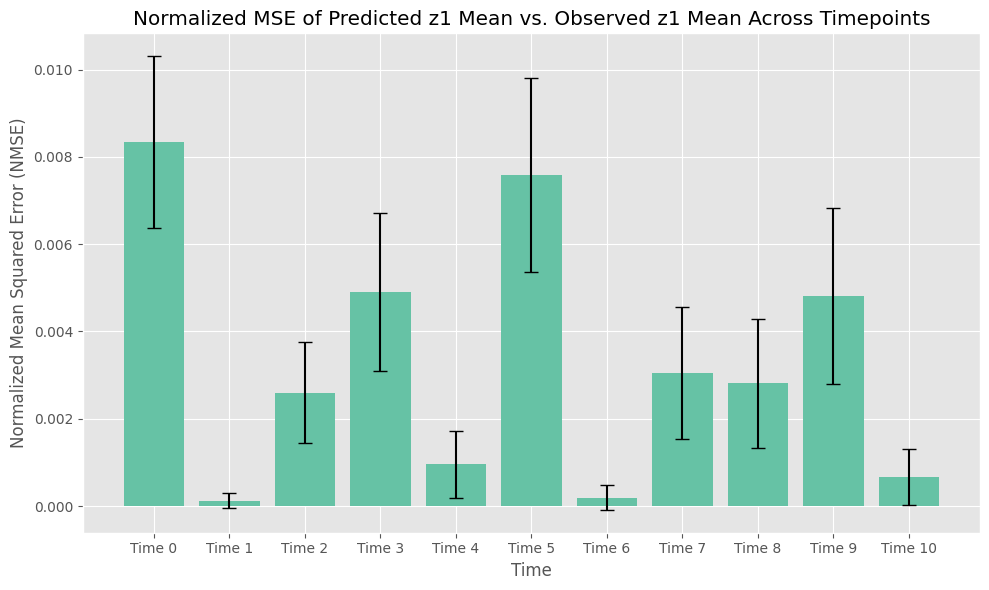

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
n_obs, total_dim = z_tensor.shape
timepoints = 11
z_dim = 3
num_samples = 500

x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)
# Reshape the observed z tensor: shape becomes (n_obs, timepoints, z_dim)
z_obs_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)
z1_obs = z_obs_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)

# Compute the observed mean and variance (using sample variance) across observations for each timepoint
z1_obs_mean = np.mean(z1_obs, axis=0)           # shape: (timepoints,)
z1_obs_var = np.var(z1_obs, axis=0, ddof=1)       # shape: (timepoints,)

# Initialize list to collect predictions for z1
z1_samples = []

# Generate predictions in each iteration
for _ in range(num_samples):
    # Sample new predictions each time
    _, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Reshape predictions: (n_obs, timepoints, z_dim)
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)
    
    # Extract z1 and convert to numpy array
    z1_pred = z_pred_reshaped[:, :, 0].detach().cpu().numpy()
    z1_samples.append(z1_pred)

# Stack predicted samples to create an array of shape (num_samples, n_obs, timepoints)
z1_samples_array = np.stack(z1_samples, axis=0)

# For each predicted sample, compute its mean across observations (shape: (num_samples, timepoints))
z1_samples_mean = np.mean(z1_samples_array, axis=1)

# Calculate the squared errors for each sample and timepoint: (predicted mean - observed mean)^2
squared_errors = (z1_samples_mean - z1_obs_mean)**2

# Normalize squared errors by dividing by the variance at each timepoint
# This yields a normalized squared error for each sample and timepoint.
normalized_squared_errors = squared_errors / z1_obs_var

# For each timepoint, compute:
# - The mean normalized MSE across all samples
# - The standard deviation of the normalized MSE (to use as error bars)
nmse_mean = np.mean(normalized_squared_errors, axis=0)
nmse_std = np.std(normalized_squared_errors, axis=0, ddof=1)

# Create a bar plot with error bars
time = np.arange(timepoints)
plt.figure(figsize=(10, 6))
plt.bar(time, nmse_mean, yerr=nmse_std, capsize=5, color=sns.color_palette("Set2")[0])
plt.xlabel("Time")
plt.ylabel("Normalized Mean Squared Error (NMSE)")
plt.title("Normalized MSE of Predicted z1 Mean vs. Observed z1 Mean Across Timepoints")
plt.xticks(time, [f"Time {t}" for t in time])
plt.tight_layout()
plt.show()


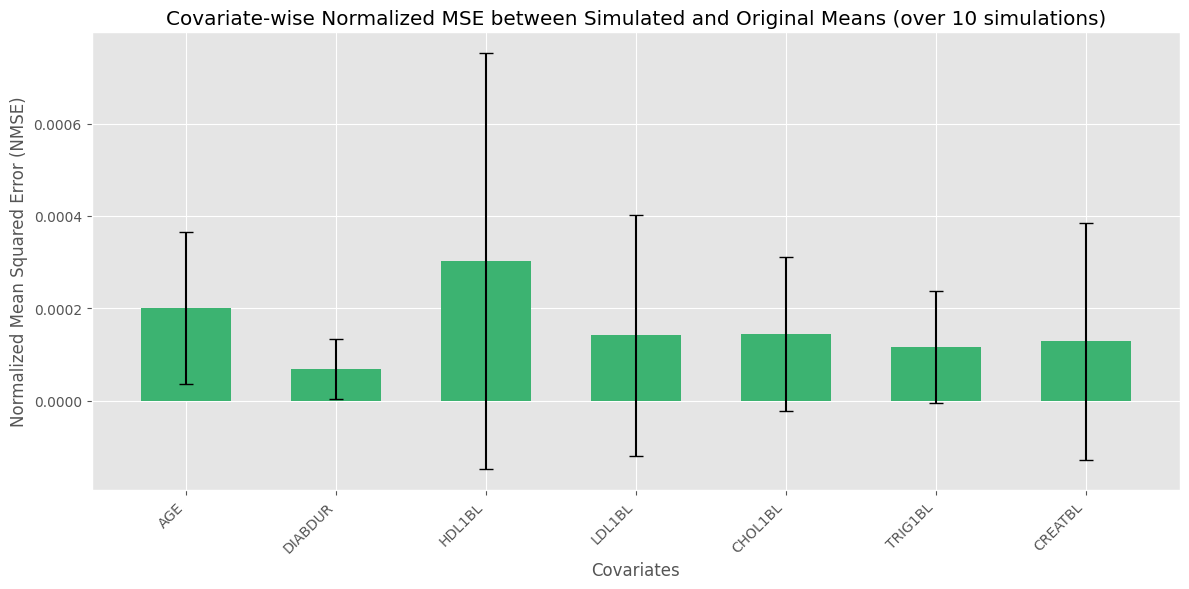

Classification Accuracy: Mean=0.499, Std=0.006, Min=0.492, Max=0.508
Classification AUC: Mean=0.498, Std=0.009, Min=0.490, Max=0.511


In [97]:

# Parameters for simulation loop
num_simulations = 10  # adjust as needed
accuracy_list = []
auc_list = []
# To store squared errors for each covariate in each simulation
covariate_squared_errors = []

# original_df is assumed to be created from df_bsl_features (the original covariate data)
original_df = deepcopy(df_bsl_norm)
original_df['source'] = 'Original'
# Compute the means for the original covariates (drop any non-covariate columns if necessary)
orig_cov_means = original_df.drop(columns='source').mean()

# Compute standard deviation for each covariate in the original data
orig_cov_std = original_df.drop(columns='source').std(ddof=1)

# Initialize a list to store normalized squared errors
normalized_covariate_squared_errors = []

for i in range(num_simulations):
    # Sample s_pred (and x if needed)
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Convert simulated s_pred to DataFrame with matching column names
    simulated_df = pd.DataFrame(s_pred.detach().cpu().numpy(), 
                                columns=original_df.drop(columns='source').columns)
    simulated_df['source'] = 'Simulated'
    
    # Combine original and simulated data for classification (if needed)
    combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
    X = combined_df.drop(columns='source')
    y = combined_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split data and train logistic regression as before...
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                        random_state=42, stratify=y)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    accuracy_list.append(accuracy_score(y_test, y_pred))
    auc_list.append(roc_auc_score(y_test, y_pred_proba))
    
    # Compute the squared error between simulated and original means for each covariate
    sim_cov_means = simulated_df.drop(columns='source').mean()
    # Normalize squared error by dividing by variance (i.e., std^2)
    normalized_error = ((sim_cov_means - orig_cov_means) / orig_cov_std) ** 2
    normalized_covariate_squared_errors.append(normalized_error)

# Convert the list of normalized squared errors into a DataFrame for analysis
norm_cov_err_df = pd.DataFrame(normalized_covariate_squared_errors)

# Compute mean and std of normalized errors for each covariate
norm_mse_mean_cov = norm_cov_err_df.mean()
norm_mse_std_cov = norm_cov_err_df.std(ddof=1)

# Bar plot for normalized MSE of covariates with error bars
fig, ax = plt.subplots(figsize=(12, 6))
x_positions = np.arange(len(norm_mse_mean_cov))
width = 0.6
ax.bar(x_positions, norm_mse_mean_cov, yerr=norm_mse_std_cov, capsize=5, width=width, color='mediumseagreen')
ax.set_xticks(x_positions)
ax.set_xticklabels(norm_mse_mean_cov.index, rotation=45, ha='right')
ax.set_xlabel('Covariates')
ax.set_ylabel('Normalized Mean Squared Error (NMSE)')
ax.set_title('Covariate-wise Normalized MSE between Simulated and Original Means (over {} simulations)'.format(num_simulations))
plt.tight_layout()
plt.show()

# Print summary statistics for classification performance over simulations
print("Classification Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("Classification AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


In [98]:
torch.save(model.state_dict(), 'joint_model_v1.pt')